This project based on Oxford Pet Dataset, This project has two stage classification, first stage is binary classification, and second stage is multiclass classification. to compelet this projece transfer leaning has been used. Resnet50 and vgg16 model has been applied to the dataset with k = 5 fold corss validation has been applied to this project and at the end the two models compared and find out which model is better ffor this dataset.
Dataset link: https://www.robots.ox.ac.uk/~vgg/data/pets/

#Step 1: Project Setup and Dependencies

Import required libraries,

Set random seeds for reproducibility

In [ ]:
# Import required libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Define base path and create project structure
BASE_PATH = '/content/oxford_pets_project'
directories = [
    'data/binary',
    'data/breeds',
    'models',
    'results/plots',
    'results/metrics',
    'checkpoints'
]

# Create directories
for dir in directories:
    path = os.path.join(BASE_PATH, dir)
    os.makedirs(path, exist_ok=True)
    print(f"Created directory: {path}")

# Define global variables
IMG_SIZE = 224
BATCH_SIZE = 32
N_FOLDS = 5

Created directory: /content/oxford_pets_project/data/binary
Created directory: /content/oxford_pets_project/data/breeds
Created directory: /content/oxford_pets_project/models
Created directory: /content/oxford_pets_project/results/plots
Created directory: /content/oxford_pets_project/results/metrics
Created directory: /content/oxford_pets_project/checkpoints


#Step 2: GPU Configuration

Check GPU availability
Configure GPU settings

In [ ]:
# Check GPU availability
print("Checking GPU availability...")
if tf.config.list_physical_devices('GPU'):
    print("GPU is available:")
    for gpu in tf.config.list_physical_devices('GPU'):
        print(f"  {gpu}")

    # Set memory growth
    for gpu in tf.config.list_physical_devices('GPU'):
        tf.config.experimental.set_memory_growth(gpu, True)
else:
    print("No GPU available, using CPU.")

# Print TensorFlow version
print(f"\nTensorFlow version: {tf.__version__}")

Checking GPU availability...
GPU is available:
  PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')

TensorFlow version: 2.17.1


#Step 3: Dataset Download and Organization

Download Oxford Pet Dataset

Organize dataset structure

Create data directories

In [ ]:
import os
import shutil
import numpy as np

def download_dataset():
    """
    Download Oxford Pets dataset
    """
    print("Downloading dataset...")

    # Download images and annotations
    !wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
    !wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz

    print("\nExtracting files...")
    !tar -xf images.tar.gz
    !tar -xf annotations.tar.gz

def organize_dataset():
    """
    Organize dataset into binary and breed classification directories
    """
    print("\nOrganizing dataset...")

    # Create directories for binary and breed classification
    binary_dir = os.path.join(BASE_PATH, 'data/binary')
    breed_dir = os.path.join(BASE_PATH, 'data/breeds')

    # Create cat and dog directories
    for class_type in ['cat', 'dog']:
        os.makedirs(os.path.join(binary_dir, class_type), exist_ok=True)

    # Read annotations file
    with open('annotations/list.txt', 'r') as f:
        lines = f.readlines()[6:]  # Skip header lines

    for line in lines:
        # Parse image information
        img_name, class_id, species, _ = line.strip().split(' ')
        img_path = f'images/{img_name}.jpg'

        if not os.path.exists(img_path):
            print(f"Warning: Image not found - {img_path}")
            continue

        # Determine if it's a cat or dog (1 for cat, 2 for dog)
        species = 'cat' if int(species) == 1 else 'dog'
        breed = img_name.rsplit('_', 1)[0]

        # Create breed directory if it doesn't exist
        breed_class_dir = os.path.join(breed_dir, breed)
        os.makedirs(breed_class_dir, exist_ok=True)

        # Copy image to binary classification directory
        binary_dest = os.path.join(binary_dir, species, f'{img_name}.jpg')
        shutil.copy2(img_path, binary_dest)

        # Copy image to breed classification directory
        breed_dest = os.path.join(breed_class_dir, f'{img_name}.jpg')
        shutil.copy2(img_path, breed_dest)

def verify_organization():
    """
    Verify dataset organization and print statistics
    """
    print("\nVerifying dataset organization...")

    # Check binary classification
    binary_dir = os.path.join(BASE_PATH, 'data/binary')
    print("\nBinary Classification:")
    for class_type in ['cat', 'dog']:
        count = len(os.listdir(os.path.join(binary_dir, class_type)))
        print(f"Number of {class_type}s: {count}")

    # Check breed classification
    breed_dir = os.path.join(BASE_PATH, 'data/breeds')
    print("\nBreed Classification:")
    breeds = os.listdir(breed_dir)
    total_breeds = len(breeds)
    total_images = sum(len(os.listdir(os.path.join(breed_dir, breed))) for breed in breeds)
    print(f"Number of breeds: {total_breeds}")
    print(f"Total images: {total_images}")

def cleanup_files():
    """
    Clean up downloaded archives and temporary files
    """
    print("\nCleaning up temporary files...")
    files_to_remove = ['images.tar.gz', 'annotations.tar.gz']
    for file in files_to_remove:
        if os.path.exists(file):
            os.remove(file)
            print(f"Removed {file}")

# Execute dataset download and organization
print("Starting dataset setup...")
download_dataset()
organize_dataset()
verify_organization()
cleanup_files()
print("\nDataset setup completed!")

Starting dataset setup...
--2024-12-12 05:27:19--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/pets/images.tar.gz [following]
--2024-12-12 05:27:20--  https://thor.robots.ox.ac.uk/pets/images.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 791918971 (755M) [application/octet-stream]
Saving to: ‘images.tar.gz’

images.tar.gz       100%[===================>] 755.23M  38.0MB/s    in 21s     

2024-12-12 05:27:41 (36.2 MB/s) - ‘images.tar.gz’ saved [791918971/791918971]

--2024-12-12 05:27:41--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotati

#Step 4: Data Exploration and Analysis

Dataset statistics

Class distribution visualization

Sample image visualization

Starting data exploration and analysis...
Analyzing dataset statistics...

Dataset Statistics:
Total images: 7349
Number of cats: 2371
Number of dogs: 4978
Number of breeds: 37
Average images per breed: 198.6


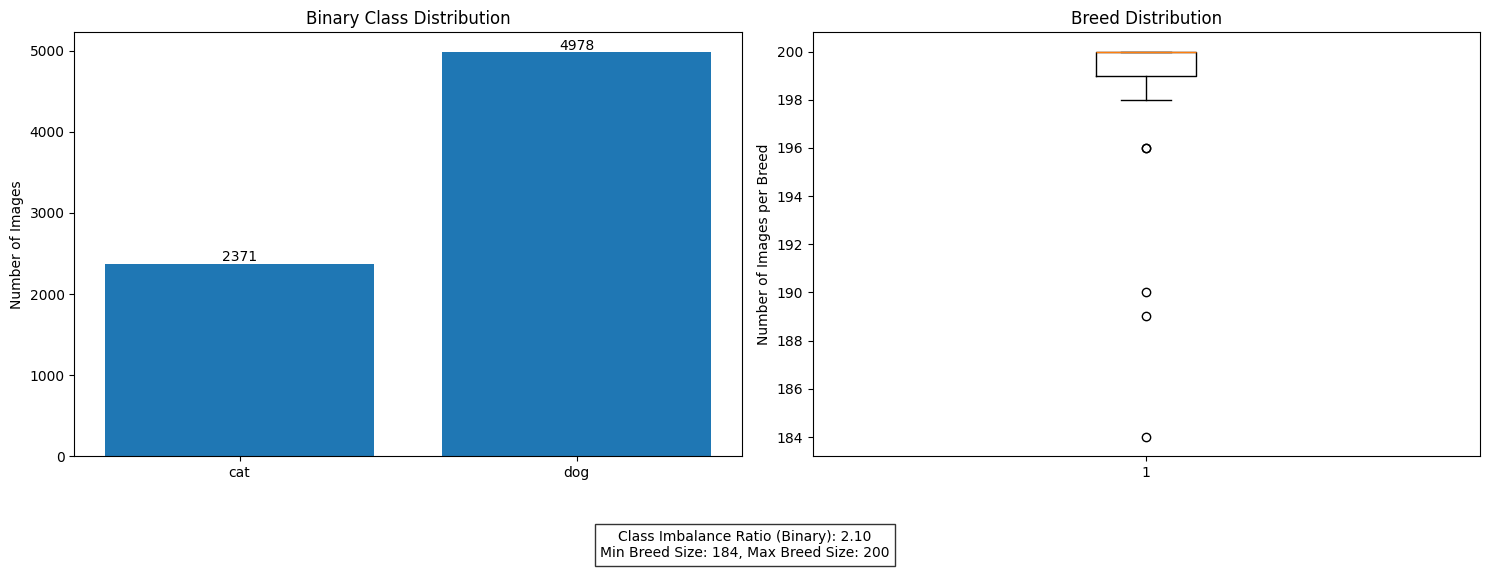

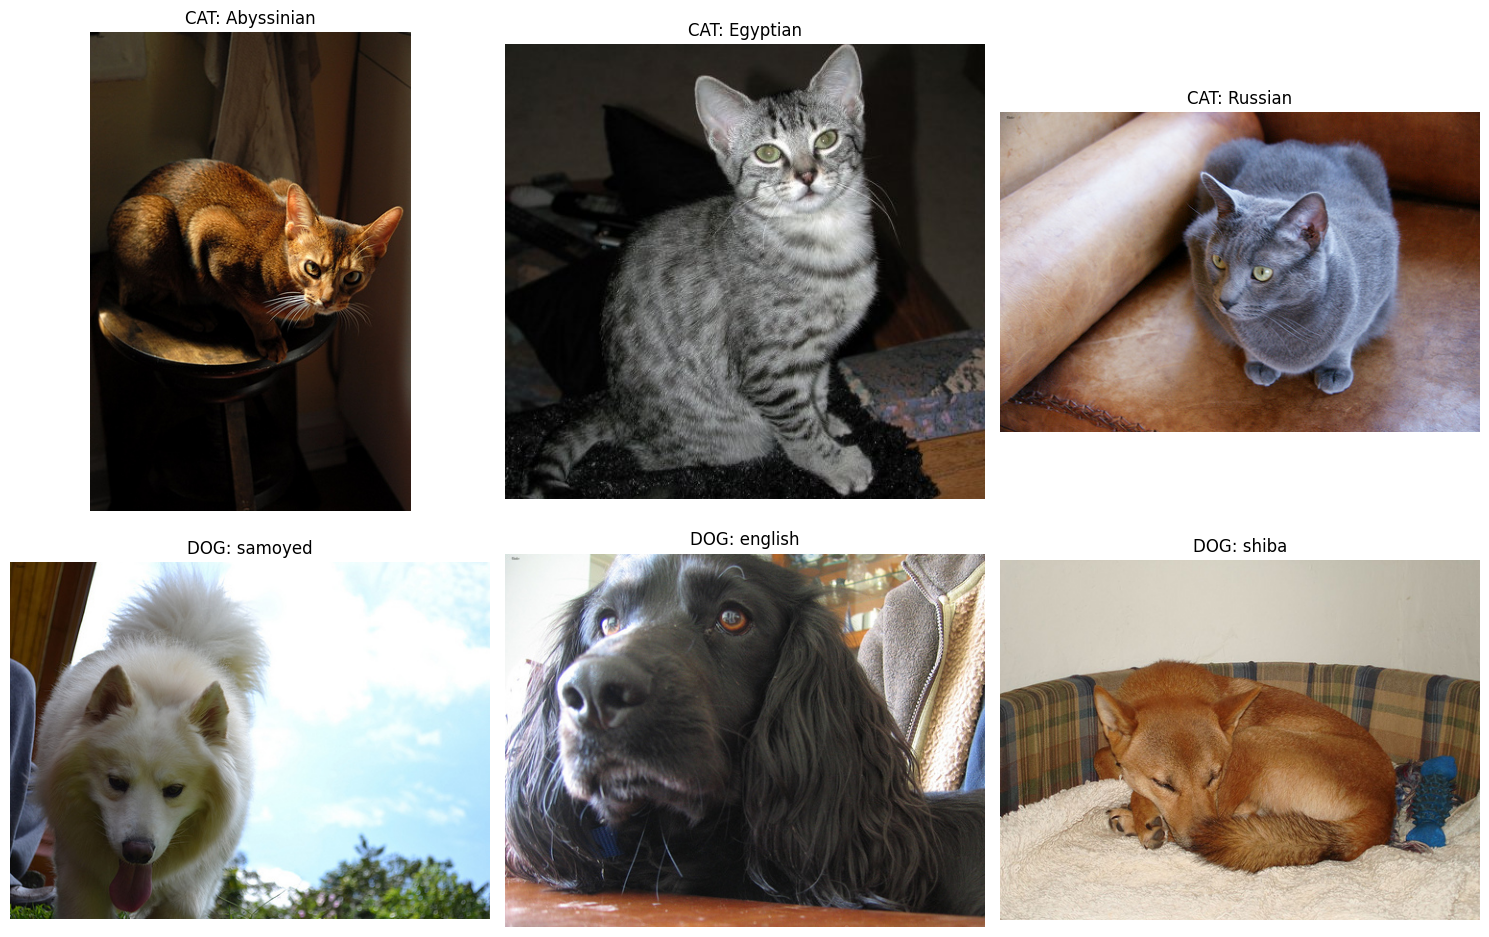


Class Imbalance Analysis:

Binary Classification:
cat: 2371 images (32.3%)
dog: 4978 images (67.7%)

Breed Classification:
Mean images per breed: 198.6
Median images per breed: 200.0
Std Dev: 3.5
Min images: 184
Max images: 200

Most represented breeds:
miniature_pinscher: 200 images
Persian: 200 images
yorkshire_terrier: 200 images

Least represented breeds:
Bombay: 184 images
staffordshire_bull_terrier: 189 images
Egyptian_Mau: 190 images

Data exploration and analysis completed!


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

def analyze_dataset_statistics():
    """
    Analyze and display dataset statistics
    """
    print("Analyzing dataset statistics...")

    # Binary classification statistics
    binary_stats = {
        'cat': len(os.listdir(os.path.join(BASE_PATH, 'data/binary/cat'))),
        'dog': len(os.listdir(os.path.join(BASE_PATH, 'data/binary/dog')))
    }

    # Breed classification statistics
    breed_stats = {}
    breed_path = os.path.join(BASE_PATH, 'data/breeds')
    for breed in os.listdir(breed_path):
        breed_stats[breed] = len(os.listdir(os.path.join(breed_path, breed)))

    # Print statistics
    print("\nDataset Statistics:")
    print(f"Total images: {sum(binary_stats.values())}")
    print(f"Number of cats: {binary_stats['cat']}")
    print(f"Number of dogs: {binary_stats['dog']}")
    print(f"Number of breeds: {len(breed_stats)}")
    print(f"Average images per breed: {np.mean(list(breed_stats.values())):.1f}")

    return binary_stats, breed_stats

def visualize_class_distribution(binary_stats, breed_stats):
    """
    Visualize class distribution and check for class imbalance
    """
    plt.figure(figsize=(15, 5))

    # Binary Classification Distribution
    plt.subplot(1, 2, 1)
    bars = plt.bar(binary_stats.keys(), binary_stats.values())
    plt.title('Binary Class Distribution')
    plt.ylabel('Number of Images')
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom')

    # Breed Distribution
    plt.subplot(1, 2, 2)
    breed_values = list(breed_stats.values())
    breed_names = list(breed_stats.keys())
    plt.boxplot(breed_values)
    plt.title('Breed Distribution')
    plt.ylabel('Number of Images per Breed')

    # Add class imbalance information
    imbalance_ratio = max(binary_stats.values()) / min(binary_stats.values())
    plt.figtext(0.5, -0.1,
                f'Class Imbalance Ratio (Binary): {imbalance_ratio:.2f}\n'
                f'Min Breed Size: {min(breed_values)}, Max Breed Size: {max(breed_values)}',
                ha='center', va='center', bbox=dict(facecolor='white', alpha=0.8))

    plt.tight_layout()
    plt.savefig(os.path.join(BASE_PATH, 'results/plots/class_distribution.png'),
                bbox_inches='tight')
    plt.show()

def visualize_sample_images():
    """
    Display sample images from both cats and dogs of different breeds
    """
    plt.figure(figsize=(15, 10))

    # Get random samples
    for i, animal in enumerate(['cat', 'dog']):
        path = os.path.join(BASE_PATH, f'data/binary/{animal}')
        samples = np.random.choice(os.listdir(path), 3, replace=False)

        for j, sample in enumerate(samples):
            plt.subplot(2, 3, i*3 + j + 1)
            img_path = os.path.join(path, sample)
            img = Image.open(img_path)
            plt.imshow(img)
            breed = sample.split('_')[0]
            plt.title(f'{animal.upper()}: {breed}')
            plt.axis('off')

    plt.tight_layout()
    plt.savefig(os.path.join(BASE_PATH, 'results/plots/sample_images.png'))
    plt.show()

def check_class_imbalance(binary_stats, breed_stats):
    """
    Detailed analysis of class imbalance
    """
    print("\nClass Imbalance Analysis:")

    # Binary classification imbalance
    total_images = sum(binary_stats.values())
    print("\nBinary Classification:")
    for class_name, count in binary_stats.items():
        percentage = (count / total_images) * 100
        print(f"{class_name}: {count} images ({percentage:.1f}%)")

    # Breed classification imbalance
    breed_counts = np.array(list(breed_stats.values()))
    print("\nBreed Classification:")
    print(f"Mean images per breed: {np.mean(breed_counts):.1f}")
    print(f"Median images per breed: {np.median(breed_counts):.1f}")
    print(f"Std Dev: {np.std(breed_counts):.1f}")
    print(f"Min images: {np.min(breed_counts)}")
    print(f"Max images: {np.max(breed_counts)}")

    # Identify most and least represented breeds
    sorted_breeds = sorted(breed_stats.items(), key=lambda x: x[1])
    print("\nMost represented breeds:")
    for breed, count in sorted_breeds[-3:]:
        print(f"{breed}: {count} images")
    print("\nLeast represented breeds:")
    for breed, count in sorted_breeds[:3]:
        print(f"{breed}: {count} images")

# Execute analysis
print("Starting data exploration and analysis...")
binary_stats, breed_stats = analyze_dataset_statistics()
visualize_class_distribution(binary_stats, breed_stats)
visualize_sample_images()
check_class_imbalance(binary_stats, breed_stats)
print("\nData exploration and analysis completed!")

#Step 5: Data Preprocessing and Augmentation

Image resizing to 224x224

Data augmentation setup (horizontal flip, rotation, zoom, brightness)

Image normalization

Data generator creation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

def create_data_generators():
    """
    Create train and validation data generators with augmentation
    """
    # Training data generator with augmentation
    train_datagen = ImageDataGenerator(
        rescale=1./255,          # Normalize pixel values
        rotation_range=20,        # Random rotation
        width_shift_range=0.2,    # Random horizontal shift
        height_shift_range=0.2,   # Random vertical shift
        horizontal_flip=True,     # Random horizontal flip
        zoom_range=0.2,          # Random zoom
        shear_range=0.2,         # Random shear
        fill_mode='nearest'      # Fill strategy
    )

    # Validation/Test data generator (only rescaling)
    valid_datagen = ImageDataGenerator(rescale=1./255)

    return train_datagen, valid_datagen

def prepare_k_fold_data(k=5):
    """
    Prepare k-fold cross validation data for both stages
    """
    # Initialize KFold
    kfold = KFold(n_splits=k, shuffle=True, random_state=42)

    # Create directories for each fold
    for fold in range(k):
        # Stage 1: Binary Classification
        for split in ['train', 'val']:
            for class_type in ['cat', 'dog']:
                os.makedirs(os.path.join(BASE_PATH, f'data/folds/fold_{fold}/binary/{split}/{class_type}'),
                           exist_ok=True)

        # Stage 2: Breed Classification
        for split in ['train', 'val']:
            breeds_path = os.path.join(BASE_PATH, f'data/folds/fold_{fold}/breeds/{split}')
            os.makedirs(breeds_path, exist_ok=True)

            # Create breed directories
            for breed in os.listdir(os.path.join(BASE_PATH, 'data/breeds')):
                os.makedirs(os.path.join(breeds_path, breed), exist_ok=True)

def create_fold_generators(fold, train_datagen, valid_datagen):
    """
    Create data generators for a specific fold
    """
    # Stage 1: Binary Classification
    binary_train = train_datagen.flow_from_directory(
        os.path.join(BASE_PATH, f'data/folds/fold_{fold}/binary/train'),
        target_size=(224, 224),
        batch_size=32,
        class_mode='binary',
        shuffle=True
    )

    binary_val = valid_datagen.flow_from_directory(
        os.path.join(BASE_PATH, f'data/folds/fold_{fold}/binary/val'),
        target_size=(224, 224),
        batch_size=32,
        class_mode='binary',
        shuffle=False
    )

    # Stage 2: Breed Classification
    breed_train = train_datagen.flow_from_directory(
        os.path.join(BASE_PATH, f'data/folds/fold_{fold}/breeds/train'),
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        shuffle=True
    )

    breed_val = valid_datagen.flow_from_directory(
        os.path.join(BASE_PATH, f'data/folds/fold_{fold}/breeds/val'),
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        shuffle=False
    )

    return {
        'binary': (binary_train, binary_val),
        'breed': (breed_train, breed_val)
    }

def organize_k_fold_data(k=5):
    """
    Organize data into k-folds for both stages
    """
    # Initialize KFold
    kfold = KFold(n_splits=k, shuffle=True, random_state=42)

    # Stage 1: Binary Classification
    for class_type in ['cat', 'dog']:
        files = os.listdir(os.path.join(BASE_PATH, f'data/binary/{class_type}'))
        files = np.array(files)

        for fold, (train_idx, val_idx) in enumerate(kfold.split(files)):
            train_files = files[train_idx]
            val_files = files[val_idx]

            # Copy files to fold directories
            for file in train_files:
                src = os.path.join(BASE_PATH, f'data/binary/{class_type}/{file}')
                dst = os.path.join(BASE_PATH, f'data/folds/fold_{fold}/binary/train/{class_type}/{file}')
                shutil.copy2(src, dst)

            for file in val_files:
                src = os.path.join(BASE_PATH, f'data/binary/{class_type}/{file}')
                dst = os.path.join(BASE_PATH, f'data/folds/fold_{fold}/binary/val/{class_type}/{file}')
                shutil.copy2(src, dst)

    # Stage 2: Breed Classification
    for breed in os.listdir(os.path.join(BASE_PATH, 'data/breeds')):
        files = os.listdir(os.path.join(BASE_PATH, f'data/breeds/{breed}'))
        files = np.array(files)

        for fold, (train_idx, val_idx) in enumerate(kfold.split(files)):
            train_files = files[train_idx]
            val_files = files[val_idx]

            # Copy files to fold directories
            for file in train_files:
                src = os.path.join(BASE_PATH, f'data/breeds/{breed}/{file}')
                dst = os.path.join(BASE_PATH, f'data/folds/fold_{fold}/breeds/train/{breed}/{file}')
                shutil.copy2(src, dst)

            for file in val_files:
                src = os.path.join(BASE_PATH, f'data/breeds/{breed}/{file}')
                dst = os.path.join(BASE_PATH, f'data/folds/fold_{fold}/breeds/val/{breed}/{file}')
                shutil.copy2(src, dst)

def verify_k_fold_data(k=5):
    """
    Verify k-fold data organization
    """
    for fold in range(k):
        print(f"\nFold {fold + 1}:")

        # Verify binary classification data
        print("\nBinary Classification:")
        for split in ['train', 'val']:
            for class_type in ['cat', 'dog']:
                path = os.path.join(BASE_PATH, f'data/folds/fold_{fold}/binary/{split}/{class_type}')
                count = len(os.listdir(path))
                print(f"{split}/{class_type}: {count} images")

        # Verify breed classification data
        print("\nBreed Classification:")
        for split in ['train', 'val']:
            breed_path = os.path.join(BASE_PATH, f'data/folds/fold_{fold}/breeds/{split}')
            total_images = sum(len(os.listdir(os.path.join(breed_path, breed)))
                             for breed in os.listdir(breed_path))
            print(f"{split}: {total_images} images, {len(os.listdir(breed_path))} breeds")

# Execute data preprocessing
print("Starting data preprocessing with k-fold cross validation...")

# Create data generators
train_datagen, valid_datagen = create_data_generators()

# Prepare k-fold data structure
print("\nPreparing k-fold data structure...")
prepare_k_fold_data(k=5)

# Organize data into folds
print("\nOrganizing data into folds...")
organize_k_fold_data(k=5)

# Verify k-fold organization
print("\nVerifying k-fold data organization...")
verify_k_fold_data(k=5)

print("\nData preprocessing completed!")

Starting data preprocessing with k-fold cross validation...

Preparing k-fold data structure...

Organizing data into folds...

Verifying k-fold data organization...

Fold 1:

Binary Classification:
train/cat: 1896 images
train/dog: 3982 images
val/cat: 475 images
val/dog: 996 images

Breed Classification:
train: 5876 images, 37 breeds
val: 1473 images, 37 breeds

Fold 2:

Binary Classification:
train/cat: 1897 images
train/dog: 3982 images
val/cat: 474 images
val/dog: 996 images

Breed Classification:
train: 5878 images, 37 breeds
val: 1471 images, 37 breeds

Fold 3:

Binary Classification:
train/cat: 1897 images
train/dog: 3982 images
val/cat: 474 images
val/dog: 996 images

Breed Classification:
train: 5878 images, 37 breeds
val: 1471 images, 37 breeds

Fold 4:

Binary Classification:
train/cat: 1897 images
train/dog: 3983 images
val/cat: 474 images
val/dog: 995 images

Breed Classification:
train: 5879 images, 37 breeds
val: 1470 images, 37 breeds

Fold 5:

Binary Classification:
t

#Step 6: Data Split and K-fold Setup

Create train/validation/test splits

Setup 5-fold cross-validation

Create data generators for each fold

In [ ]:
import numpy as np
import os
import shutil
from sklearn.model_selection import KFold

def setup_kfold_directories(k=5):
    """
    Create directory structure for k-fold cross validation
    """
    print(f"Setting up {k}-fold cross validation directory structure...")

    # Create main fold directories
    for fold in range(k):
        # Stage 1: Binary Classification
        for split in ['train', 'val']:
            for class_type in ['cat', 'dog']:
                os.makedirs(os.path.join(BASE_PATH, f'data/kfold/fold_{fold}/binary/{split}/{class_type}'),
                           exist_ok=True)

        # Stage 2: Breed Classification
        for split in ['train', 'val']:
            breed_base = os.path.join(BASE_PATH, f'data/kfold/fold_{fold}/breeds/{split}')
            os.makedirs(breed_base, exist_ok=True)

def create_breed_directories(k=5):
    """
    Create breed directories in each fold
    """
    # Get list of breeds
    breeds = os.listdir(os.path.join(BASE_PATH, 'data/breeds'))

    # Create breed directories in each fold
    for fold in range(k):
        for split in ['train', 'val']:
            for breed in breeds:
                os.makedirs(os.path.join(BASE_PATH, f'data/kfold/fold_{fold}/breeds/{split}/{breed}'),
                           exist_ok=True)

def split_data_into_folds(k=5):
    """
    Split data into k folds for both binary and breed classification
    """
    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    # Stage 1: Binary Classification
    print("\nSplitting binary classification data...")
    for class_type in ['cat', 'dog']:
        files = os.listdir(os.path.join(BASE_PATH, f'data/binary/{class_type}'))
        files = np.array(files)

        for fold, (train_idx, val_idx) in enumerate(kf.split(files)):
            print(f"Processing fold {fold+1} for {class_type}s...")

            # Get train and validation files
            train_files = files[train_idx]
            val_files = files[val_idx]

            # Copy files to respective directories
            for file in train_files:
                src = os.path.join(BASE_PATH, f'data/binary/{class_type}/{file}')
                dst = os.path.join(BASE_PATH, f'data/kfold/fold_{fold}/binary/train/{class_type}/{file}')
                shutil.copy2(src, dst)

            for file in val_files:
                src = os.path.join(BASE_PATH, f'data/binary/{class_type}/{file}')
                dst = os.path.join(BASE_PATH, f'data/kfold/fold_{fold}/binary/val/{class_type}/{file}')
                shutil.copy2(src, dst)

    # Stage 2: Breed Classification
    print("\nSplitting breed classification data...")
    for breed in os.listdir(os.path.join(BASE_PATH, 'data/breeds')):
        files = os.listdir(os.path.join(BASE_PATH, f'data/breeds/{breed}'))
        files = np.array(files)

        for fold, (train_idx, val_idx) in enumerate(kf.split(files)):
            print(f"Processing fold {fold+1} for breed: {breed}")

            # Get train and validation files
            train_files = files[train_idx]
            val_files = files[val_idx]

            # Copy files to respective directories
            for file in train_files:
                src = os.path.join(BASE_PATH, f'data/breeds/{breed}/{file}')
                dst = os.path.join(BASE_PATH, f'data/kfold/fold_{fold}/breeds/train/{breed}/{file}')
                shutil.copy2(src, dst)

            for file in val_files:
                src = os.path.join(BASE_PATH, f'data/breeds/{breed}/{file}')
                dst = os.path.join(BASE_PATH, f'data/kfold/fold_{fold}/breeds/val/{breed}/{file}')
                shutil.copy2(src, dst)

def verify_fold_split(k=5):
    """
    Verify the k-fold split and print statistics
    """
    print("\nVerifying k-fold split:")

    for fold in range(k):
        print(f"\nFold {fold+1}:")

        # Binary Classification Statistics
        print("\nBinary Classification:")
        for split in ['train', 'val']:
            for class_type in ['cat', 'dog']:
                path = os.path.join(BASE_PATH, f'data/kfold/fold_{fold}/binary/{split}/{class_type}')
                count = len(os.listdir(path))
                print(f"{split.capitalize()} {class_type}s: {count}")

        # Breed Classification Statistics
        print("\nBreed Classification:")
        for split in ['train', 'val']:
            breed_path = os.path.join(BASE_PATH, f'data/kfold/fold_{fold}/breeds/{split}')
            total_images = sum(len(os.listdir(os.path.join(breed_path, breed)))
                             for breed in os.listdir(breed_path))
            num_breeds = len(os.listdir(breed_path))
            print(f"{split.capitalize()}: {total_images} images across {num_breeds} breeds")

# Execute k-fold setup
N_FOLDS = 5

print("Starting k-fold cross validation setup...")
setup_kfold_directories(N_FOLDS)

print("\nCreating breed directories...")
create_breed_directories(N_FOLDS)

print("\nSplitting data into folds...")
split_data_into_folds(N_FOLDS)

print("\nVerifying fold split...")
verify_fold_split(N_FOLDS)

print("\nK-fold setup completed successfully!")

Starting k-fold cross validation setup...
Setting up 5-fold cross validation directory structure...

Creating breed directories...

Splitting data into folds...

Splitting binary classification data...
Processing fold 1 for cats...
Processing fold 2 for cats...
Processing fold 3 for cats...
Processing fold 4 for cats...
Processing fold 5 for cats...
Processing fold 1 for dogs...
Processing fold 2 for dogs...
Processing fold 3 for dogs...
Processing fold 4 for dogs...
Processing fold 5 for dogs...

Splitting breed classification data...
Processing fold 1 for breed: american_bulldog
Processing fold 2 for breed: american_bulldog
Processing fold 3 for breed: american_bulldog
Processing fold 4 for breed: american_bulldog
Processing fold 5 for breed: american_bulldog
Processing fold 1 for breed: British_Shorthair
Processing fold 2 for breed: British_Shorthair
Processing fold 3 for breed: British_Shorthair
Processing fold 4 for breed: British_Shorthair
Processing fold 5 for breed: British_Sho

#Step 7: Model Creation - ResNet50

Binary classification model setup,

Multi-class classification model setup,

Model compilation with appropriate parameters

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def create_resnet50_binary():
    """
    Create ResNet50 model for binary classification (cat vs dog)
    """
    print("\nCreating ResNet50 model for binary classification...")

    # Load the pretrained ResNet50 model
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )

    # Freeze the base model layers
    base_model.trainable = False

    # Add custom layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    predictions = Dense(1, activation='sigmoid')(x)

    # Create model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', 'AUC', 'Precision', 'Recall']
    )

    return model

def create_resnet50_breed():
    """
    Create ResNet50 model for breed classification
    """
    print("\nCreating ResNet50 model for breed classification...")

    # Load the pretrained ResNet50 model
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )

    # Freeze the base model layers
    base_model.trainable = False

    # Add custom layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.4)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.3)(x)
    predictions = Dense(37, activation='softmax')(x)  # 37 breeds

    # Create model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy', 'AUC', 'Precision', 'Recall']
    )

    return model

def verify_models():
    """
    Create and verify both models
    """
    # Create models
    binary_model = create_resnet50_binary()
    breed_model = create_resnet50_breed()

    # Print model summaries
    print("\nBinary Classification Model Summary:")
    binary_model.summary()

    print("\nBreed Classification Model Summary:")
    breed_model.summary()

    return binary_model, breed_model

def save_initial_models(binary_model, breed_model):
    """
    Save initial model architectures
    """
    # Create models directory if it doesn't exist
    os.makedirs(os.path.join(BASE_PATH, 'models'), exist_ok=True)

    # Save models
    binary_model.save(os.path.join(BASE_PATH, 'models/resnet50_binary_initial.keras'))
    breed_model.save(os.path.join(BASE_PATH, 'models/resnet50_breed_initial.keras'))

    print("\nInitial models saved successfully!")

# Execute model creation
print("Starting ResNet50 model creation...")

# Create and verify models
binary_model, breed_model = verify_models()

# Save initial models
save_initial_models(binary_model, breed_model)

print("\nResNet50 model creation completed!")

Starting ResNet50 model creation...

Creating ResNet50 model for binary classification...
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Creating ResNet50 model for breed classification...

Binary Classification Model Summary:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 24,768,385 (94.48 MB)

 Trainable params: 1,180,673 (4.50 MB)

 Non-trainable params: 23,587,712 (89.98 MB)


Breed Classification Model Summary:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 26,229,669 (100.06 MB)

 Trainable params: 2,641,957 (10.08 MB)

 Non-trainable params: 23,587,712 (89.98 MB)


Initial models saved successfully!

ResNet50 model creation completed!


#Step 8: Model Creation - VGG16

Binary classification model setup,

Multi-class classification model setup,

Model compilation with appropriate parameters

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def create_vgg16_binary():
    """
    Create VGG16 model for binary classification (cat vs dog)
    """
    print("\nCreating VGG16 model for binary classification...")

    # Load the pretrained VGG16 model
    base_model = VGG16(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )

    # Freeze the base model layers
    base_model.trainable = False

    # Add custom layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    predictions = Dense(1, activation='sigmoid')(x)

    # Create model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', 'AUC', 'Precision', 'Recall']
    )

    return model

def create_vgg16_breed():
    """
    Create VGG16 model for breed classification
    """
    print("\nCreating VGG16 model for breed classification...")

    # Load the pretrained VGG16 model
    base_model = VGG16(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )

    # Freeze the base model layers
    base_model.trainable = False

    # Add custom layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.4)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.3)(x)
    predictions = Dense(37, activation='softmax')(x)  # 37 breeds

    # Create model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy', 'AUC', 'Precision', 'Recall']
    )

    return model

def verify_vgg16_models():
    """
    Create and verify both VGG16 models
    """
    # Create models
    binary_model = create_vgg16_binary()
    breed_model = create_vgg16_breed()

    # Print model summaries
    print("\nVGG16 Binary Classification Model Summary:")
    binary_model.summary()

    print("\nVGG16 Breed Classification Model Summary:")
    breed_model.summary()

    return binary_model, breed_model

def save_vgg16_models(binary_model, breed_model):
    """
    Save initial VGG16 model architectures
    """
    # Create models directory if it doesn't exist
    os.makedirs(os.path.join(BASE_PATH, 'models'), exist_ok=True)

    # Save models
    binary_model.save(os.path.join(BASE_PATH, 'models/vgg16_binary_initial.keras'))
    breed_model.save(os.path.join(BASE_PATH, 'models/vgg16_breed_initial.keras'))

    print("\nInitial VGG16 models saved successfully!")

# Execute VGG16 model creation
print("Starting VGG16 model creation...")

# Create and verify models
binary_model, breed_model = verify_vgg16_models()

# Save initial models
save_vgg16_models(binary_model, breed_model)

print("\nVGG16 model creation completed!")

Starting VGG16 model creation...

Creating VGG16 model for binary classification...
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Creating VGG16 model for breed classification...

VGG16 Binary Classification Model Summary:


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 512)                 │         262,6

 Total params: 15,108,929 (57.64 MB)

 Trainable params: 394,241 (1.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)


VGG16 Breed Classification Model Summary:


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1024)                │         525,3

 Total params: 15,783,781 (60.21 MB)

 Trainable params: 1,069,093 (4.08 MB)

 Non-trainable params: 14,714,688 (56.13 MB)


Initial VGG16 models saved successfully!

VGG16 model creation completed!


#Step 9: Training and Validation - ResNet50

Binary classification training with K-fold,

Multi-class classification training with K-fold,

Model checkpointing,

Training history logging
visualize each fold model acccuracy and loss

Starting ResNet50 training...

Processing fold 1/5
Found 5878 images belonging to 2 classes.
Found 1471 images belonging to 2 classes.
Found 5876 images belonging to 37 classes.
Found 1473 images belonging to 37 classes.

Training ResNet50 models for fold 1/5

Training binary classification model...

Creating ResNet50 model for binary classification...
Epoch 1/15
183/184 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - AUC: 0.5310 - Precision: 0.6855 - Recall: 0.9023 - accuracy: 0.6473 - loss: 0.6643
Epoch 1: val_accuracy improved from -inf to 0.67709, saving model to /content/oxford_pets_project/models/checkpoints/resnet50_binary_fold_0.keras
184/184 ━━━━━━━━━━━━━━━━━━━━ 111s 505ms/step - AUC: 0.5311 - Precision: 0.6854 - Recall: 0.9028 - accuracy: 0.6474 - loss: 0.6641 - val_AUC: 0.6721 - val_Precision: 0.6771 - val_Recall: 1.0000 - val_accuracy: 0.6771 - val_loss: 0.6028
Epoch 2/15
183/184 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - AUC: 0.6251 - Precision: 0.6723 - Recall: 0.9815 - accuracy: 0.6676 -

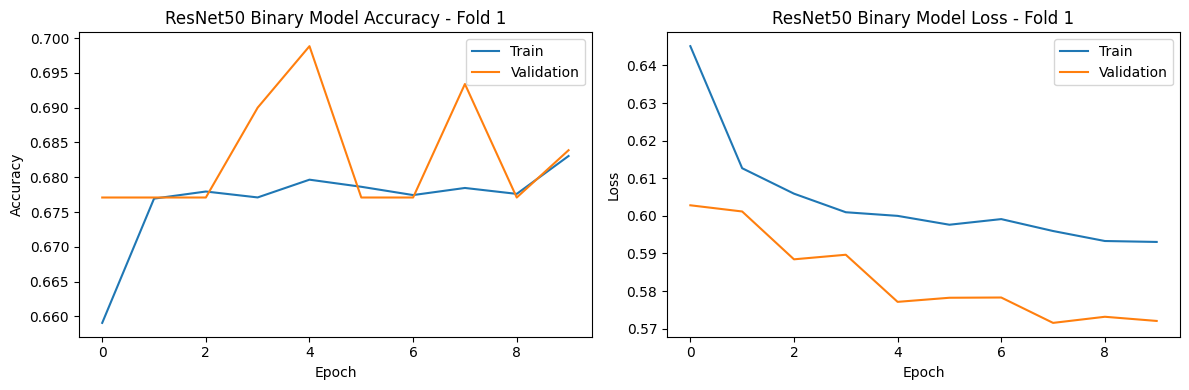

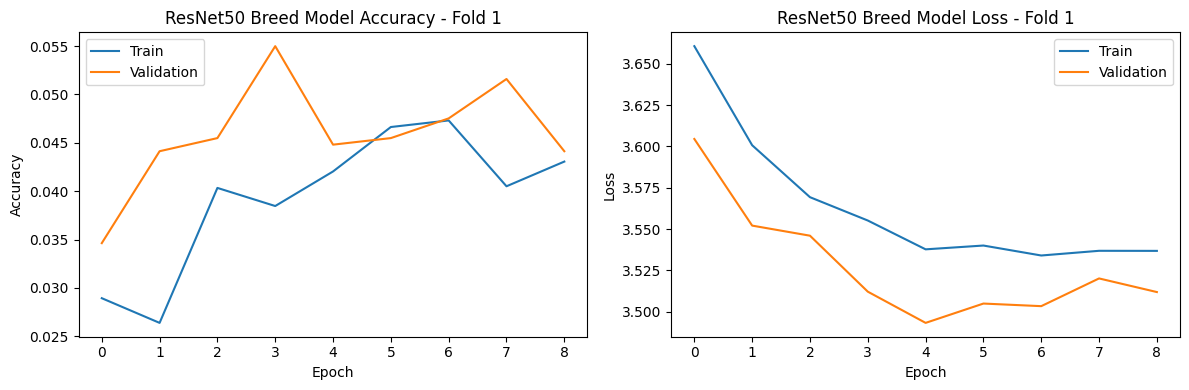


Processing fold 2/5
Found 5879 images belonging to 2 classes.
Found 1470 images belonging to 2 classes.
Found 5878 images belonging to 37 classes.
Found 1471 images belonging to 37 classes.

Training ResNet50 models for fold 2/5

Training binary classification model...

Creating ResNet50 model for binary classification...
Epoch 1/15
183/184 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - AUC: 0.5361 - Precision: 0.6828 - Recall: 0.9124 - accuracy: 0.6521 - loss: 0.6629
Epoch 1: val_accuracy improved from -inf to 0.67755, saving model to /content/oxford_pets_project/models/checkpoints/resnet50_binary_fold_1.keras
184/184 ━━━━━━━━━━━━━━━━━━━━ 105s 496ms/step - AUC: 0.5361 - Precision: 0.6828 - Recall: 0.9128 - accuracy: 0.6522 - loss: 0.6627 - val_AUC: 0.6966 - val_Precision: 0.6776 - val_Recall: 1.0000 - val_accuracy: 0.6776 - val_loss: 0.6118
Epoch 2/15
183/184 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - AUC: 0.5813 - Precision: 0.6785 - Recall: 0.9881 - accuracy: 0.6753 - loss: 0.6223
Epoch 2: val_acc

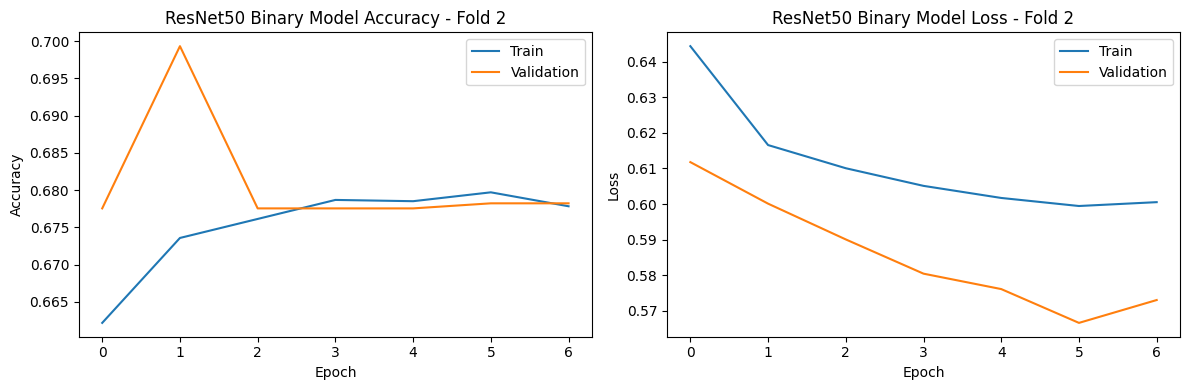

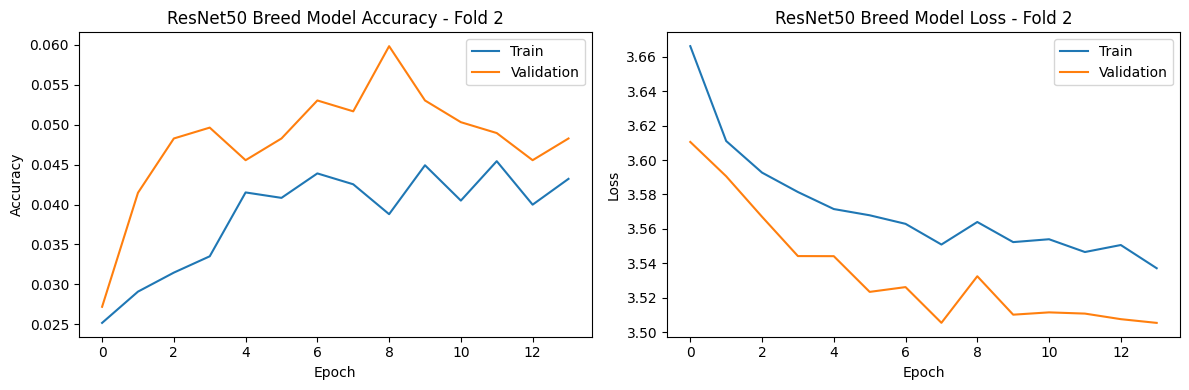


Processing fold 3/5
Found 5879 images belonging to 2 classes.
Found 1470 images belonging to 2 classes.
Found 5878 images belonging to 37 classes.
Found 1471 images belonging to 37 classes.

Training ResNet50 models for fold 3/5

Training binary classification model...

Creating ResNet50 model for binary classification...
Epoch 1/15
183/184 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - AUC: 0.5541 - Precision: 0.6900 - Recall: 0.9092 - accuracy: 0.6592 - loss: 0.6504
Epoch 1: val_accuracy improved from -inf to 0.67755, saving model to /content/oxford_pets_project/models/checkpoints/resnet50_binary_fold_2.keras
184/184 ━━━━━━━━━━━━━━━━━━━━ 98s 455ms/step - AUC: 0.5541 - Precision: 0.6899 - Recall: 0.9095 - accuracy: 0.6592 - loss: 0.6503 - val_AUC: 0.6606 - val_Precision: 0.6776 - val_Recall: 1.0000 - val_accuracy: 0.6776 - val_loss: 0.6048
Epoch 2/15
183/184 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - AUC: 0.6137 - Precision: 0.6842 - Recall: 0.9665 - accuracy: 0.6764 - loss: 0.6114
Epoch 2: val_accu

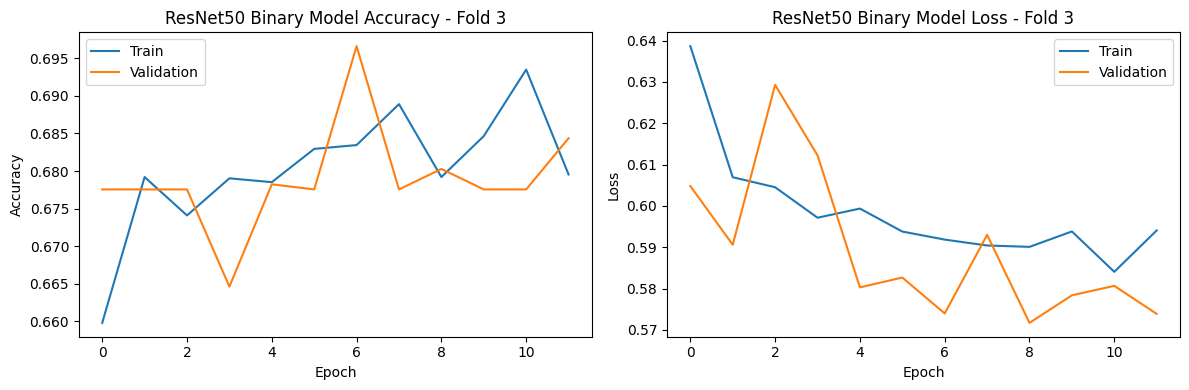

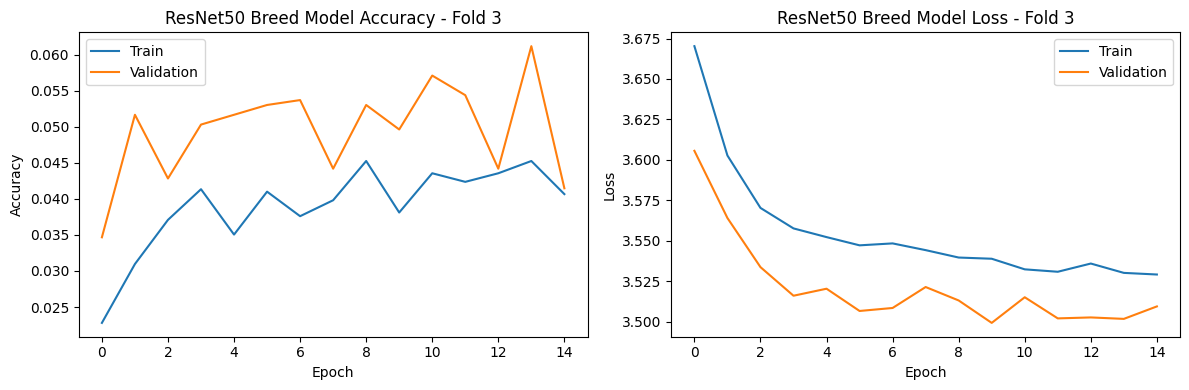


Processing fold 4/5
Found 5880 images belonging to 2 classes.
Found 1469 images belonging to 2 classes.
Found 5879 images belonging to 37 classes.
Found 1470 images belonging to 37 classes.

Training ResNet50 models for fold 4/5

Training binary classification model...

Creating ResNet50 model for binary classification...
Epoch 1/15
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - AUC: 0.5393 - Precision: 0.6806 - Recall: 0.8835 - accuracy: 0.6465 - loss: 0.6755
Epoch 1: val_accuracy improved from -inf to 0.67733, saving model to /content/oxford_pets_project/models/checkpoints/resnet50_binary_fold_3.keras
184/184 ━━━━━━━━━━━━━━━━━━━━ 106s 497ms/step - AUC: 0.5394 - Precision: 0.6806 - Recall: 0.8837 - accuracy: 0.6466 - loss: 0.6753 - val_AUC: 0.6775 - val_Precision: 0.6773 - val_Recall: 1.0000 - val_accuracy: 0.6773 - val_loss: 0.5958
Epoch 2/15
183/184 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - AUC: 0.6030 - Precision: 0.6888 - Recall: 0.9654 - accuracy: 0.6778 - loss: 0.6111
Epoch 2: val_acc

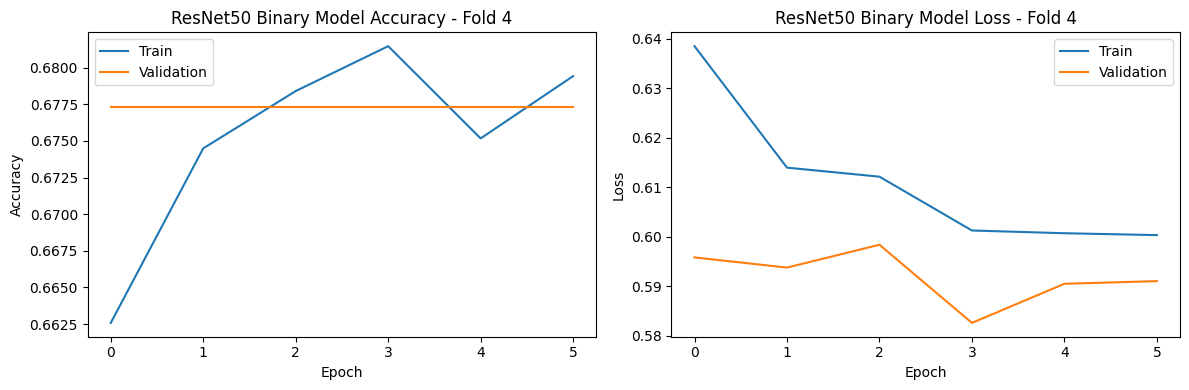

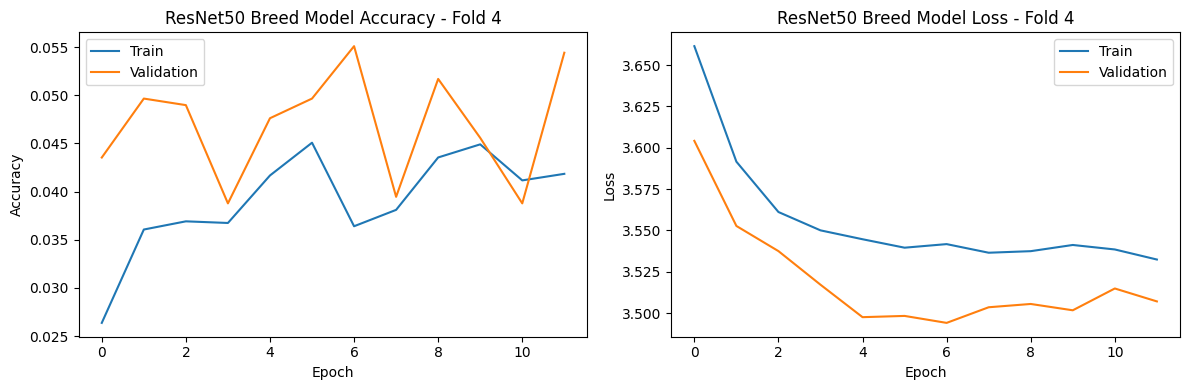


Processing fold 5/5
Found 5880 images belonging to 2 classes.
Found 1469 images belonging to 2 classes.
Found 5885 images belonging to 37 classes.
Found 1464 images belonging to 37 classes.

Training ResNet50 models for fold 5/5

Training binary classification model...

Creating ResNet50 model for binary classification...
Epoch 1/15
183/184 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - AUC: 0.5194 - Precision: 0.6897 - Recall: 0.8953 - accuracy: 0.6503 - loss: 0.6784
Epoch 1: val_accuracy improved from -inf to 0.67733, saving model to /content/oxford_pets_project/models/checkpoints/resnet50_binary_fold_4.keras
184/184 ━━━━━━━━━━━━━━━━━━━━ 97s 452ms/step - AUC: 0.5196 - Precision: 0.6895 - Recall: 0.8959 - accuracy: 0.6505 - loss: 0.6781 - val_AUC: 0.7072 - val_Precision: 0.6773 - val_Recall: 1.0000 - val_accuracy: 0.6773 - val_loss: 0.6037
Epoch 2/15
183/184 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - AUC: 0.6211 - Precision: 0.6900 - Recall: 0.9839 - accuracy: 0.6859 - loss: 0.6020
Epoch 2: val_accu

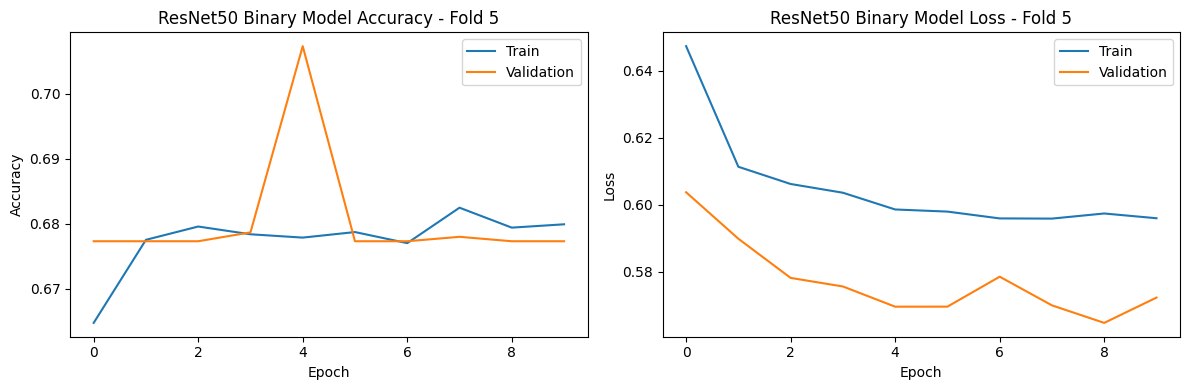

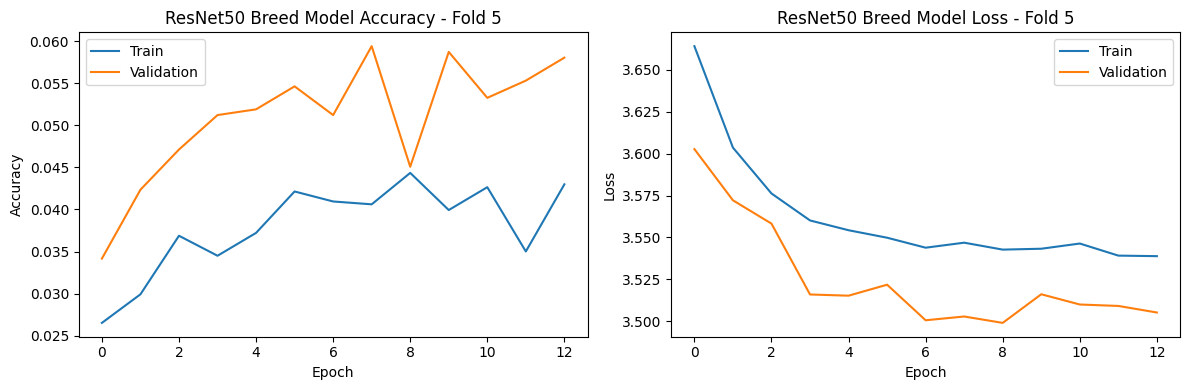


ResNet50 training completed!


In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
import os

def create_callbacks(model_name, fold):
    """
    Create callbacks for model training
    """
    # Create checkpoints directory if it doesn't exist
    os.makedirs(os.path.join(BASE_PATH, 'models/checkpoints'), exist_ok=True)

    callbacks = [
        ModelCheckpoint(
            filepath=os.path.join(BASE_PATH, f'models/checkpoints/{model_name}_fold_{fold}.keras'),
            monitor='val_accuracy',
            mode='max',
            save_best_only=True,
            verbose=1
        ),
        EarlyStopping(
            monitor='val_accuracy',
            patience=5,
            restore_best_weights=True,
            verbose=1
        )
    ]
    return callbacks

def train_resnet50_fold(fold, data_generators):
    """
    Train ResNet50 models for a specific fold
    """
    print(f"\nTraining ResNet50 models for fold {fold+1}/5")

    # Get data generators for this fold
    binary_train = data_generators['binary']['train']
    binary_val = data_generators['binary']['val']
    breed_train = data_generators['breed']['train']
    breed_val = data_generators['breed']['val']

    # Train binary classification model
    print("\nTraining binary classification model...")
    binary_model = create_resnet50_binary()
    binary_callbacks = create_callbacks('resnet50_binary', fold)

    binary_history = binary_model.fit(
        binary_train,
        validation_data=binary_val,
        epochs=15,
        callbacks=binary_callbacks,
        verbose=1
    )

    # Train breed classification model
    print("\nTraining breed classification model...")
    breed_model = create_resnet50_breed()
    breed_callbacks = create_callbacks('resnet50_breed', fold)

    breed_history = breed_model.fit(
        breed_train,
        validation_data=breed_val,
        epochs=15,
        callbacks=breed_callbacks,
        verbose=1
    )

    return binary_history, breed_history

def plot_training_history(history, model_type, fold):
    """
    Plot training history for a model
    """
    plt.figure(figsize=(12, 4))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'ResNet50 {model_type} Model Accuracy - Fold {fold+1}')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'ResNet50 {model_type} Model Loss - Fold {fold+1}')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])

    plt.tight_layout()
    plt.savefig(os.path.join(BASE_PATH, f'results/plots/resnet50_{model_type.lower()}_fold_{fold+1}_history.png'))
    plt.show()

def save_training_history(history, model_type, fold):
    """
    Save training history to file
    """
    history_path = os.path.join(BASE_PATH, f'results/metrics/resnet50_{model_type.lower()}_fold_{fold}_history.npy')
    np.save(history_path, history.history)

# Main training execution
print("Starting ResNet50 training...")

# Train models for each fold
for fold in range(N_FOLDS):
    print(f"\nProcessing fold {fold+1}/{N_FOLDS}")

    # Create data generators for this fold
    train_datagen, valid_datagen = create_data_generators()

    # Get fold data
    fold_generators = {
        'binary': {
            'train': train_datagen.flow_from_directory(
                os.path.join(BASE_PATH, f'data/kfold/fold_{fold}/binary/train'),
                target_size=(224, 224),
                batch_size=32,
                class_mode='binary'
            ),
            'val': valid_datagen.flow_from_directory(
                os.path.join(BASE_PATH, f'data/kfold/fold_{fold}/binary/val'),
                target_size=(224, 224),
                batch_size=32,
                class_mode='binary'
            )
        },
        'breed': {
            'train': train_datagen.flow_from_directory(
                os.path.join(BASE_PATH, f'data/kfold/fold_{fold}/breeds/train'),
                target_size=(224, 224),
                batch_size=32,
                class_mode='categorical'
            ),
            'val': valid_datagen.flow_from_directory(
                os.path.join(BASE_PATH, f'data/kfold/fold_{fold}/breeds/val'),
                target_size=(224, 224),
                batch_size=32,
                class_mode='categorical'
            )
        }
    }

    # Train models for this fold
    binary_history, breed_history = train_resnet50_fold(fold, fold_generators)

    # Plot and save training histories
    plot_training_history(binary_history, 'Binary', fold)
    plot_training_history(breed_history, 'Breed', fold)

    save_training_history(binary_history, 'binary', fold)
    save_training_history(breed_history, 'breed', fold)

print("\nResNet50 training completed!")

#Step 10: Training and Validation - VGG16

Binary classification training with K-fold,

Multi-class classification training with K-fold,

Model checkpointing,

Training history logging,

visualize each fold model acccuracy and loss

Starting VGG16 training...

Processing fold 1/5
Found 5878 images belonging to 2 classes.
Found 1471 images belonging to 2 classes.
Found 5876 images belonging to 37 classes.
Found 1473 images belonging to 37 classes.

Training VGG16 models for fold 1/5

Training binary classification model...

Creating VGG16 model for binary classification...
Epoch 1/15
183/184 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - AUC: 0.7480 - Precision: 0.7635 - Recall: 0.8907 - accuracy: 0.7378 - loss: 0.5332
Epoch 1: val_accuracy improved from -inf to 0.89123, saving model to /content/oxford_pets_project/models/checkpoints/vgg16_binary_fold_0.keras
184/184 ━━━━━━━━━━━━━━━━━━━━ 97s 465ms/step - AUC: 0.7490 - Precision: 0.7640 - Recall: 0.8908 - accuracy: 0.7382 - loss: 0.5323 - val_AUC: 0.9557 - val_Precision: 0.8842 - val_Recall: 0.9659 - val_accuracy: 0.8912 - val_loss: 0.2689
Epoch 2/15
183/184 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - AUC: 0.9243 - Precision: 0.8853 - Recall: 0.9055 - accuracy: 0.8564 - loss: 0.3231

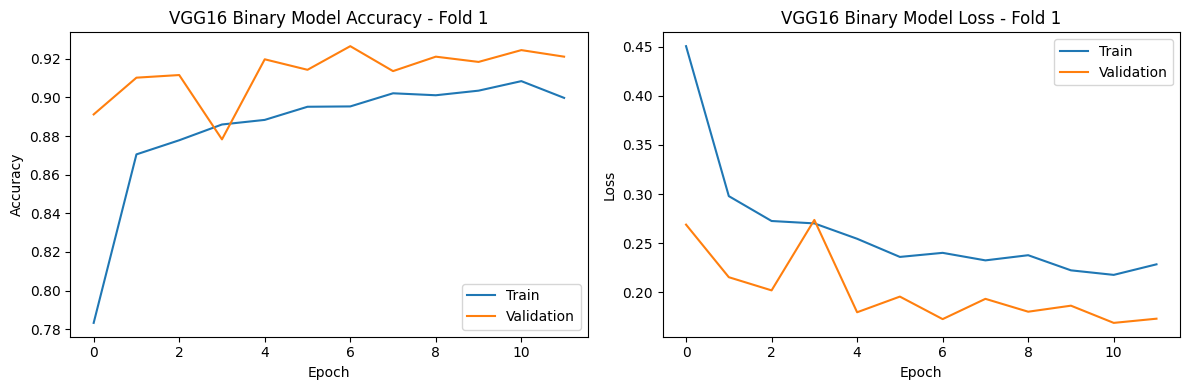

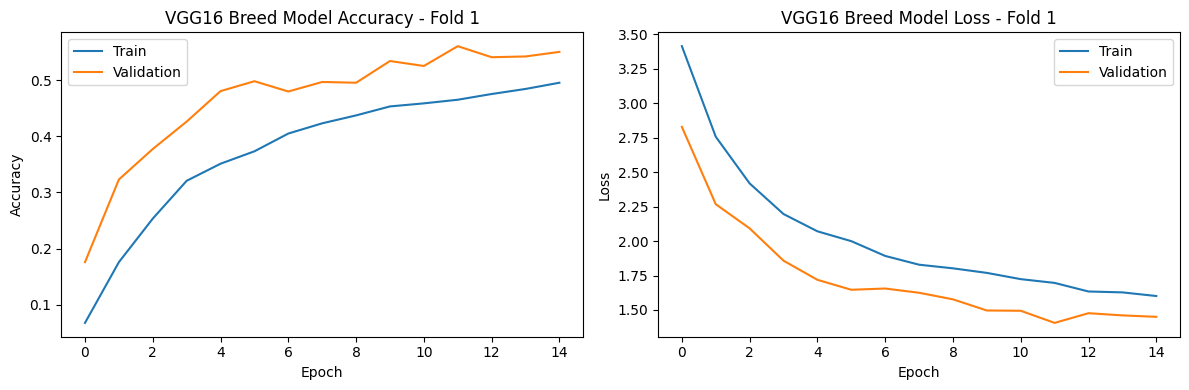


Processing fold 2/5
Found 5879 images belonging to 2 classes.
Found 1470 images belonging to 2 classes.
Found 5878 images belonging to 37 classes.
Found 1471 images belonging to 37 classes.

Training VGG16 models for fold 2/5

Training binary classification model...

Creating VGG16 model for binary classification...
Epoch 1/15
183/184 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - AUC: 0.7477 - Precision: 0.7608 - Recall: 0.8950 - accuracy: 0.7362 - loss: 0.5220
Epoch 1: val_accuracy improved from -inf to 0.90612, saving model to /content/oxford_pets_project/models/checkpoints/vgg16_binary_fold_1.keras
184/184 ━━━━━━━━━━━━━━━━━━━━ 92s 462ms/step - AUC: 0.7488 - Precision: 0.7614 - Recall: 0.8951 - accuracy: 0.7368 - loss: 0.5210 - val_AUC: 0.9585 - val_Precision: 0.9078 - val_Recall: 0.9588 - val_accuracy: 0.9061 - val_loss: 0.2519
Epoch 2/15
183/184 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - AUC: 0.9374 - Precision: 0.8889 - Recall: 0.9369 - accuracy: 0.8763 - loss: 0.2915
Epoch 2: val_accuracy impr

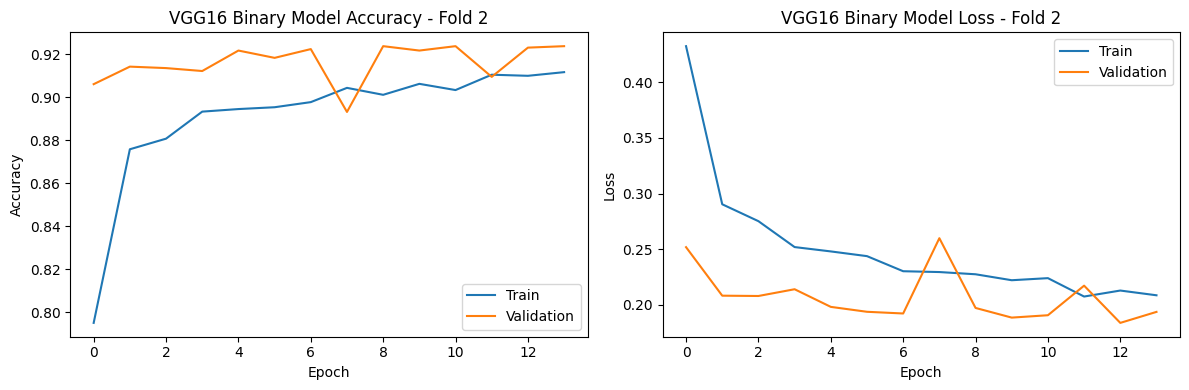

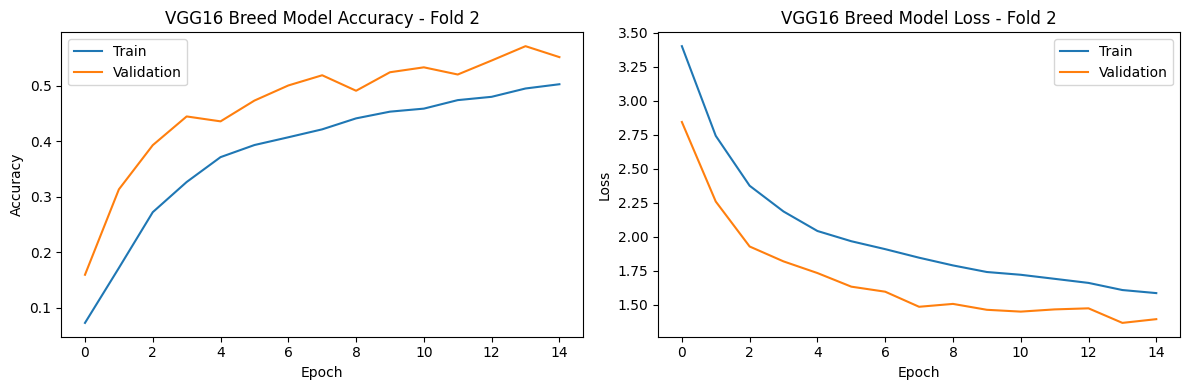


Processing fold 3/5
Found 5879 images belonging to 2 classes.
Found 1470 images belonging to 2 classes.
Found 5878 images belonging to 37 classes.
Found 1471 images belonging to 37 classes.

Training VGG16 models for fold 3/5

Training binary classification model...

Creating VGG16 model for binary classification...
Epoch 1/15
183/184 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - AUC: 0.7242 - Precision: 0.7499 - Recall: 0.8955 - accuracy: 0.7247 - loss: 0.5403
Epoch 1: val_accuracy improved from -inf to 0.88231, saving model to /content/oxford_pets_project/models/checkpoints/vgg16_binary_fold_2.keras
184/184 ━━━━━━━━━━━━━━━━━━━━ 85s 422ms/step - AUC: 0.7255 - Precision: 0.7505 - Recall: 0.8956 - accuracy: 0.7254 - loss: 0.5392 - val_AUC: 0.9613 - val_Precision: 0.8619 - val_Recall: 0.9839 - val_accuracy: 0.8823 - val_loss: 0.2731
Epoch 2/15
183/184 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - AUC: 0.9265 - Precision: 0.8836 - Recall: 0.9124 - accuracy: 0.8587 - loss: 0.3169
Epoch 2: val_accuracy impr

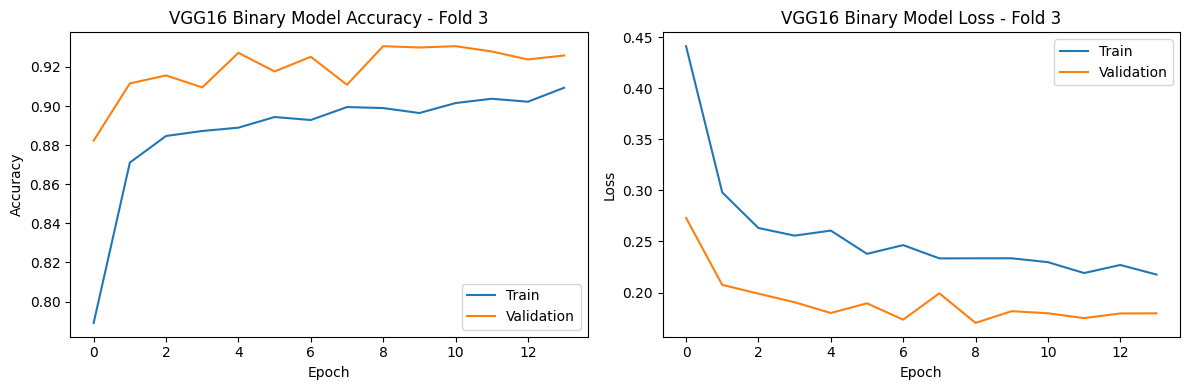

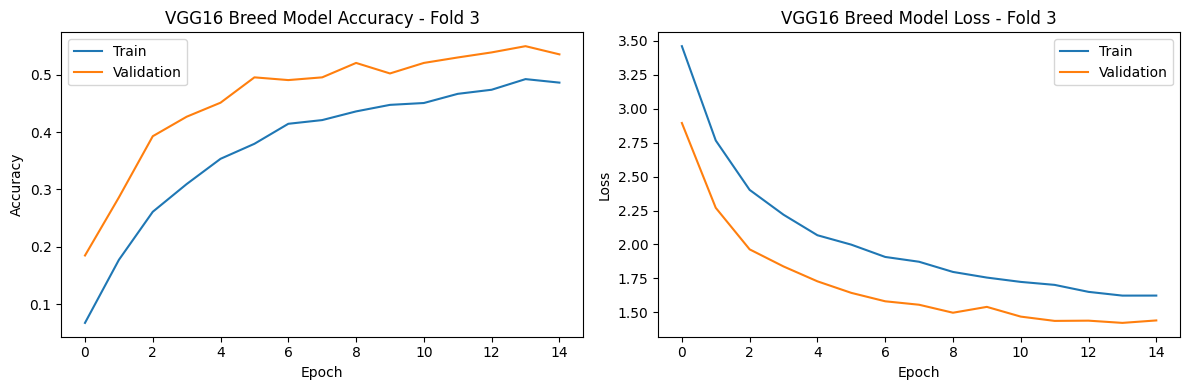


Processing fold 4/5
Found 5880 images belonging to 2 classes.
Found 1469 images belonging to 2 classes.
Found 5879 images belonging to 37 classes.
Found 1470 images belonging to 37 classes.

Training VGG16 models for fold 4/5

Training binary classification model...

Creating VGG16 model for binary classification...
Epoch 1/15
183/184 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - AUC: 0.7359 - Precision: 0.7431 - Recall: 0.9000 - accuracy: 0.7217 - loss: 0.5352
Epoch 1: val_accuracy improved from -inf to 0.90946, saving model to /content/oxford_pets_project/models/checkpoints/vgg16_binary_fold_3.keras
184/184 ━━━━━━━━━━━━━━━━━━━━ 91s 460ms/step - AUC: 0.7371 - Precision: 0.7437 - Recall: 0.9000 - accuracy: 0.7224 - loss: 0.5342 - val_AUC: 0.9663 - val_Precision: 0.9250 - val_Recall: 0.9427 - val_accuracy: 0.9095 - val_loss: 0.2256
Epoch 2/15
183/184 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - AUC: 0.9207 - Precision: 0.8821 - Recall: 0.9213 - accuracy: 0.8613 - loss: 0.3228
Epoch 2: val_accuracy did 

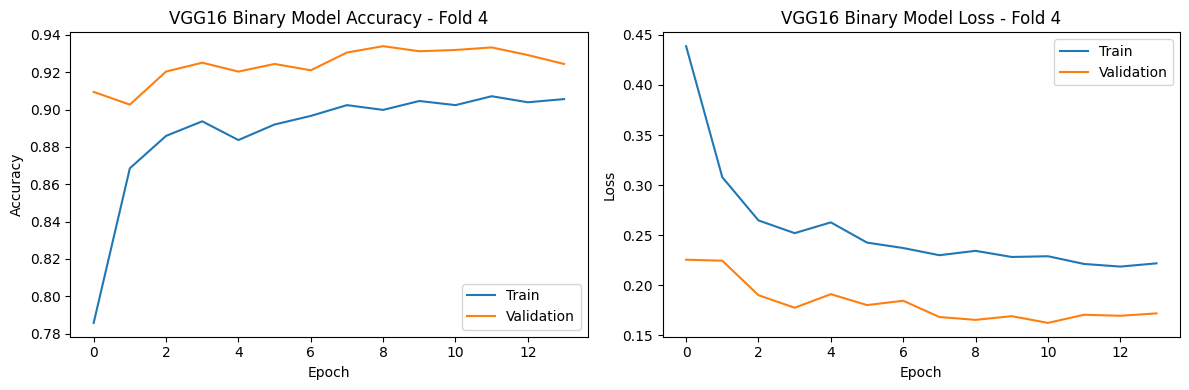

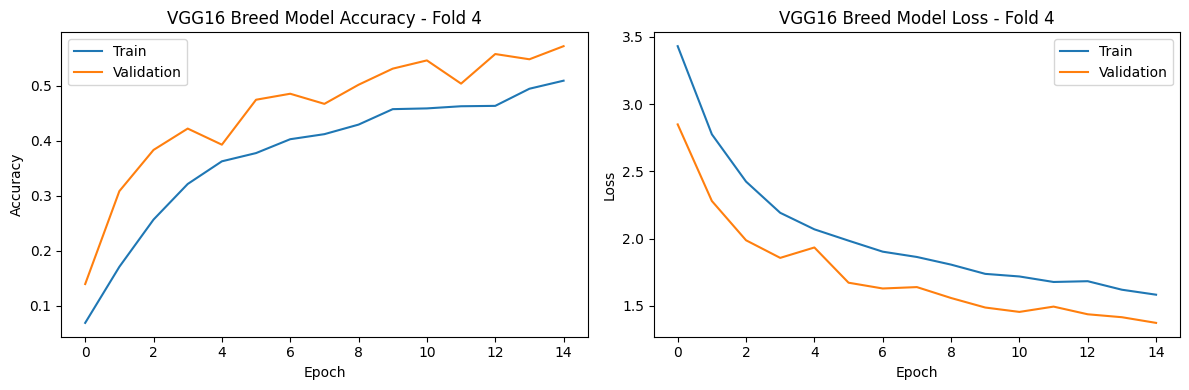


Processing fold 5/5
Found 5880 images belonging to 2 classes.
Found 1469 images belonging to 2 classes.
Found 5885 images belonging to 37 classes.
Found 1464 images belonging to 37 classes.

Training VGG16 models for fold 5/5

Training binary classification model...

Creating VGG16 model for binary classification...
Epoch 1/15
183/184 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - AUC: 0.7446 - Precision: 0.7515 - Recall: 0.8913 - accuracy: 0.7270 - loss: 0.5301
Epoch 1: val_accuracy improved from -inf to 0.90334, saving model to /content/oxford_pets_project/models/checkpoints/vgg16_binary_fold_4.keras
184/184 ━━━━━━━━━━━━━━━━━━━━ 86s 420ms/step - AUC: 0.7458 - Precision: 0.7521 - Recall: 0.8915 - accuracy: 0.7277 - loss: 0.5290 - val_AUC: 0.9684 - val_Precision: 0.9475 - val_Recall: 0.9075 - val_accuracy: 0.9033 - val_loss: 0.2326
Epoch 2/15
183/184 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - AUC: 0.9277 - Precision: 0.8784 - Recall: 0.9228 - accuracy: 0.8626 - loss: 0.3142
Epoch 2: val_accuracy impr

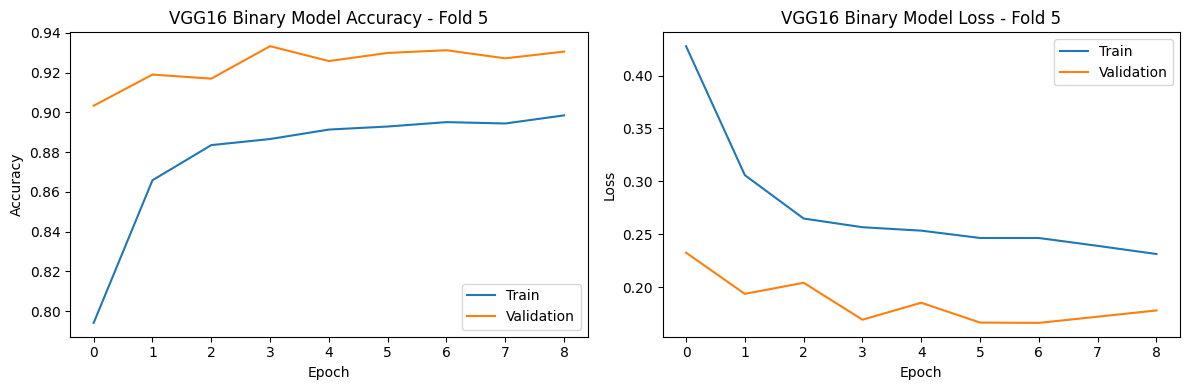

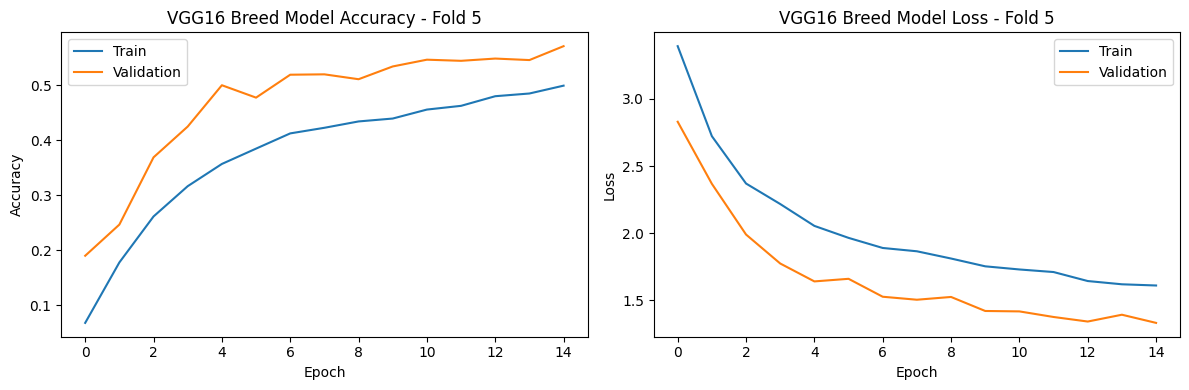


VGG16 training completed!


In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
import os

def create_vgg_callbacks(model_name, fold):
    """
    Create callbacks for VGG16 model training
    """
    # Create checkpoints directory if it doesn't exist
    os.makedirs(os.path.join(BASE_PATH, 'models/checkpoints'), exist_ok=True)

    callbacks = [
        ModelCheckpoint(
            filepath=os.path.join(BASE_PATH, f'models/checkpoints/{model_name}_fold_{fold}.keras'),
            monitor='val_accuracy',
            mode='max',
            save_best_only=True,
            verbose=1
        ),
        EarlyStopping(
            monitor='val_accuracy',
            patience=5,
            restore_best_weights=True,
            verbose=1
        )
    ]
    return callbacks

def train_vgg16_fold(fold, data_generators):
    """
    Train VGG16 models for a specific fold
    """
    print(f"\nTraining VGG16 models for fold {fold+1}/5")

    # Get data generators for this fold
    binary_train = data_generators['binary']['train']
    binary_val = data_generators['binary']['val']
    breed_train = data_generators['breed']['train']
    breed_val = data_generators['breed']['val']

    # Train binary classification model
    print("\nTraining binary classification model...")
    binary_model = create_vgg16_binary()
    binary_callbacks = create_vgg_callbacks('vgg16_binary', fold)

    binary_history = binary_model.fit(
        binary_train,
        validation_data=binary_val,
        epochs=15,
        callbacks=binary_callbacks,
        verbose=1
    )

    # Train breed classification model
    print("\nTraining breed classification model...")
    breed_model = create_vgg16_breed()
    breed_callbacks = create_vgg_callbacks('vgg16_breed', fold)

    breed_history = breed_model.fit(
        breed_train,
        validation_data=breed_val,
        epochs=15,
        callbacks=breed_callbacks,
        verbose=1
    )

    return binary_history, breed_history

def plot_vgg16_training_history(history, model_type, fold):
    """
    Plot training history for VGG16 model
    """
    plt.figure(figsize=(12, 4))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'VGG16 {model_type} Model Accuracy - Fold {fold+1}')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'VGG16 {model_type} Model Loss - Fold {fold+1}')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])

    plt.tight_layout()
    plt.savefig(os.path.join(BASE_PATH, f'results/plots/vgg16_{model_type.lower()}_fold_{fold+1}_history.png'))
    plt.show()

def save_vgg16_training_history(history, model_type, fold):
    """
    Save VGG16 training history to file
    """
    history_path = os.path.join(BASE_PATH, f'results/metrics/vgg16_{model_type.lower()}_fold_{fold}_history.npy')
    np.save(history_path, history.history)

# Main training execution
print("Starting VGG16 training...")

# Train models for each fold
for fold in range(N_FOLDS):
    print(f"\nProcessing fold {fold+1}/{N_FOLDS}")

    # Create data generators for this fold
    train_datagen, valid_datagen = create_data_generators()

    # Get fold data
    fold_generators = {
        'binary': {
            'train': train_datagen.flow_from_directory(
                os.path.join(BASE_PATH, f'data/kfold/fold_{fold}/binary/train'),
                target_size=(224, 224),
                batch_size=32,
                class_mode='binary'
            ),
            'val': valid_datagen.flow_from_directory(
                os.path.join(BASE_PATH, f'data/kfold/fold_{fold}/binary/val'),
                target_size=(224, 224),
                batch_size=32,
                class_mode='binary'
            )
        },
        'breed': {
            'train': train_datagen.flow_from_directory(
                os.path.join(BASE_PATH, f'data/kfold/fold_{fold}/breeds/train'),
                target_size=(224, 224),
                batch_size=32,
                class_mode='categorical'
            ),
            'val': valid_datagen.flow_from_directory(
                os.path.join(BASE_PATH, f'data/kfold/fold_{fold}/breeds/val'),
                target_size=(224, 224),
                batch_size=32,
                class_mode='categorical'
            )
        }
    }

    # Train models for this fold
    binary_history, breed_history = train_vgg16_fold(fold, fold_generators)

    # Plot and save training histories
    plot_vgg16_training_history(binary_history, 'Binary', fold)
    plot_vgg16_training_history(breed_history, 'Breed', fold)

    save_vgg16_training_history(binary_history, 'binary', fold)
    save_vgg16_training_history(breed_history, 'breed', fold)

print("\nVGG16 training completed!")

#Step 11: Model Evaluation - ResNet50

Performance metrics calculation (Accuracy, Precision, Recall, F1)

Confusion matrix

ROC curves and AUC

Performance visualization

K-fold results analysis

Starting ResNet50 evaluation...

Evaluating fold 1/5
Found 1471 images belonging to 2 classes.
46/46 ━━━━━━━━━━━━━━━━━━━━ 11s 174ms/step


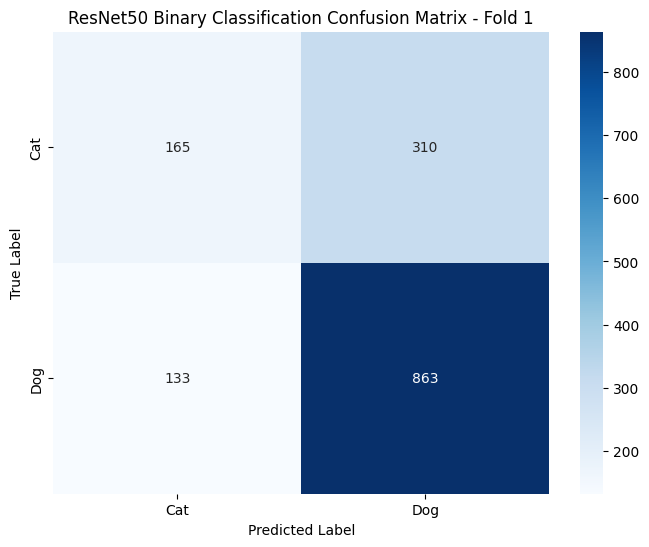

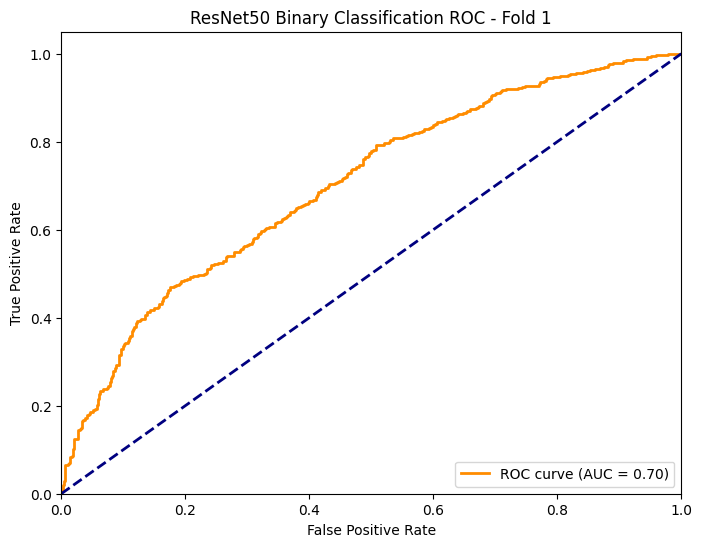

Found 1473 images belonging to 37 classes.
47/47 ━━━━━━━━━━━━━━━━━━━━ 12s 165ms/step


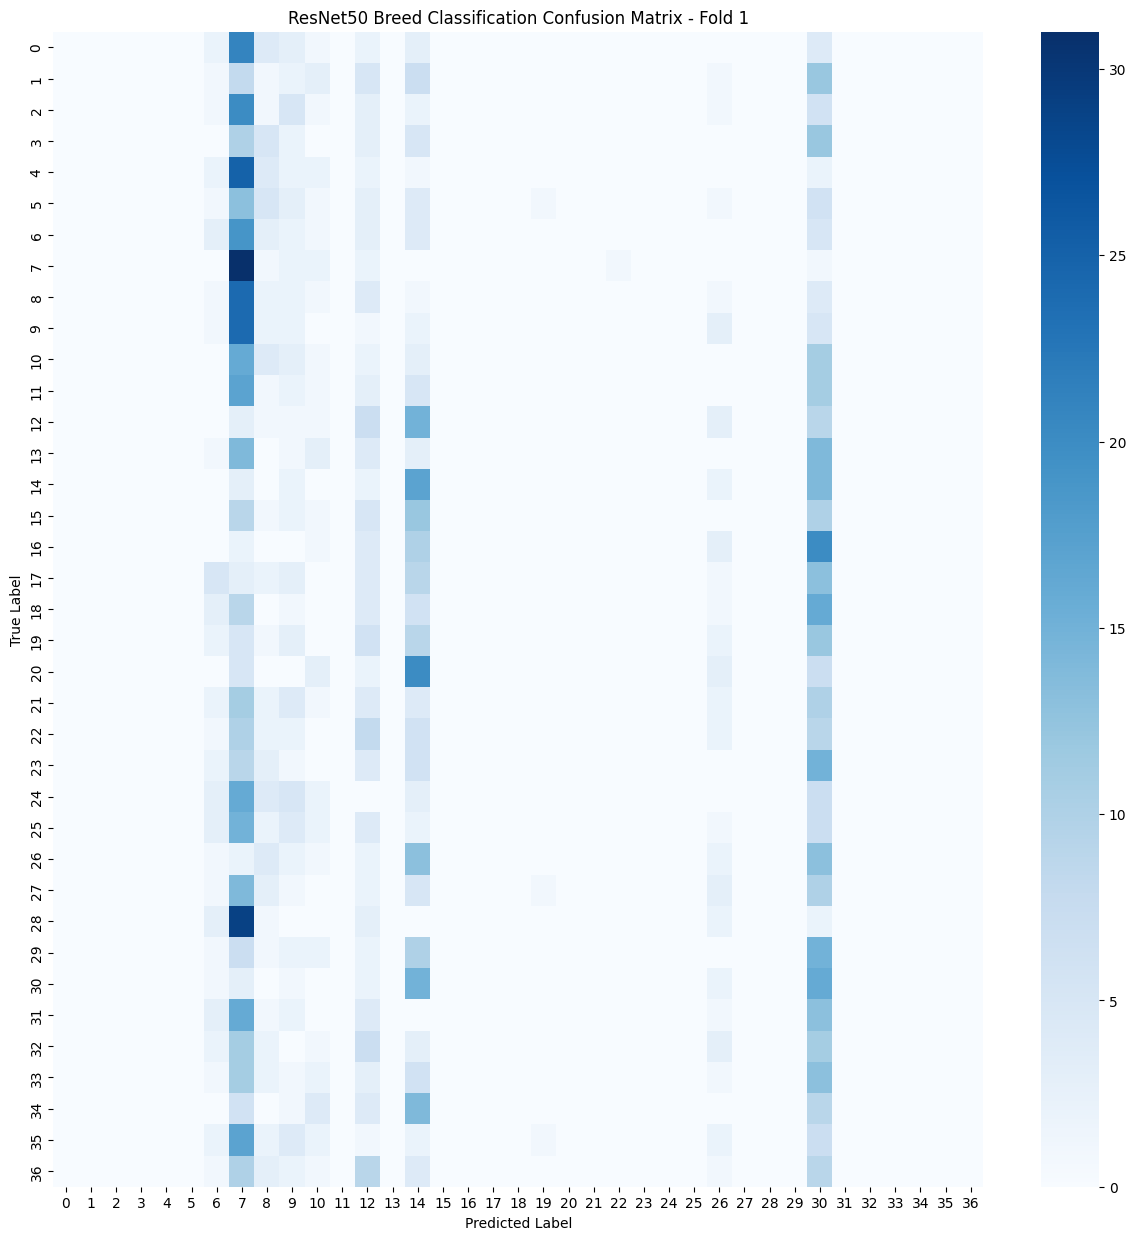

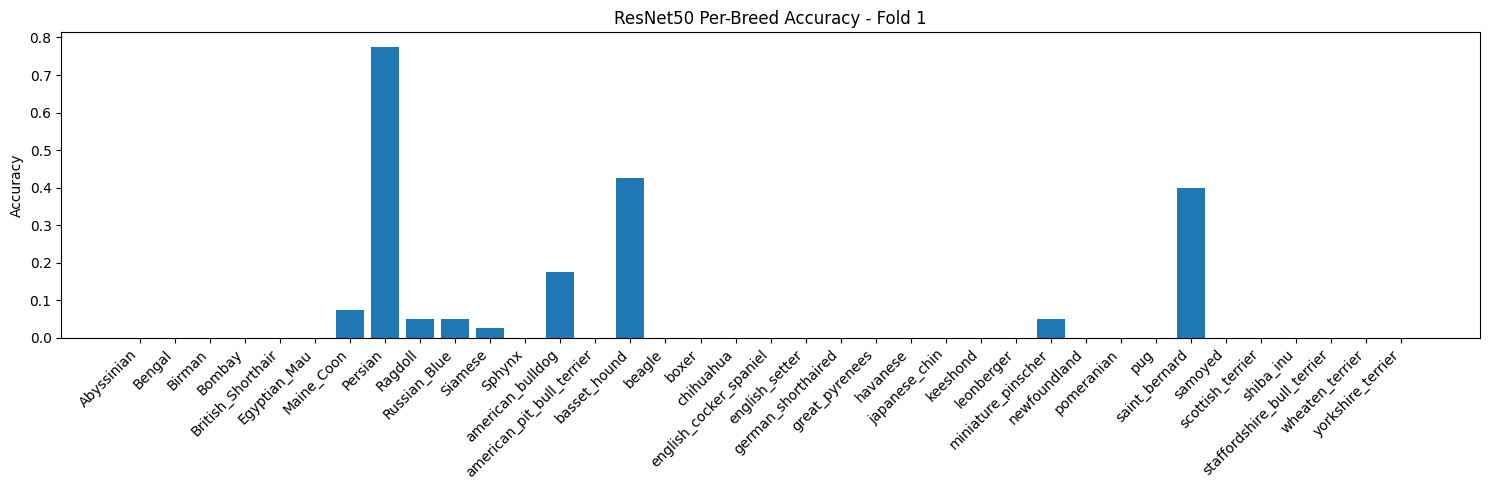

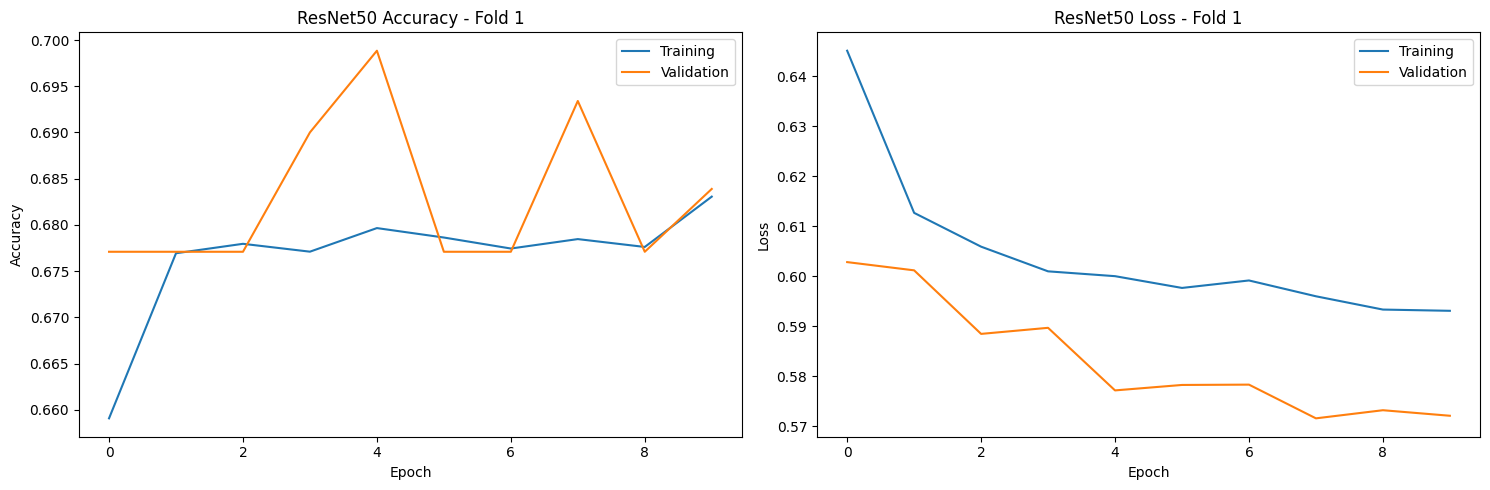


Evaluating fold 2/5
Found 1470 images belonging to 2 classes.
46/46 ━━━━━━━━━━━━━━━━━━━━ 11s 173ms/step


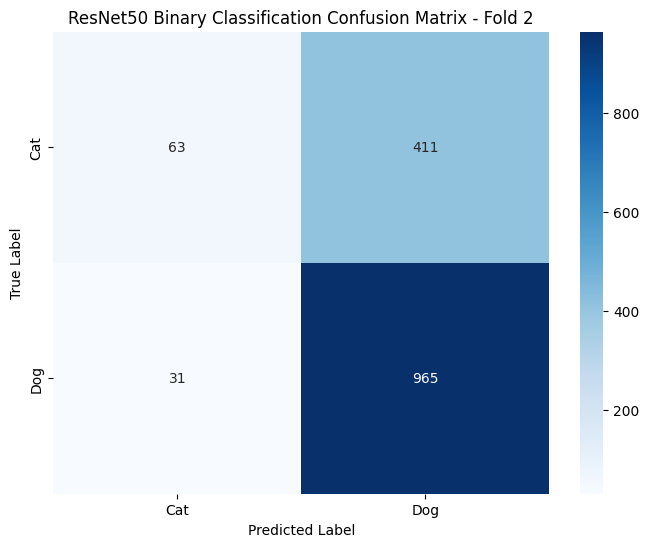

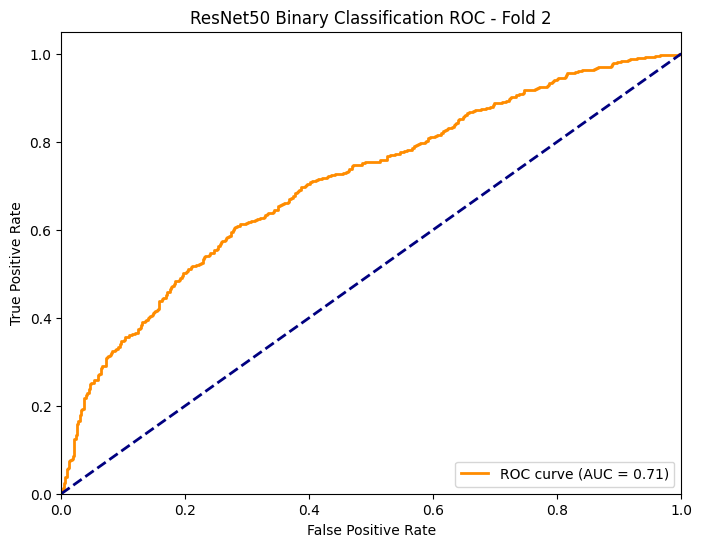

Found 1471 images belonging to 37 classes.
46/46 ━━━━━━━━━━━━━━━━━━━━ 12s 182ms/step


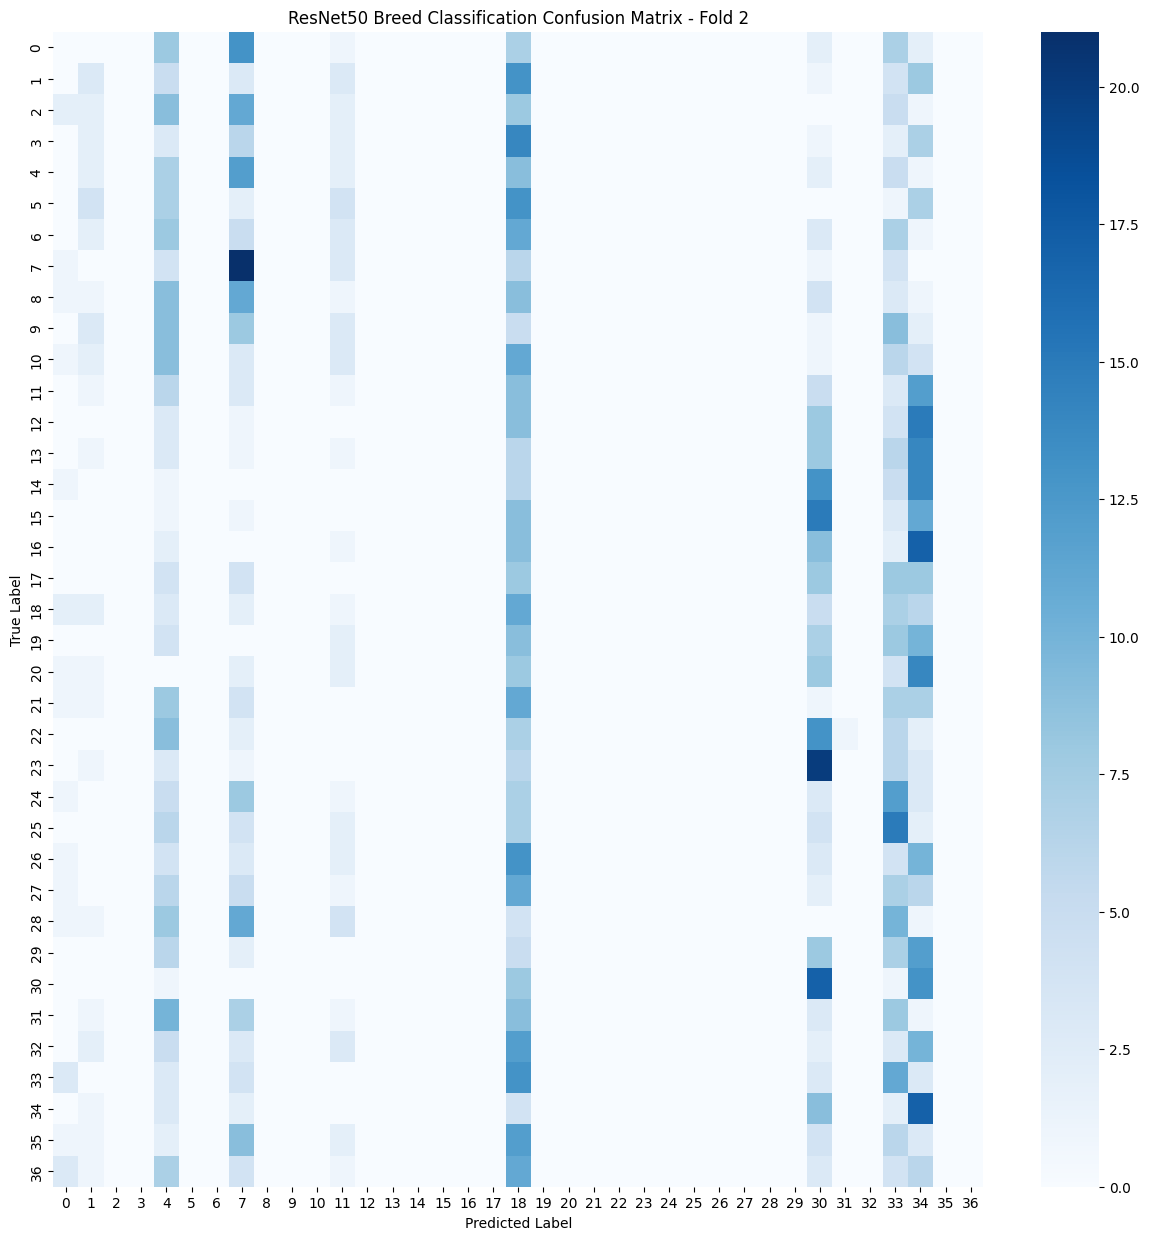

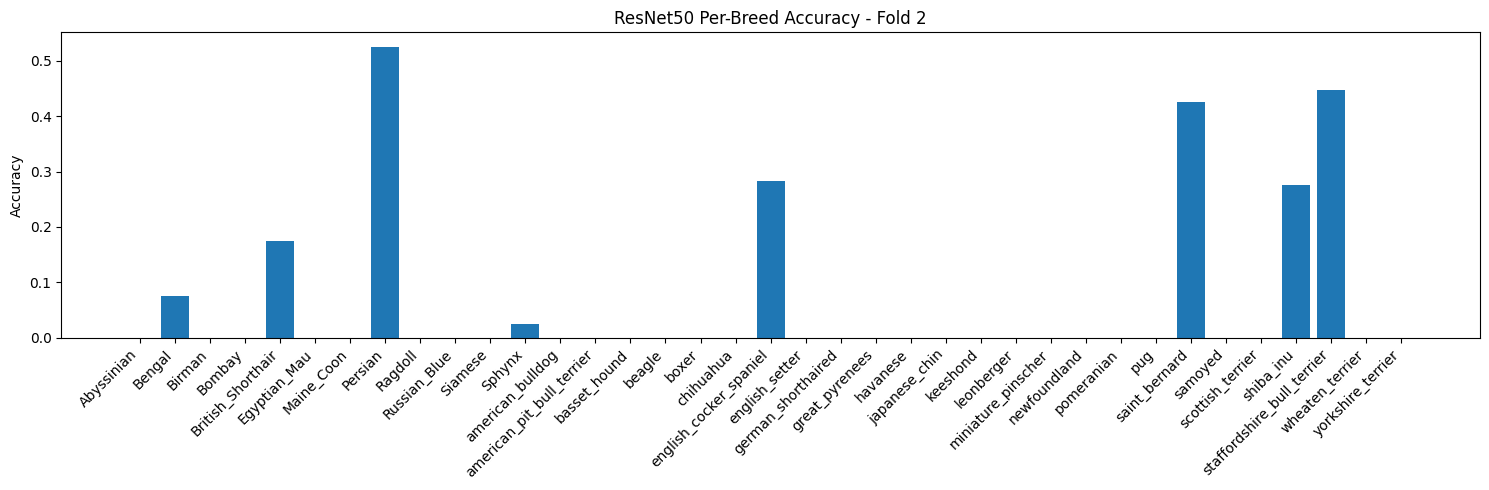

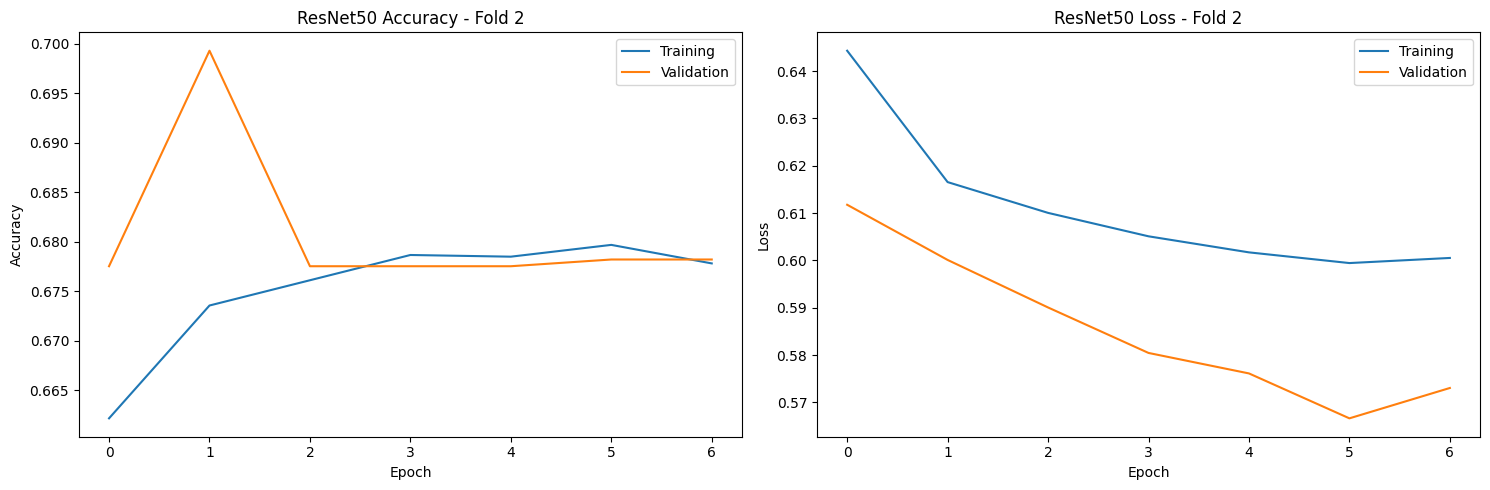


Evaluating fold 3/5
Found 1470 images belonging to 2 classes.
46/46 ━━━━━━━━━━━━━━━━━━━━ 11s 169ms/step


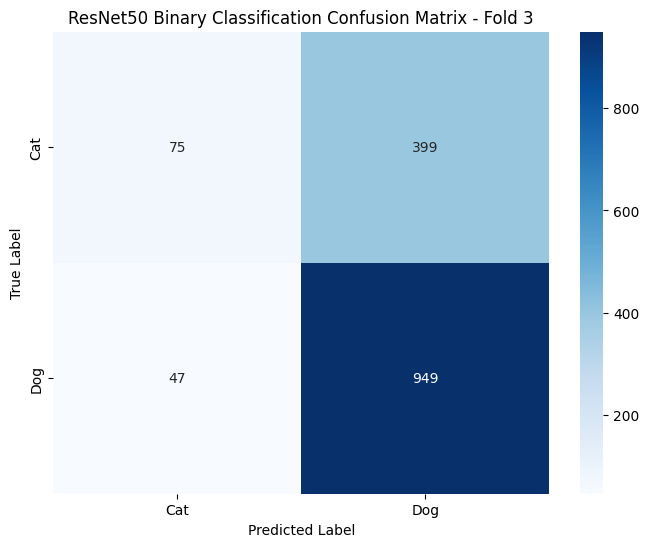

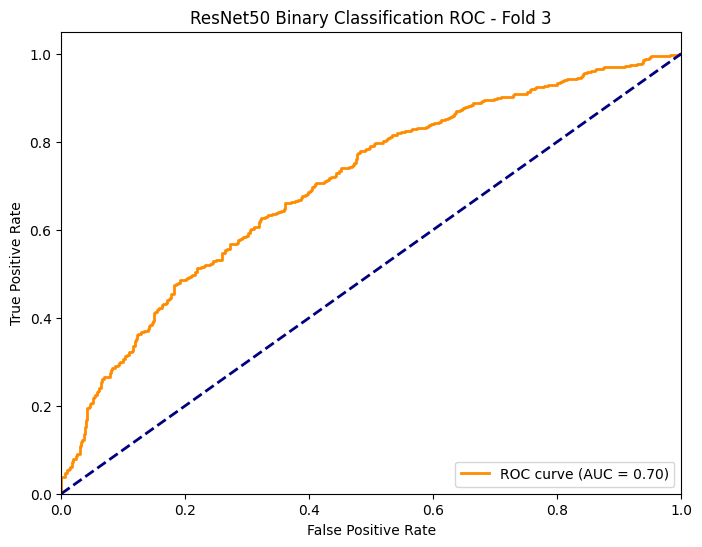

Found 1471 images belonging to 37 classes.
46/46 ━━━━━━━━━━━━━━━━━━━━ 12s 175ms/step


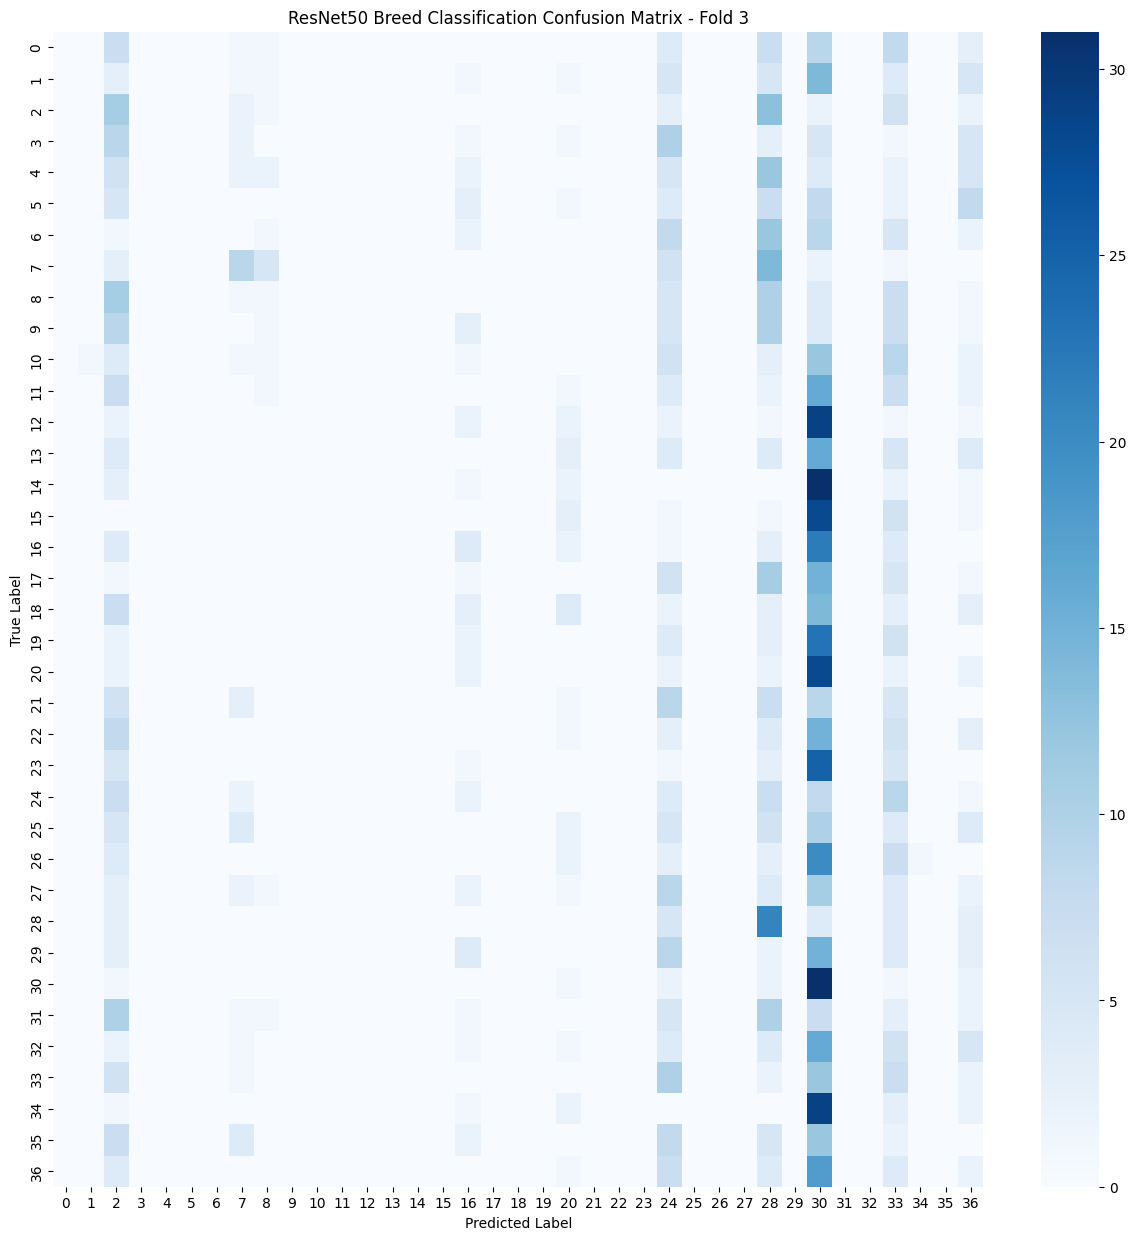

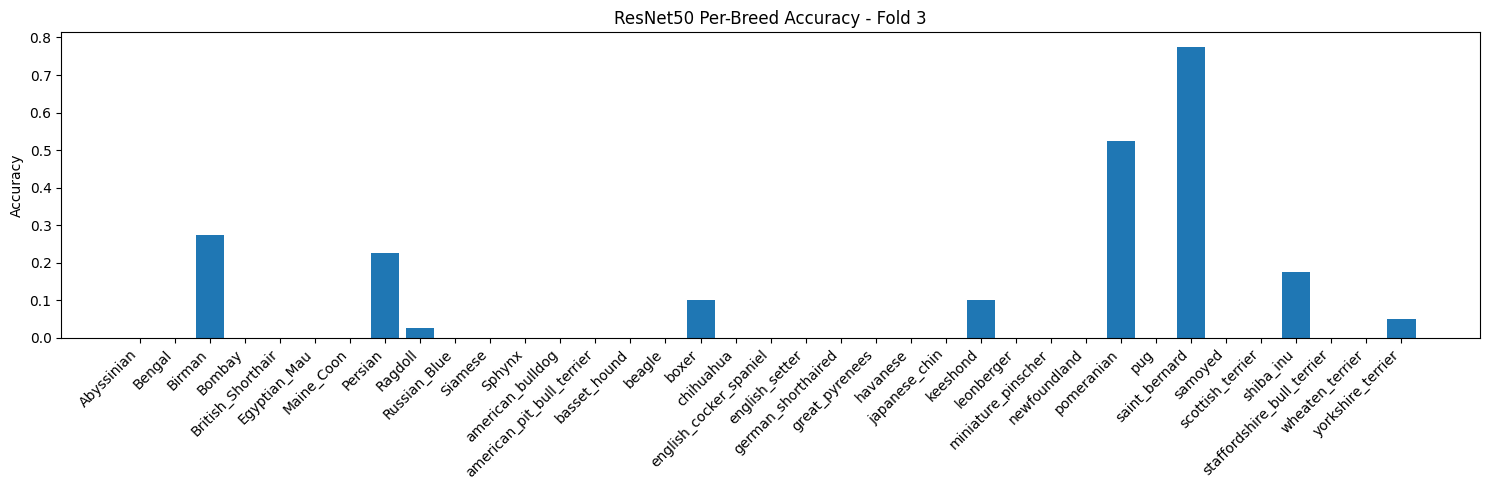

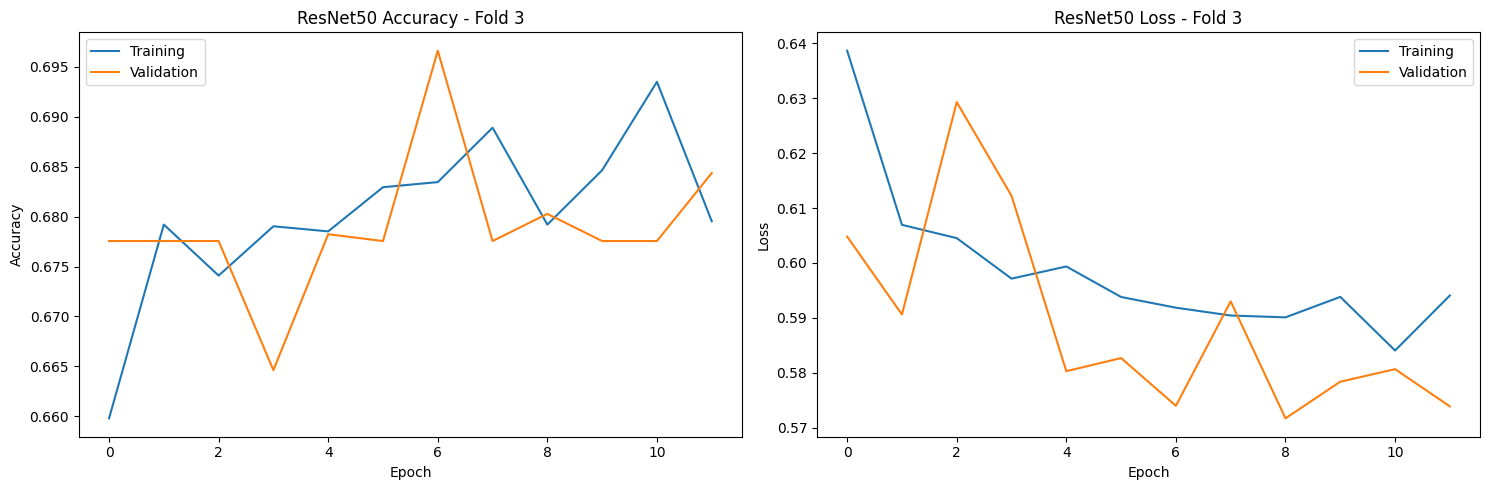


Evaluating fold 4/5
Found 1469 images belonging to 2 classes.
46/46 ━━━━━━━━━━━━━━━━━━━━ 11s 172ms/step


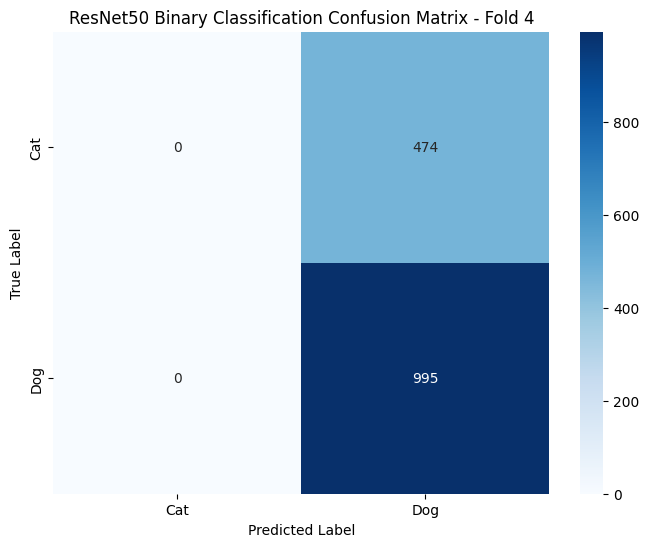

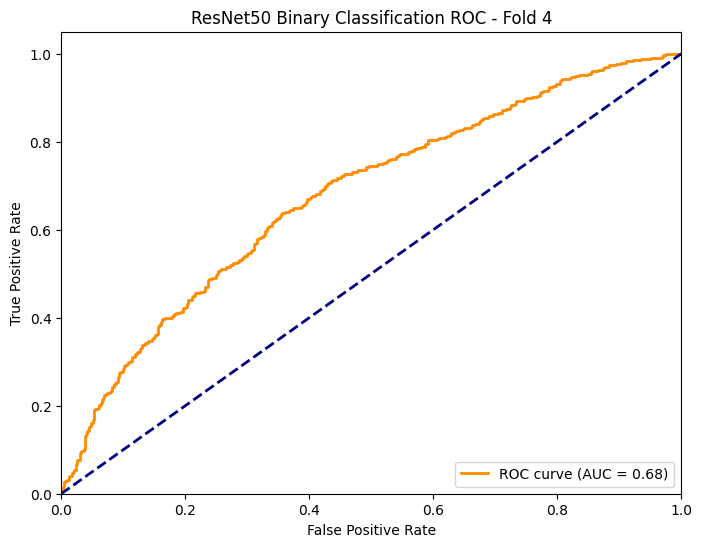

Found 1470 images belonging to 37 classes.
46/46 ━━━━━━━━━━━━━━━━━━━━ 12s 184ms/step


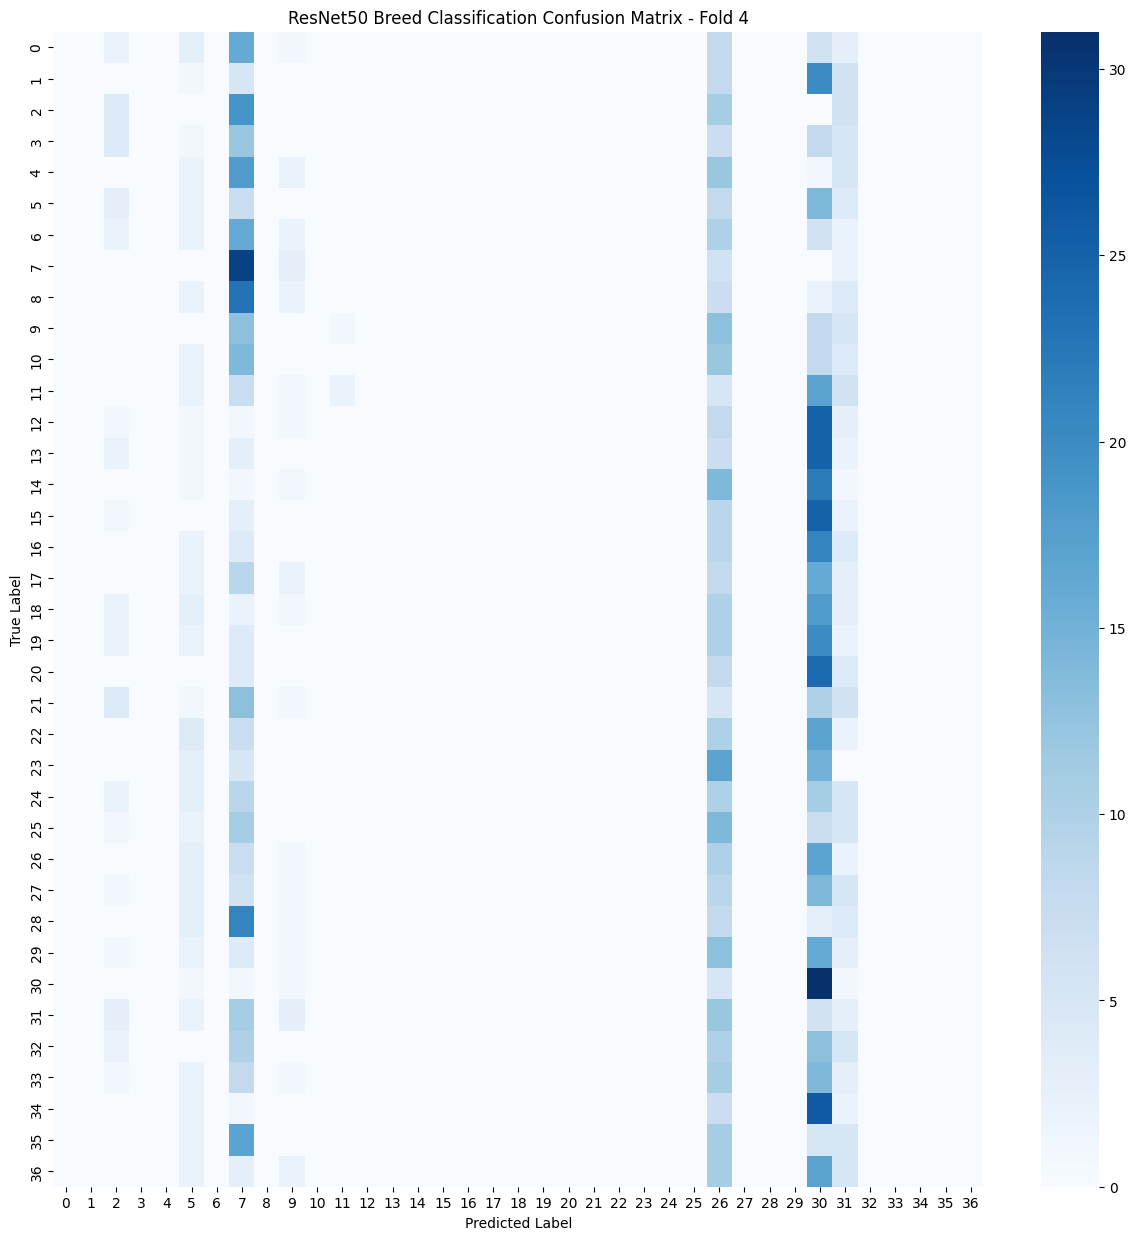

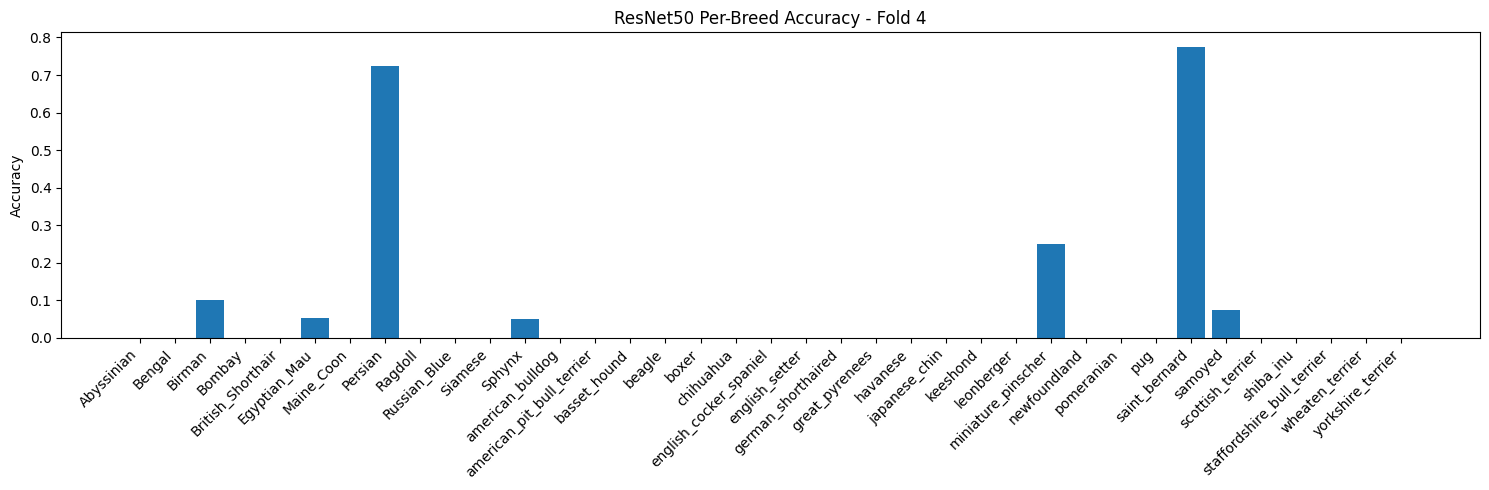

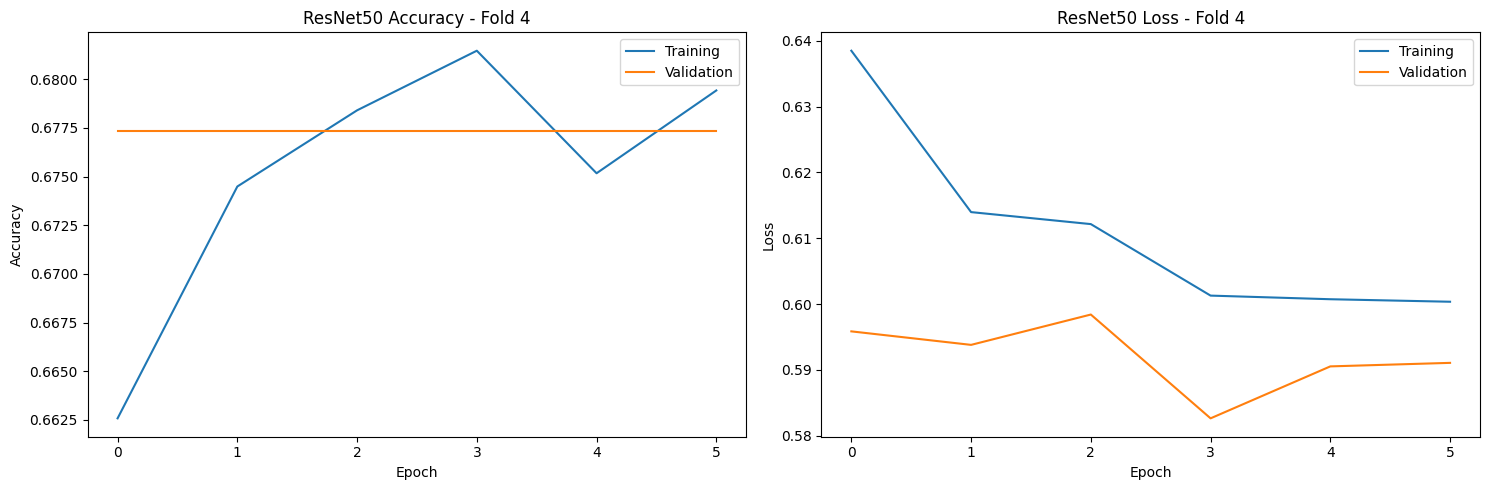


Evaluating fold 5/5
Found 1469 images belonging to 2 classes.
46/46 ━━━━━━━━━━━━━━━━━━━━ 13s 171ms/step


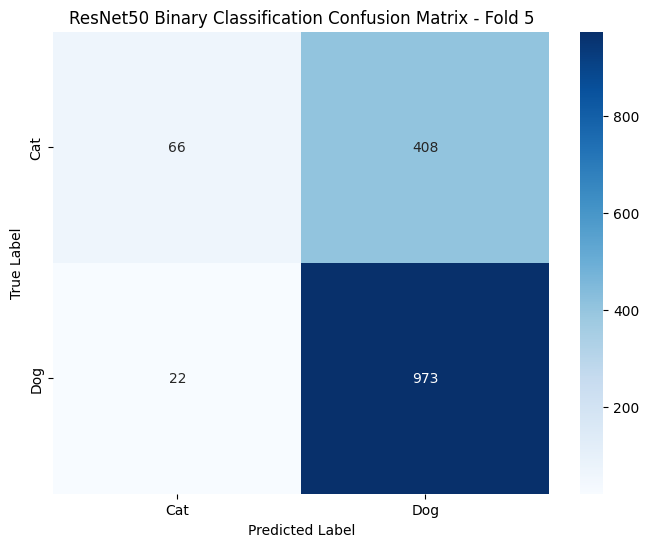

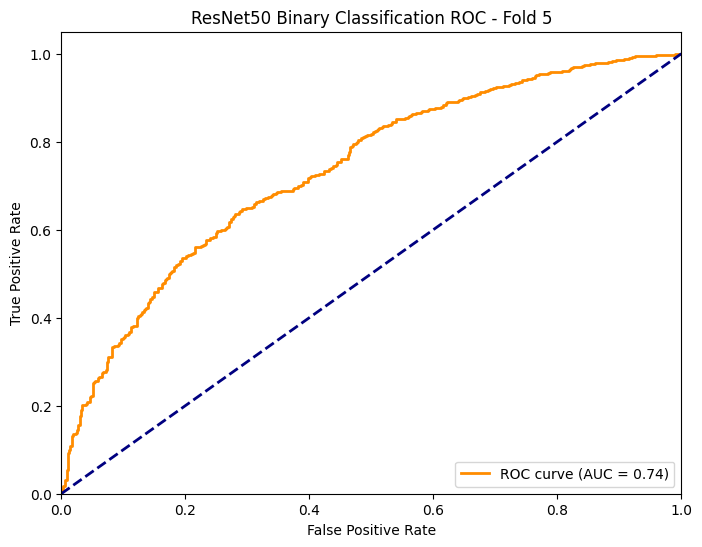

Found 1464 images belonging to 37 classes.
46/46 ━━━━━━━━━━━━━━━━━━━━ 12s 185ms/step


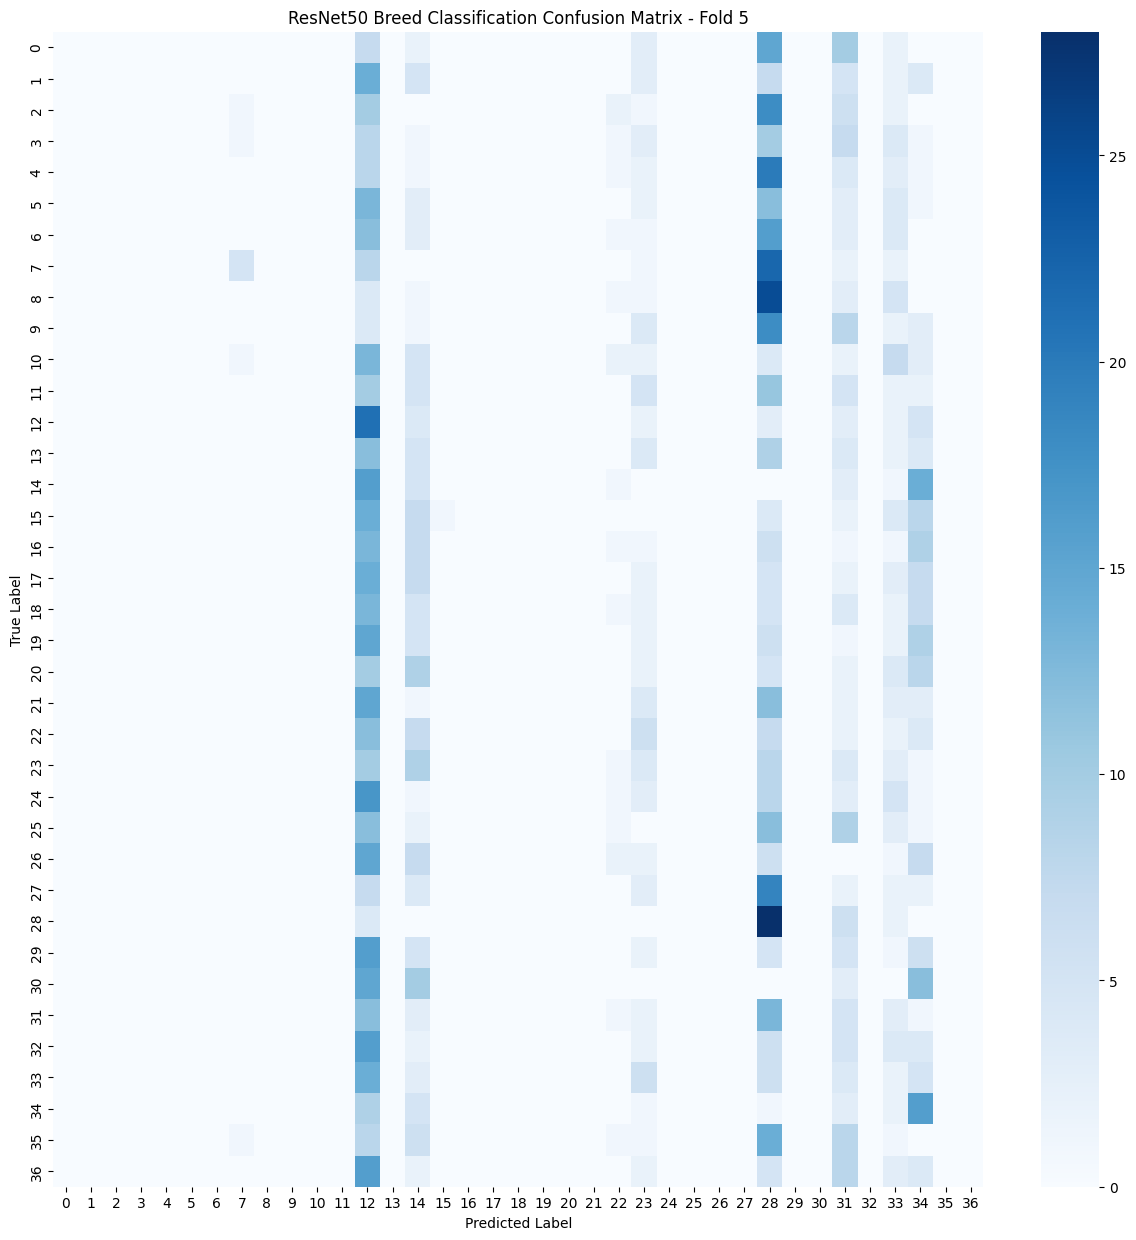

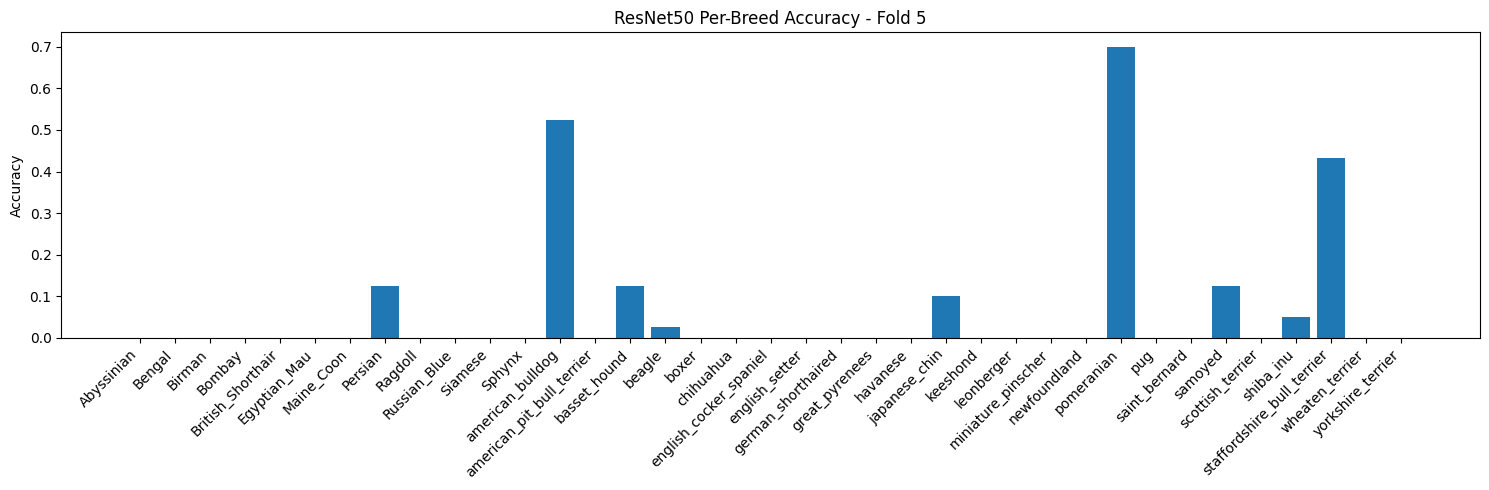

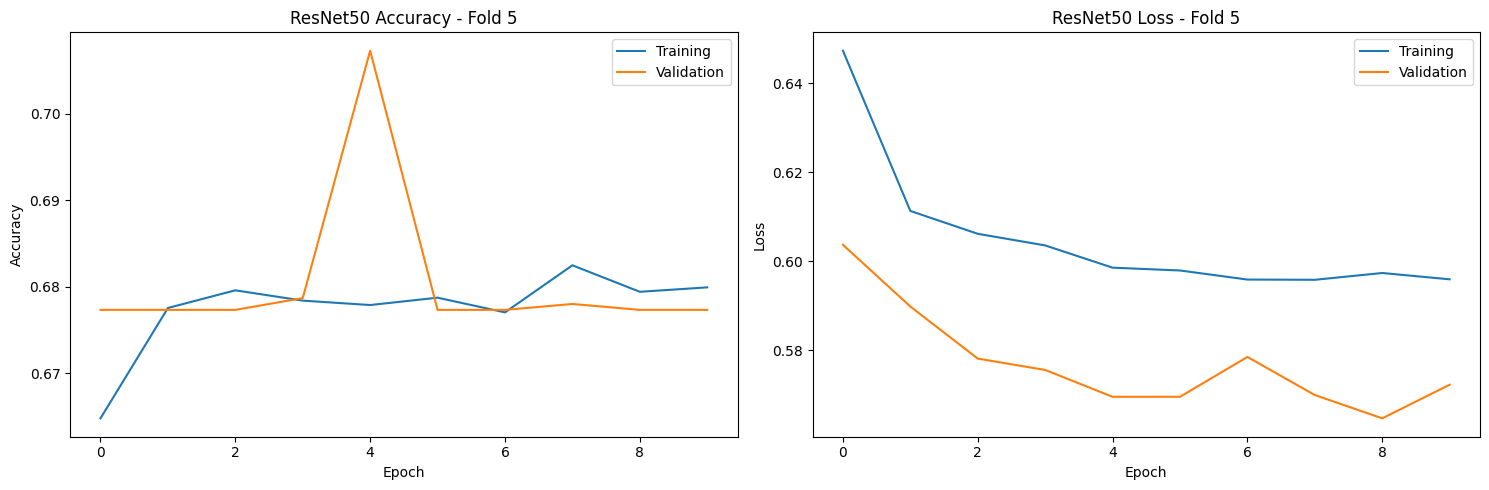


ResNet50 evaluation completed!


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
import tensorflow as tf
import os

def load_resnet50_models(fold):
    """
    Load trained ResNet50 models for evaluation
    """
    binary_model = tf.keras.models.load_model(
        os.path.join(BASE_PATH, f'models/checkpoints/resnet50_binary_fold_{fold}.keras')
    )
    breed_model = tf.keras.models.load_model(
        os.path.join(BASE_PATH, f'models/checkpoints/resnet50_breed_fold_{fold}.keras')
    )
    return binary_model, breed_model

def evaluate_binary_classification(model, test_generator, fold):
    """
    Evaluate binary classification performance
    """
    # Get predictions
    predictions = model.predict(test_generator)
    y_pred = (predictions > 0.5).astype(int)
    y_true = test_generator.classes

    # Calculate metrics
    cm = confusion_matrix(y_true, y_pred)
    classification_rep = classification_report(y_true, y_pred,
                                            target_names=['Cat', 'Dog'],
                                            output_dict=True)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Cat', 'Dog'],
                yticklabels=['Cat', 'Dog'])
    plt.title(f'ResNet50 Binary Classification Confusion Matrix - Fold {fold+1}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig(os.path.join(BASE_PATH, f'results/plots/resnet50_binary_cm_fold_{fold+1}.png'))
    plt.show()

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_true, predictions)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2,
             label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ResNet50 Binary Classification ROC - Fold {fold+1}')
    plt.legend(loc="lower right")
    plt.savefig(os.path.join(BASE_PATH, f'results/plots/resnet50_binary_roc_fold_{fold+1}.png'))
    plt.show()

    return cm, classification_rep, roc_auc

def evaluate_breed_classification(model, test_generator, fold):
    """
    Evaluate breed classification performance
    """
    # Get predictions
    predictions = model.predict(test_generator)
    y_pred = np.argmax(predictions, axis=1)
    y_true = test_generator.classes

    # Calculate metrics
    cm = confusion_matrix(y_true, y_pred)
    classification_rep = classification_report(y_true, y_pred,
                                            target_names=test_generator.class_indices.keys(),
                                            output_dict=True)

    # Plot confusion matrix
    plt.figure(figsize=(15, 15))
    sns.heatmap(cm, cmap='Blues')
    plt.title(f'ResNet50 Breed Classification Confusion Matrix - Fold {fold+1}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig(os.path.join(BASE_PATH, f'results/plots/resnet50_breed_cm_fold_{fold+1}.png'))
    plt.show()

    # Plot per-class accuracy
    accuracies = cm.diagonal() / cm.sum(axis=1)
    plt.figure(figsize=(15, 5))
    plt.bar(test_generator.class_indices.keys(), accuracies)
    plt.xticks(rotation=45, ha='right')
    plt.title(f'ResNet50 Per-Breed Accuracy - Fold {fold+1}')
    plt.ylabel('Accuracy')
    plt.tight_layout()
    plt.savefig(os.path.join(BASE_PATH, f'results/plots/resnet50_breed_accuracy_fold_{fold+1}.png'))
    plt.show()

    return cm, classification_rep

def plot_learning_curves(histories, fold):
    """
    Plot learning curves from training history
    """
    metrics = ['accuracy', 'loss']
    titles = ['Accuracy', 'Loss']

    plt.figure(figsize=(15, 5))
    for i, metric in enumerate(metrics):
        plt.subplot(1, 2, i+1)
        plt.plot(histories[metric], label='Training')
        plt.plot(histories[f'val_{metric}'], label='Validation')
        plt.title(f'ResNet50 {titles[i]} - Fold {fold+1}')
        plt.xlabel('Epoch')
        plt.ylabel(titles[i])
        plt.legend()

    plt.tight_layout()
    plt.savefig(os.path.join(BASE_PATH, f'results/plots/resnet50_learning_curves_fold_{fold+1}.png'))
    plt.show()

# Main evaluation execution
print("Starting ResNet50 evaluation...")

# Store results for all folds
results = {
    'binary': {
        'confusion_matrices': [],
        'classification_reports': [],
        'roc_auc_scores': []
    },
    'breed': {
        'confusion_matrices': [],
        'classification_reports': []
    }
}

# Evaluate each fold
for fold in range(N_FOLDS):
    print(f"\nEvaluating fold {fold+1}/{N_FOLDS}")

    # Load models
    binary_model, breed_model = load_resnet50_models(fold)

    # Create test generators
    _, test_datagen = create_data_generators()

    # Binary classification evaluation
    binary_test = test_datagen.flow_from_directory(
        os.path.join(BASE_PATH, f'data/kfold/fold_{fold}/binary/val'),
        target_size=(224, 224),
        batch_size=32,
        class_mode='binary',
        shuffle=False
    )

    cm, report, roc_auc = evaluate_binary_classification(binary_model, binary_test, fold)
    results['binary']['confusion_matrices'].append(cm)
    results['binary']['classification_reports'].append(report)
    results['binary']['roc_auc_scores'].append(roc_auc)

    # Breed classification evaluation
    breed_test = test_datagen.flow_from_directory(
        os.path.join(BASE_PATH, f'data/kfold/fold_{fold}/breeds/val'),
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        shuffle=False
    )

    cm, report = evaluate_breed_classification(breed_model, breed_test, fold)
    results['binary']['confusion_matrices'].append(cm)
    results['binary']['classification_reports'].append(report)

    # Plot learning curves
    history = np.load(os.path.join(BASE_PATH, f'results/metrics/resnet50_binary_fold_{fold}_history.npy'),
                     allow_pickle=True).item()
    plot_learning_curves(history, fold)

# Save evaluation results
np.save(os.path.join(BASE_PATH, 'results/metrics/resnet50_evaluation_results.npy'), results)
print("\nResNet50 evaluation completed!")

#Step 12: Model Evaluation - VGG16

Performance metrics calculation (Accuracy, Precision, Recall, F1)

Confusion matrix

ROC curves and AUC

Performance visualization

K-fold results analysis

Starting VGG16 evaluation...

Evaluating fold 1/5
Found 1471 images belonging to 2 classes.
46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 117ms/step


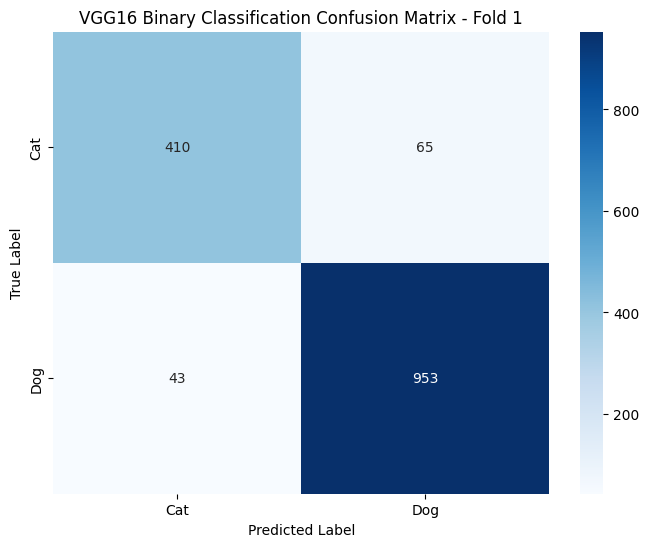

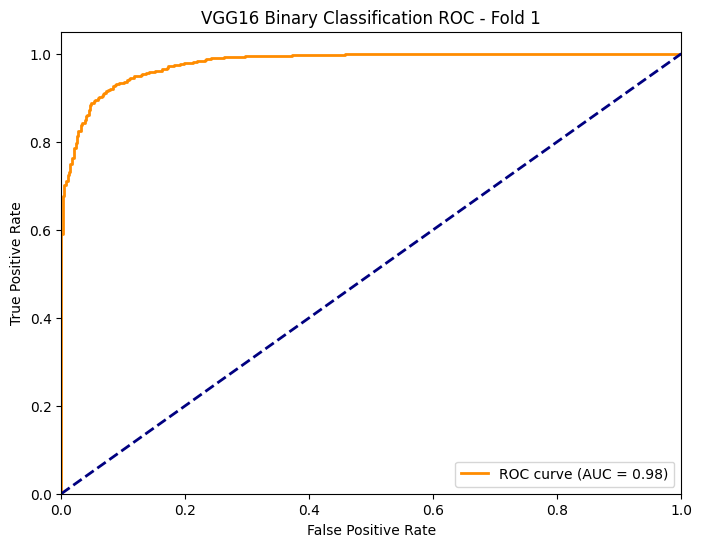

Found 1473 images belonging to 37 classes.
47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 107ms/step


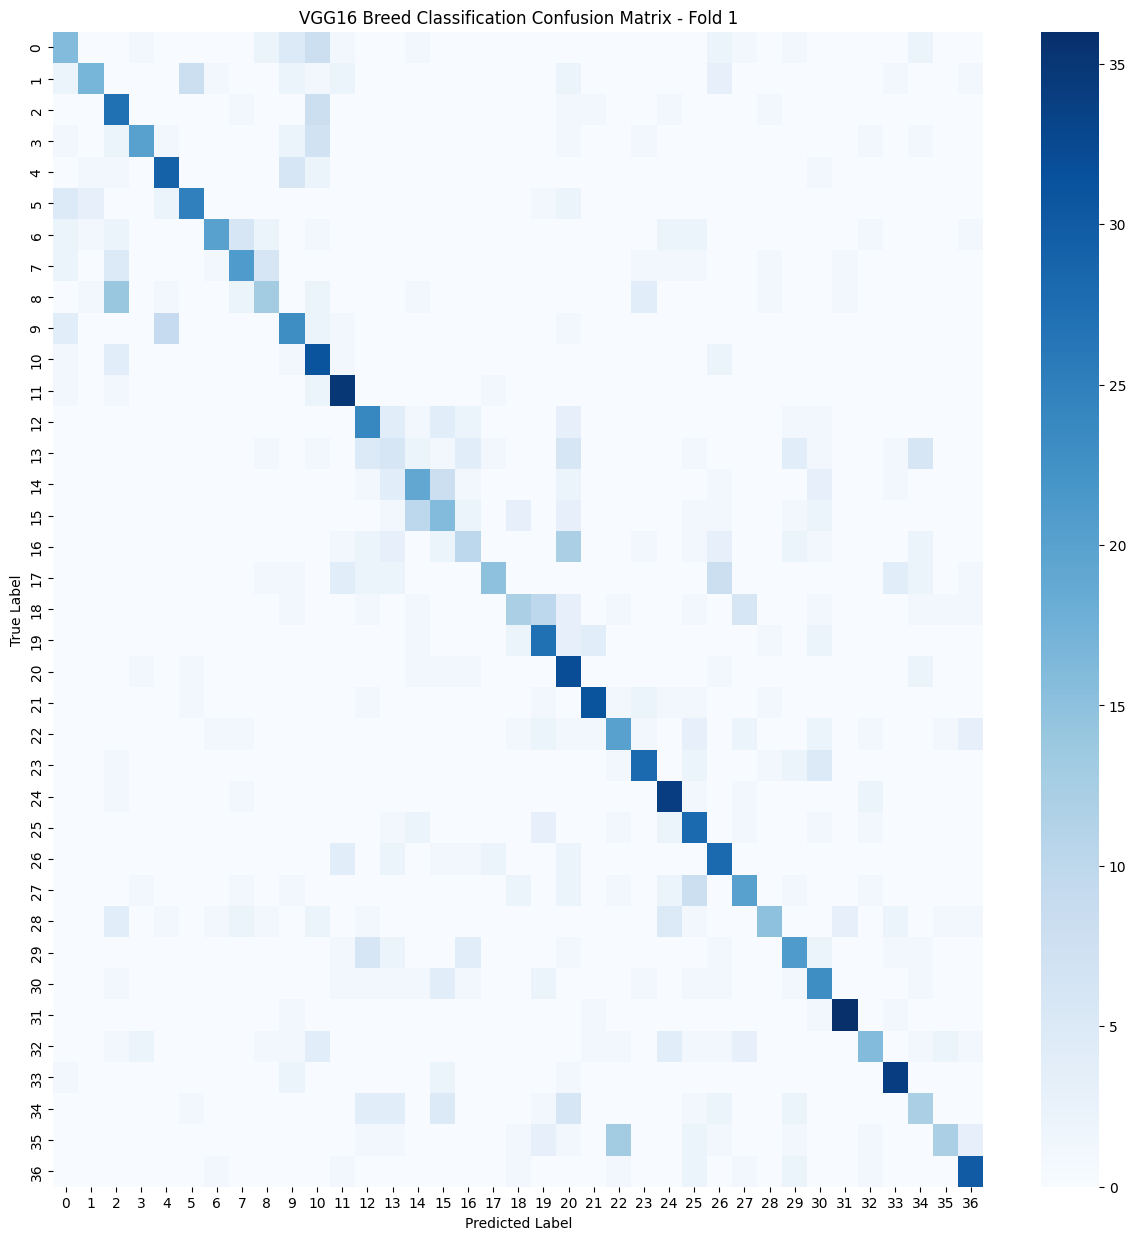

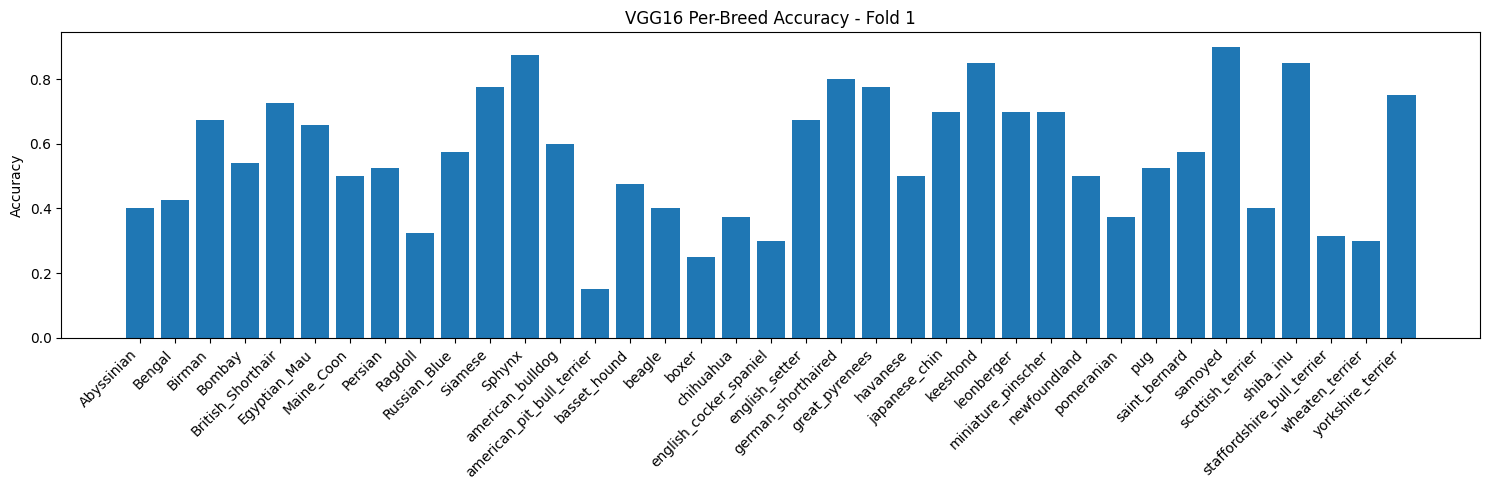

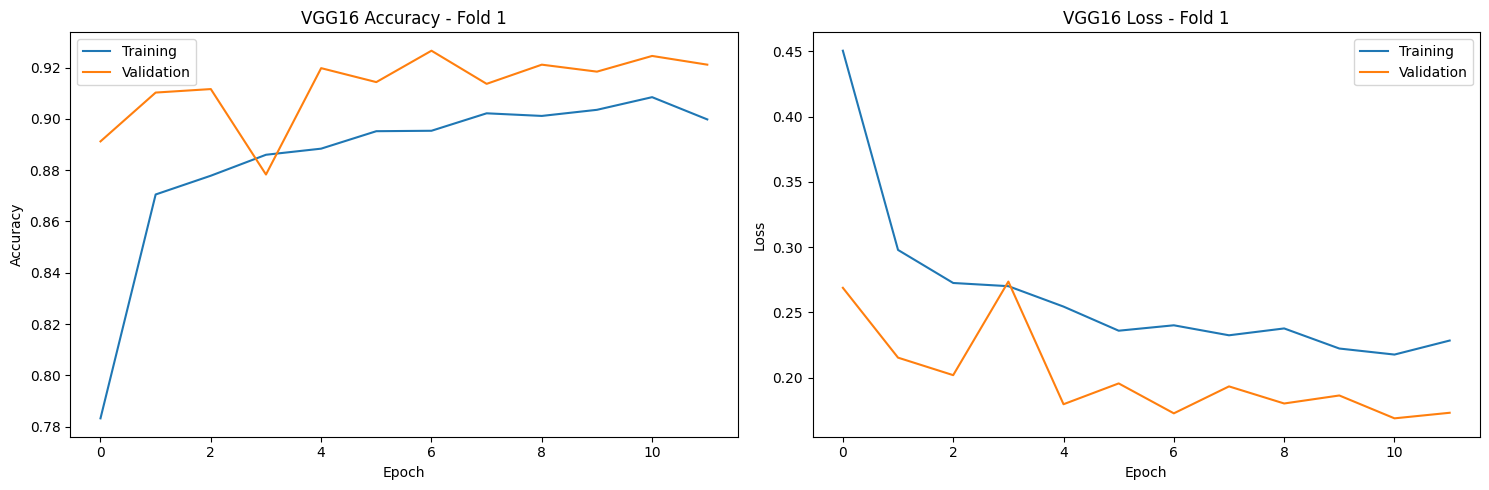


Evaluating fold 2/5
Found 1470 images belonging to 2 classes.
46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 118ms/step


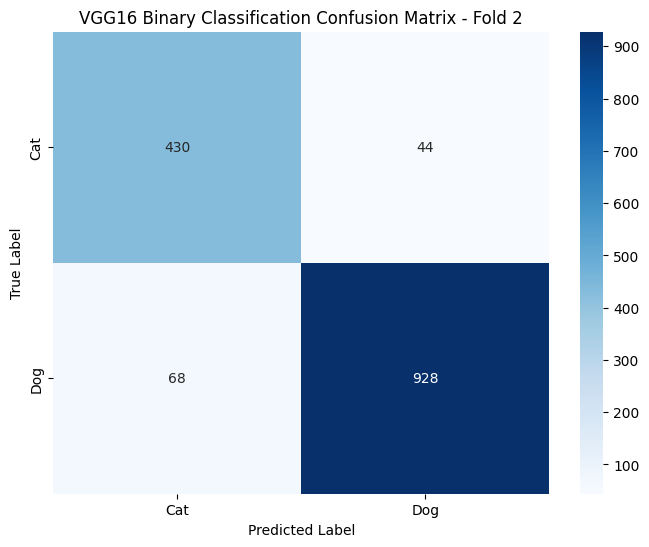

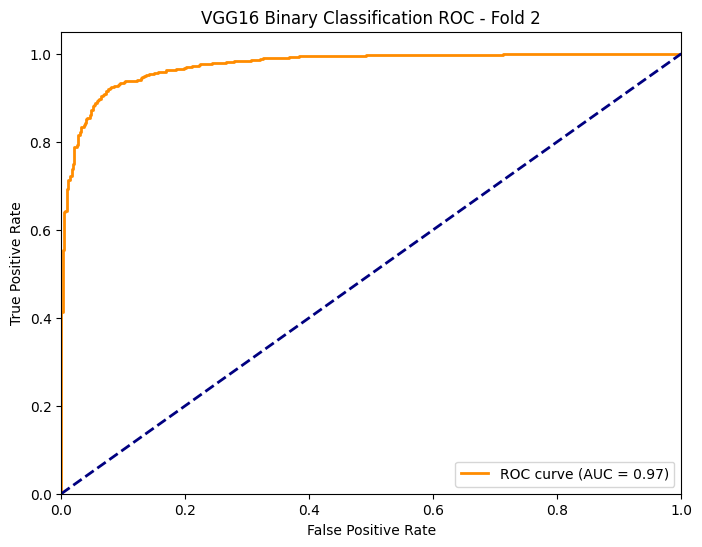

Found 1471 images belonging to 37 classes.
46/46 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step


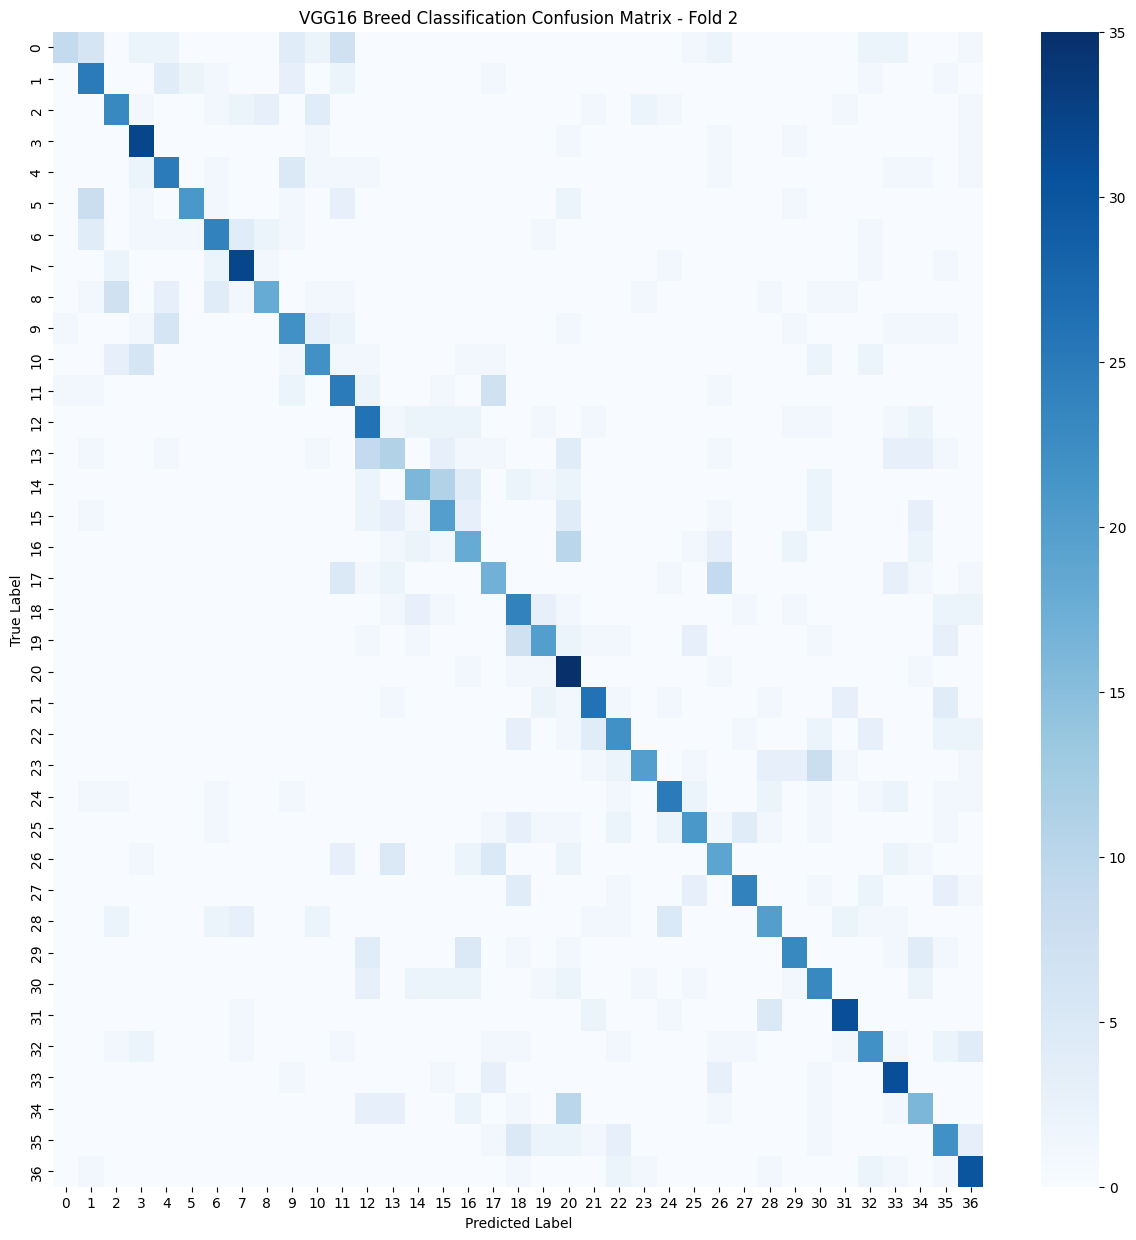

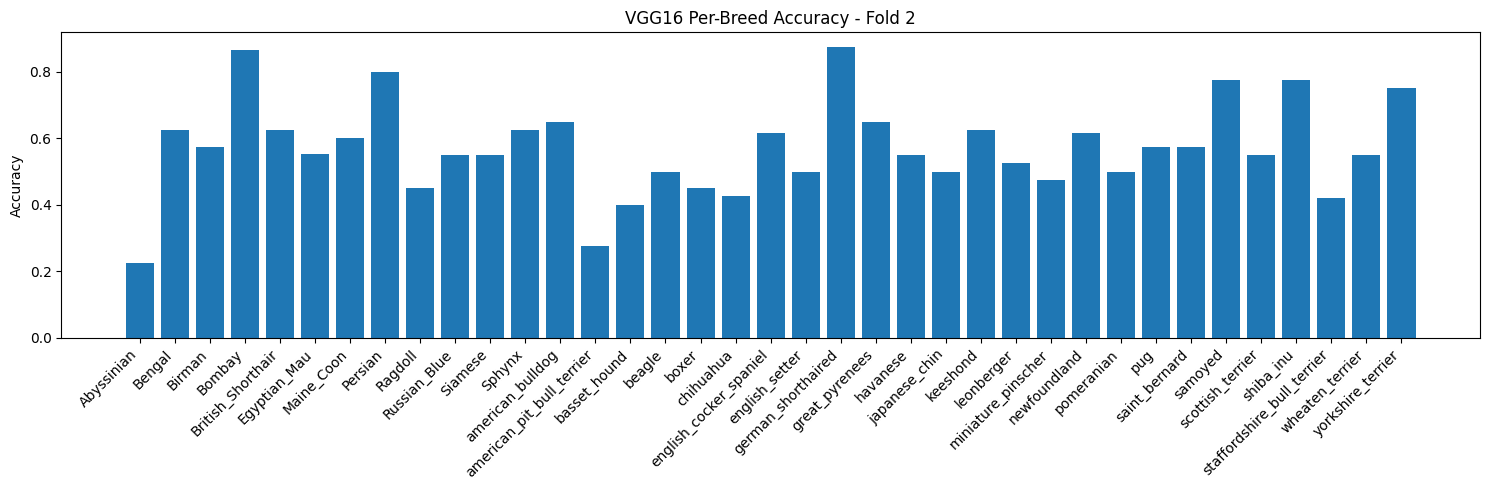

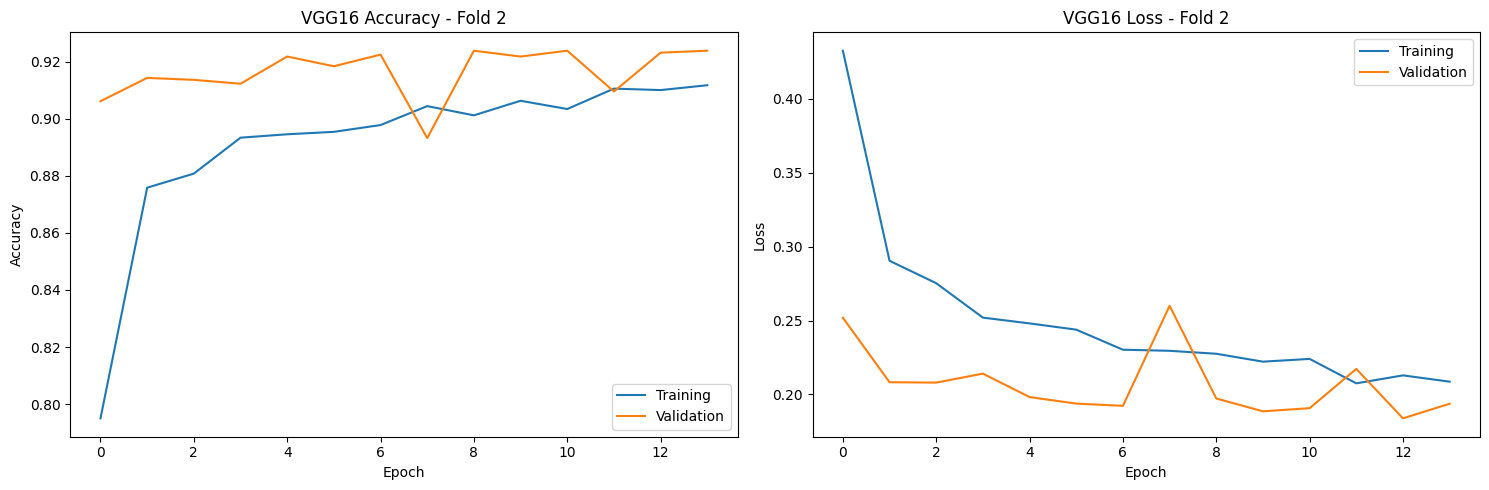


Evaluating fold 3/5
Found 1470 images belonging to 2 classes.
46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 114ms/step


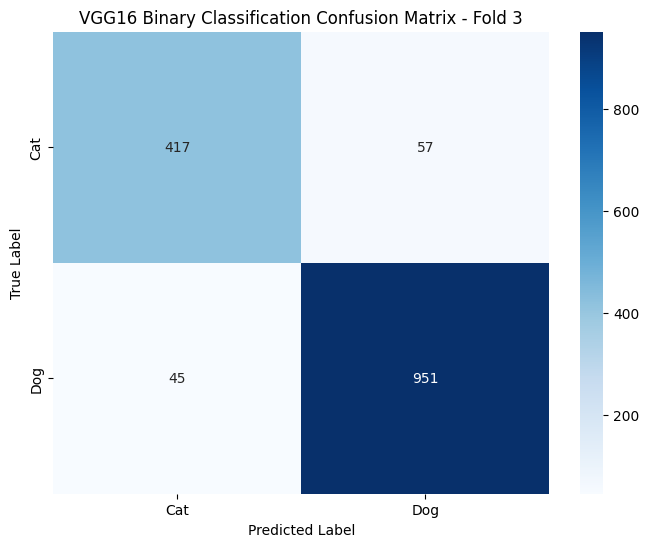

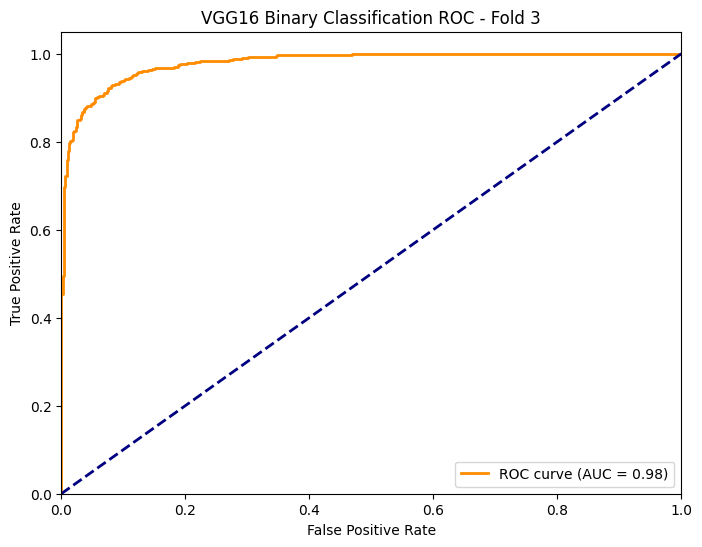

Found 1471 images belonging to 37 classes.
46/46 ━━━━━━━━━━━━━━━━━━━━ 7s 122ms/step


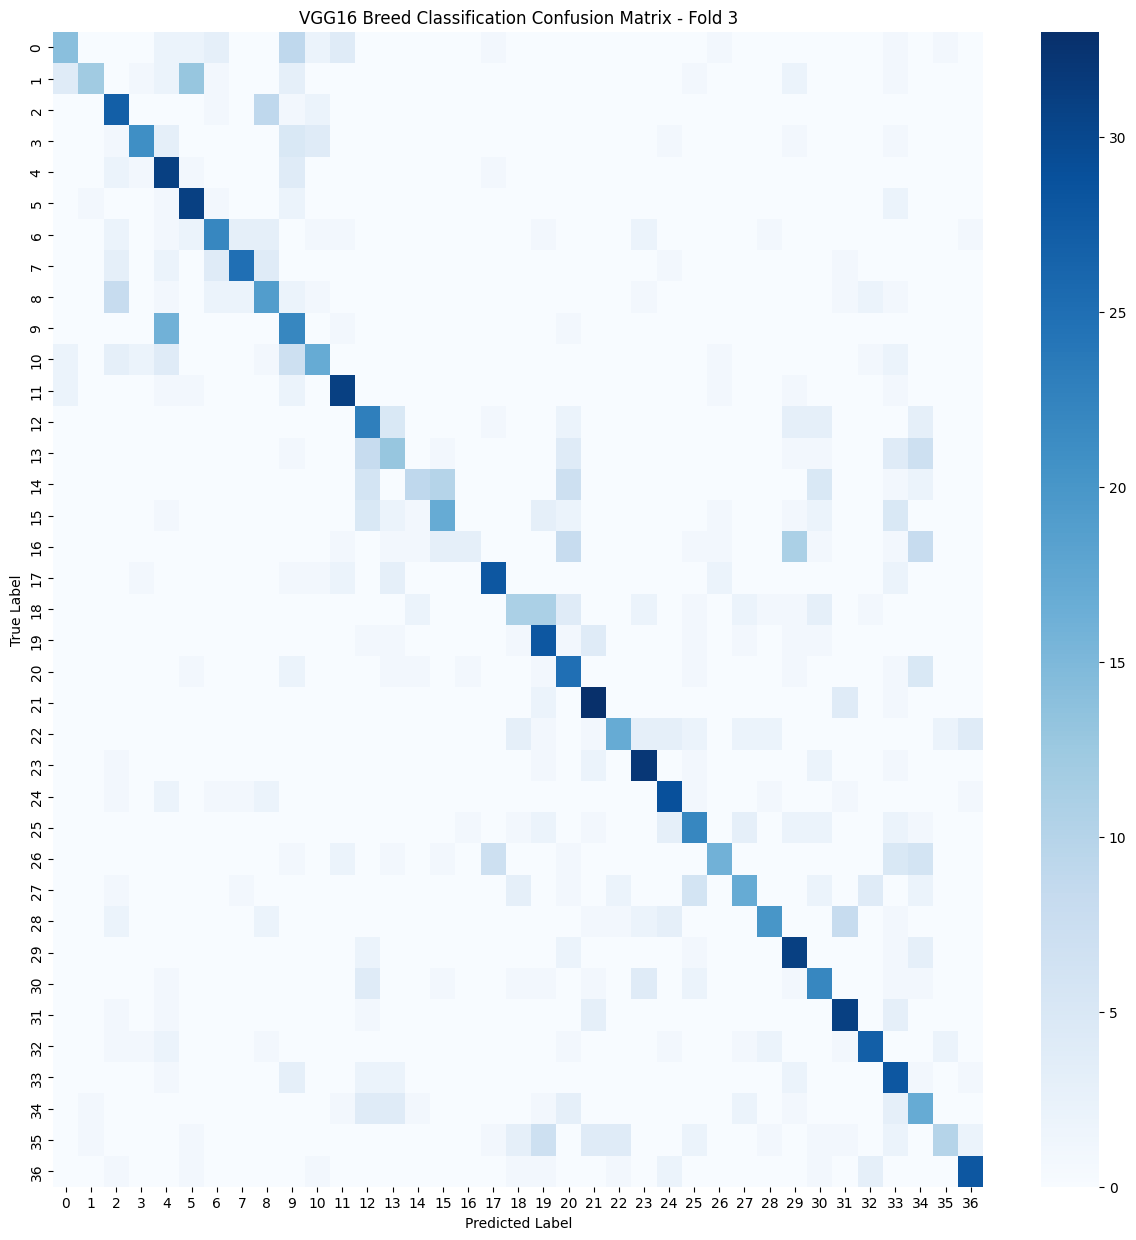

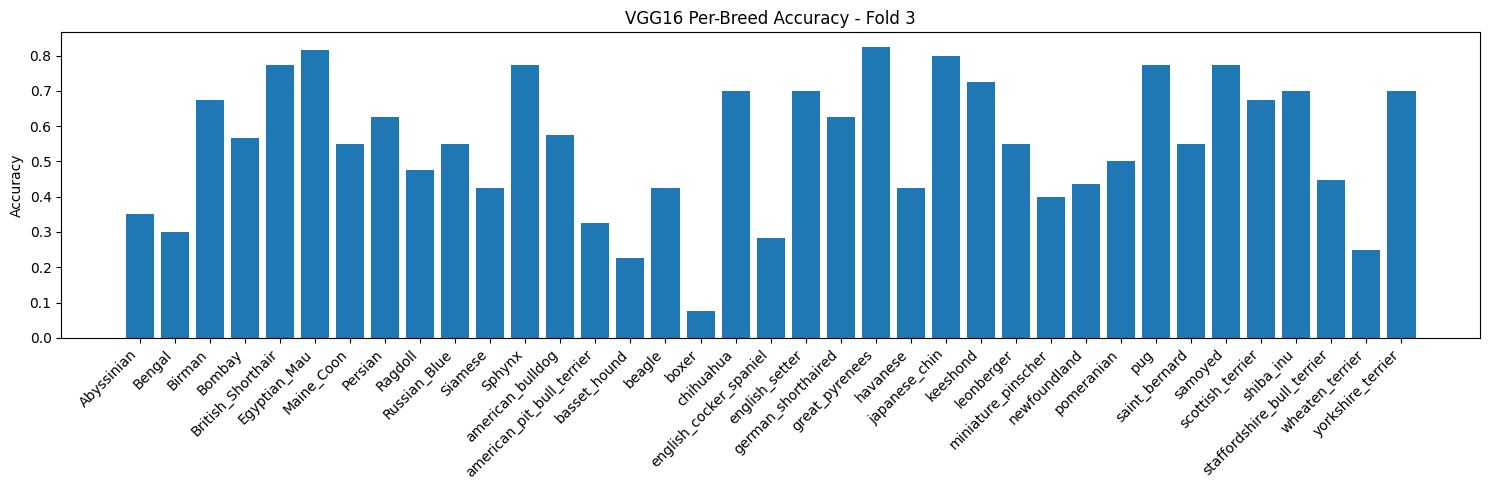

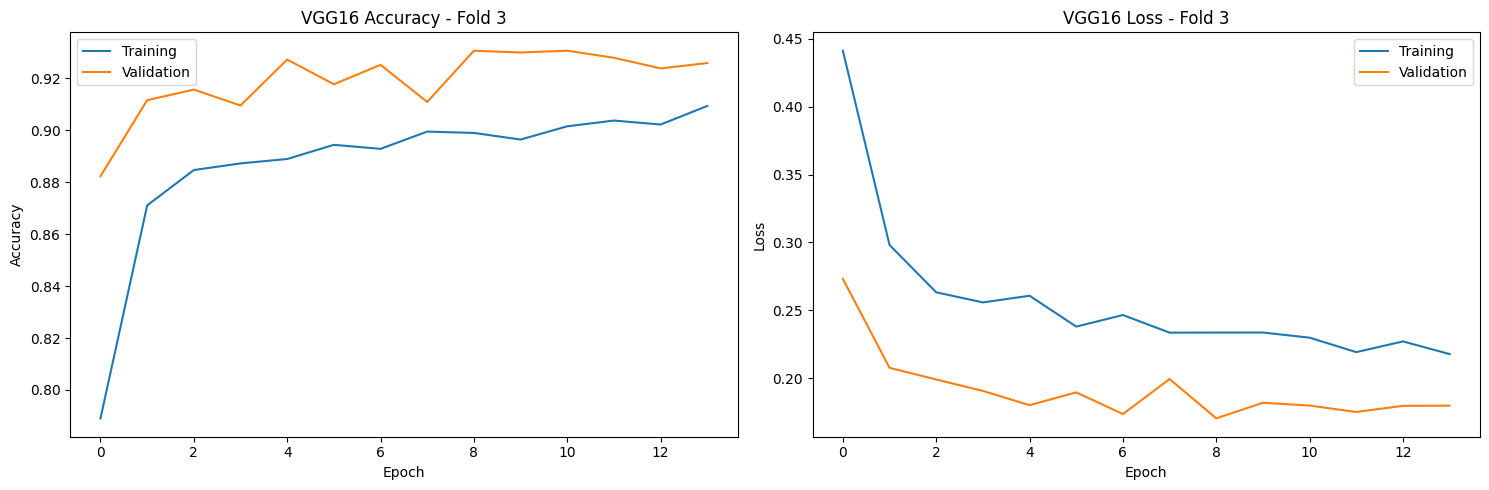


Evaluating fold 4/5
Found 1469 images belonging to 2 classes.
46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 119ms/step


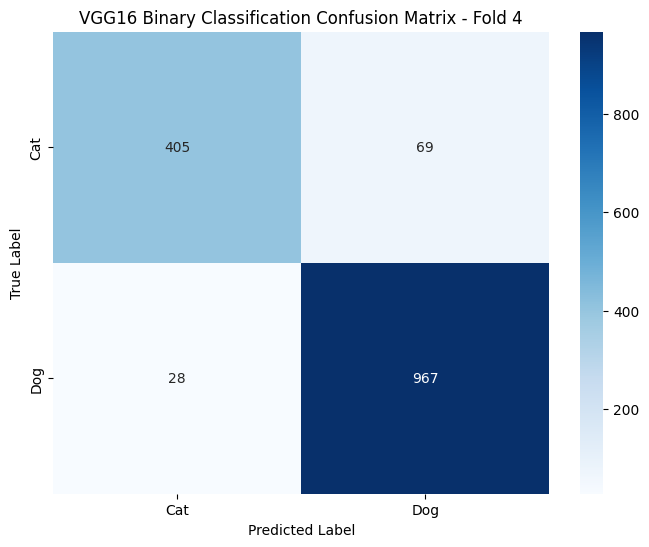

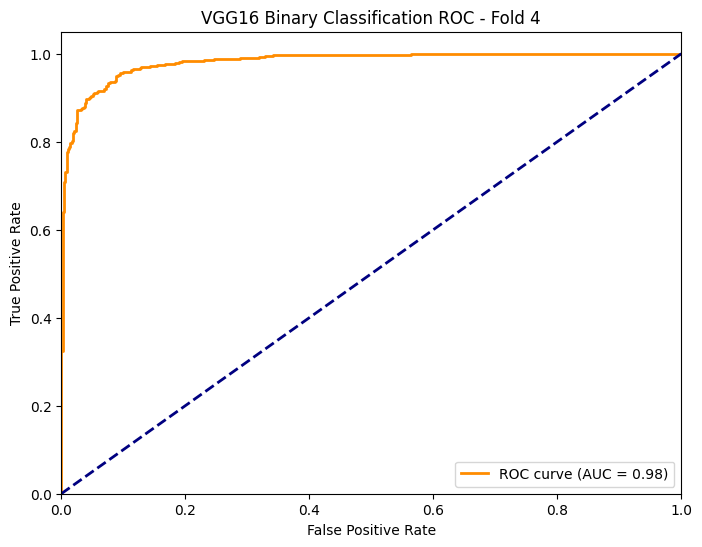

Found 1470 images belonging to 37 classes.
46/46 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step


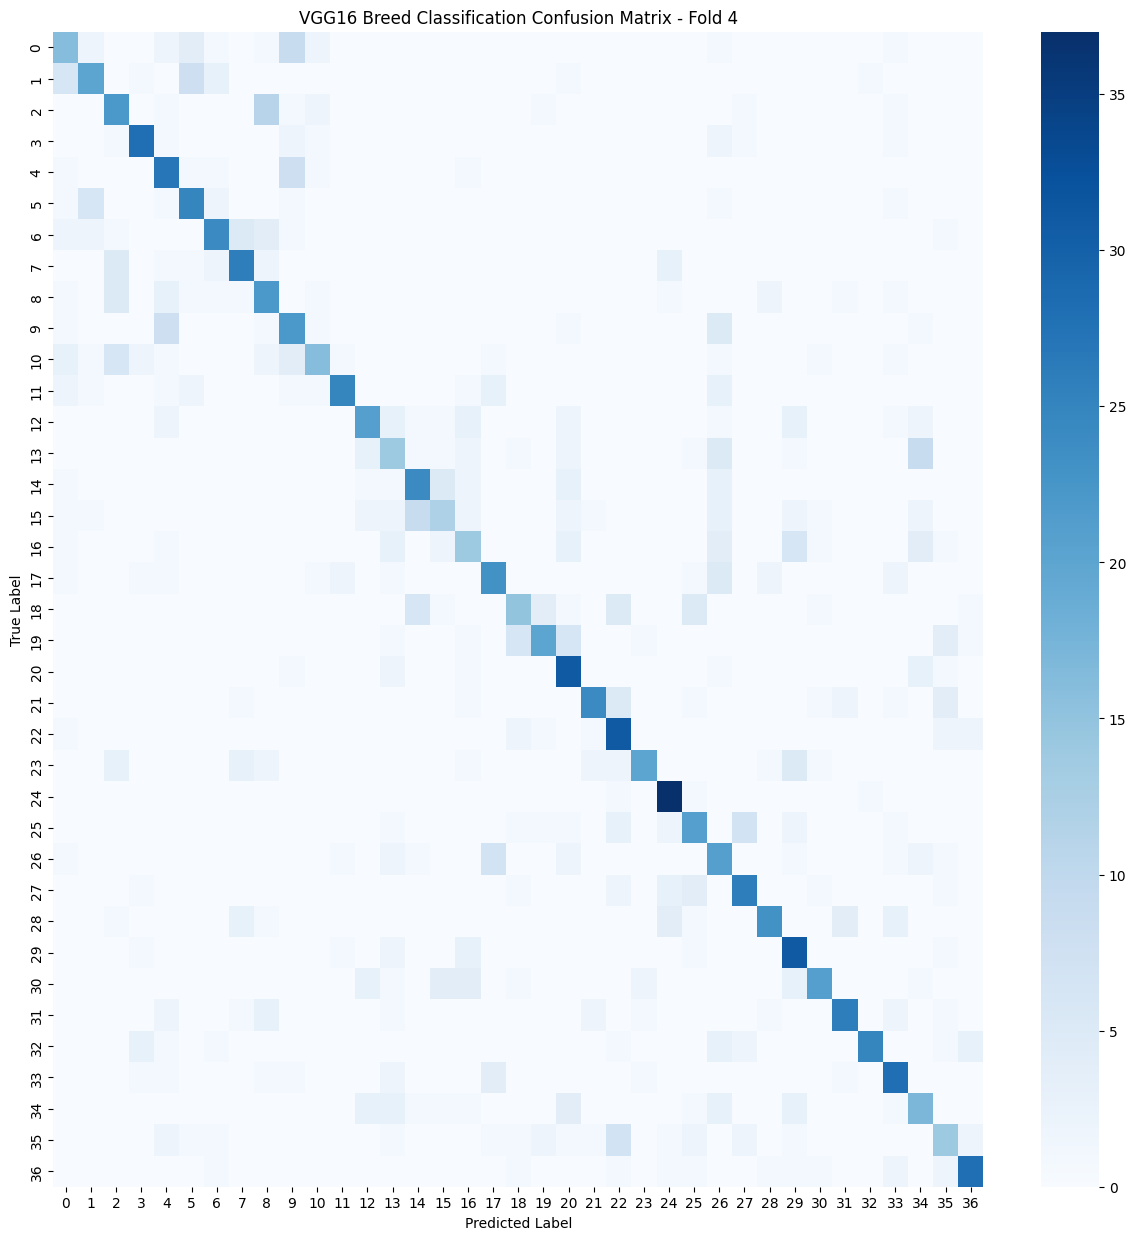

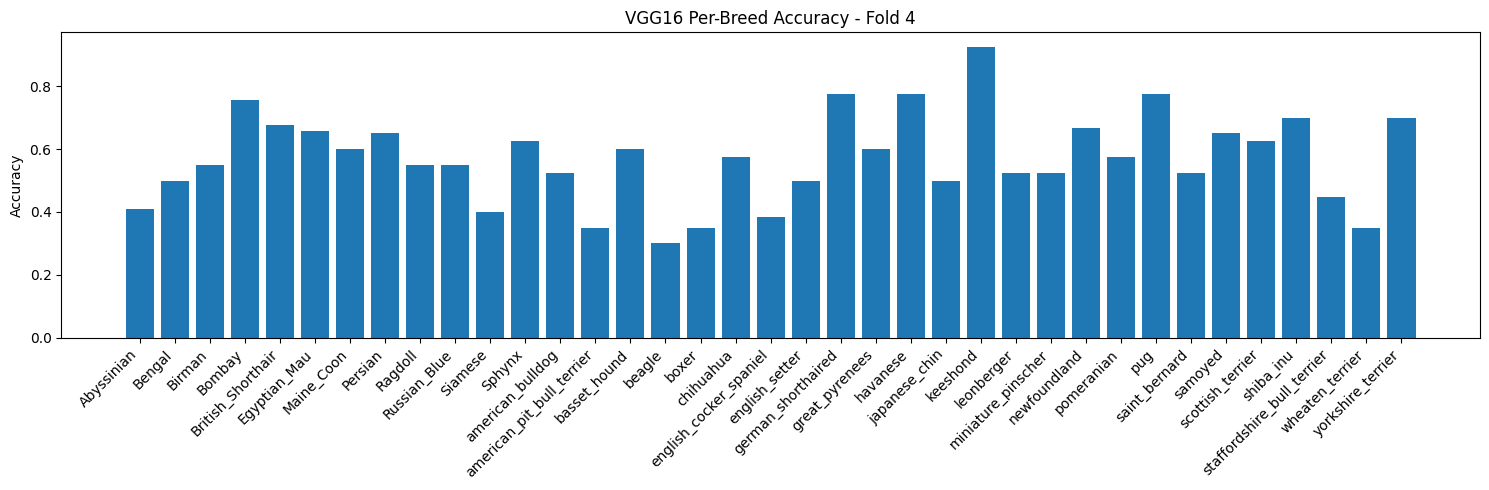

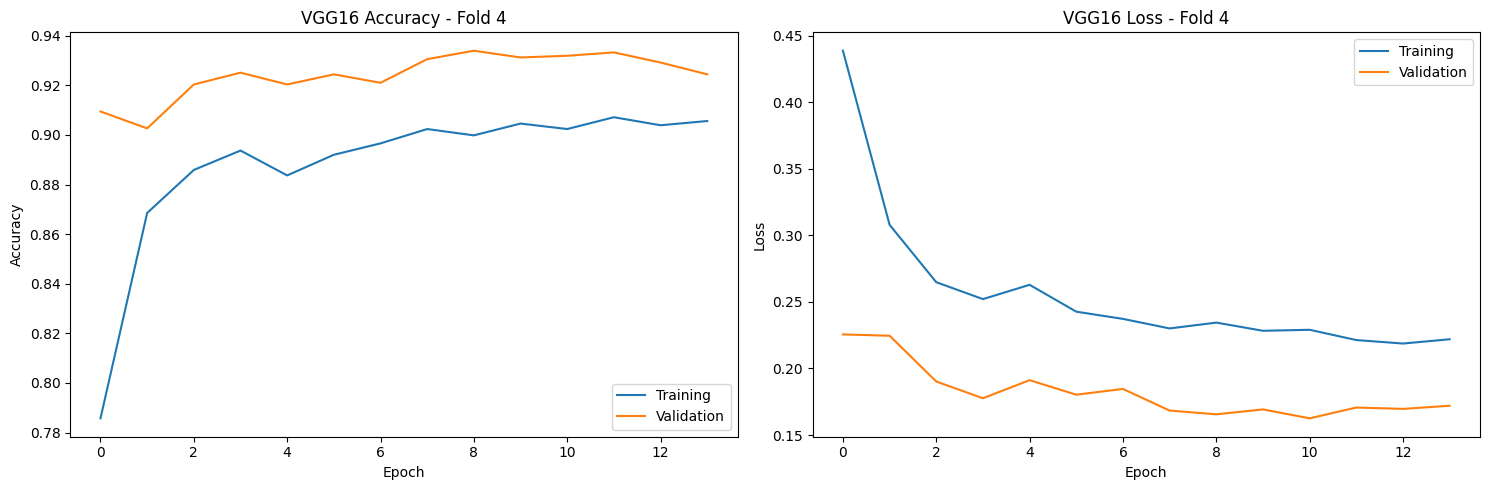


Evaluating fold 5/5
Found 1469 images belonging to 2 classes.
46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 116ms/step


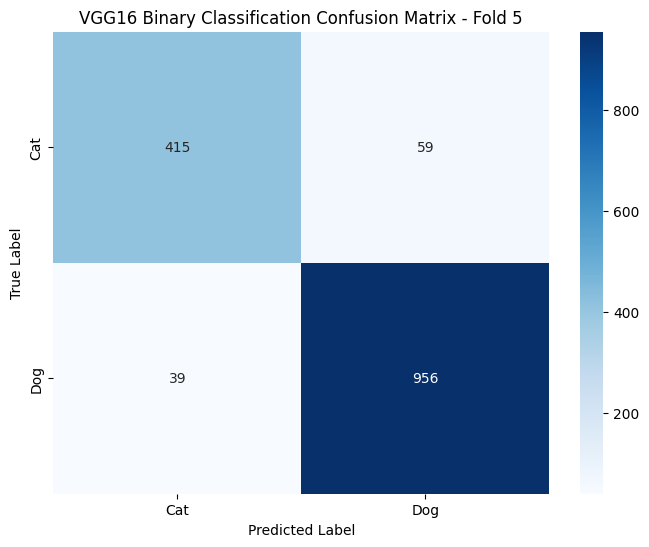

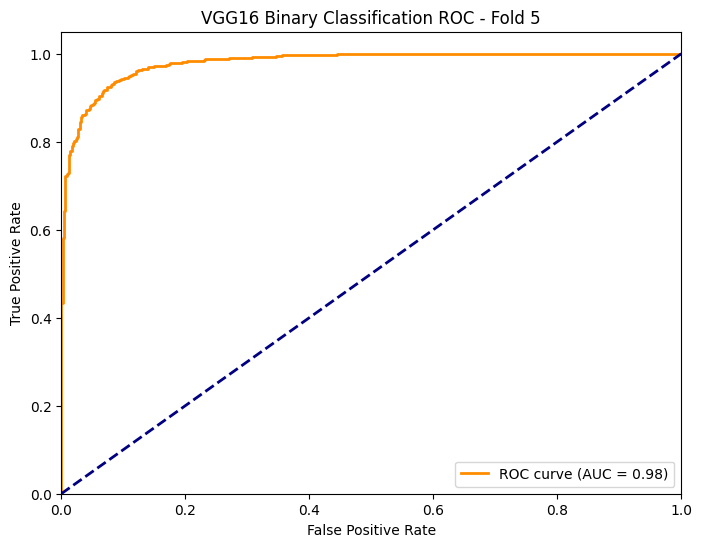

Found 1464 images belonging to 37 classes.
46/46 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step


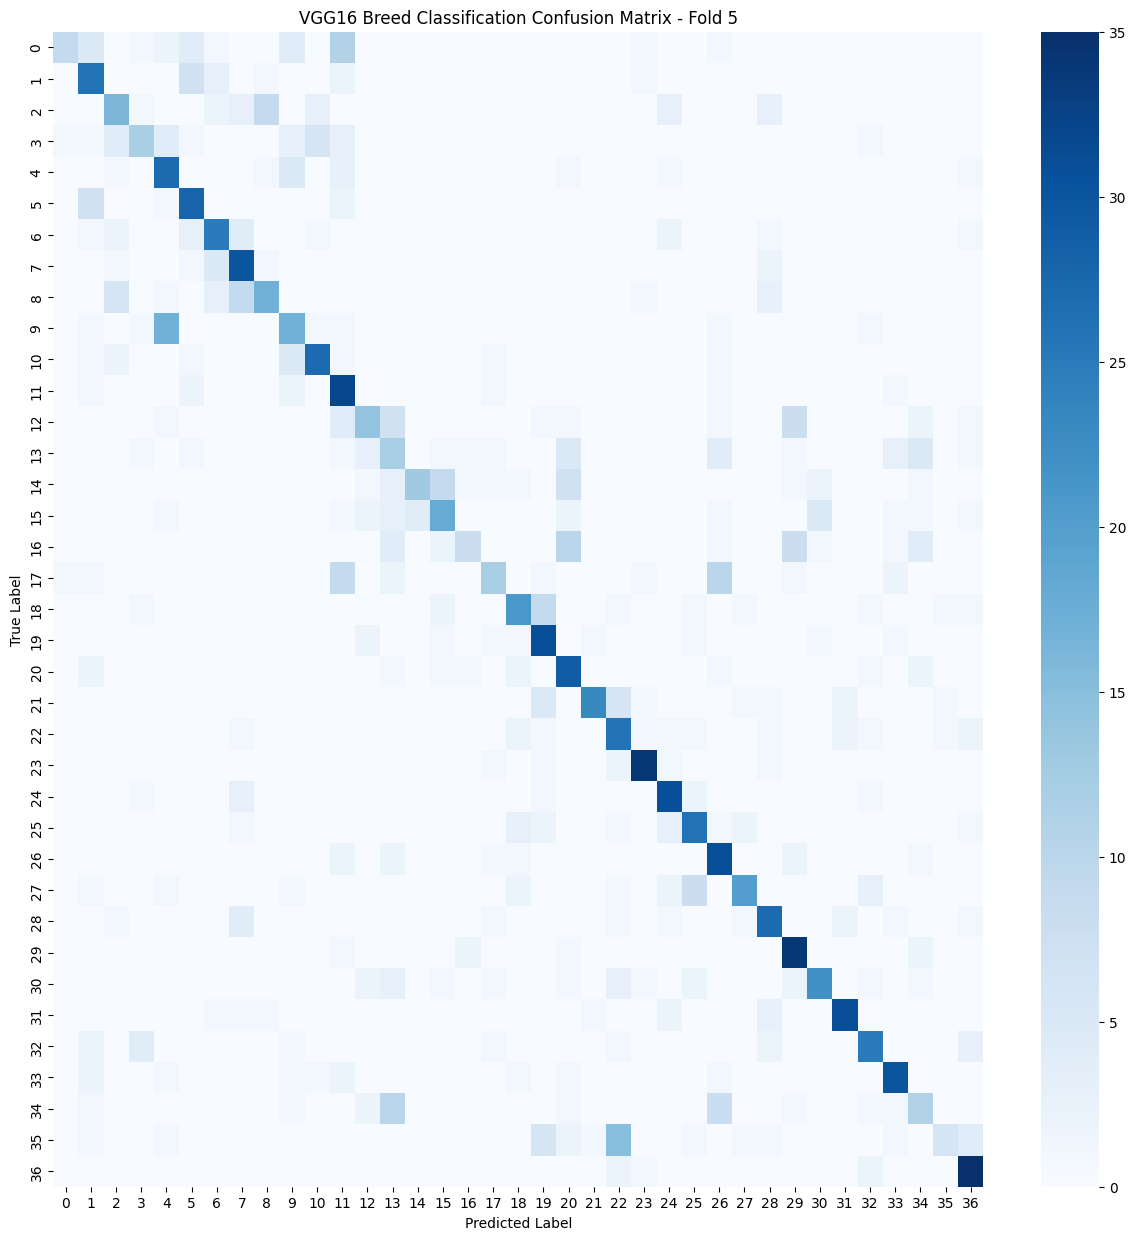

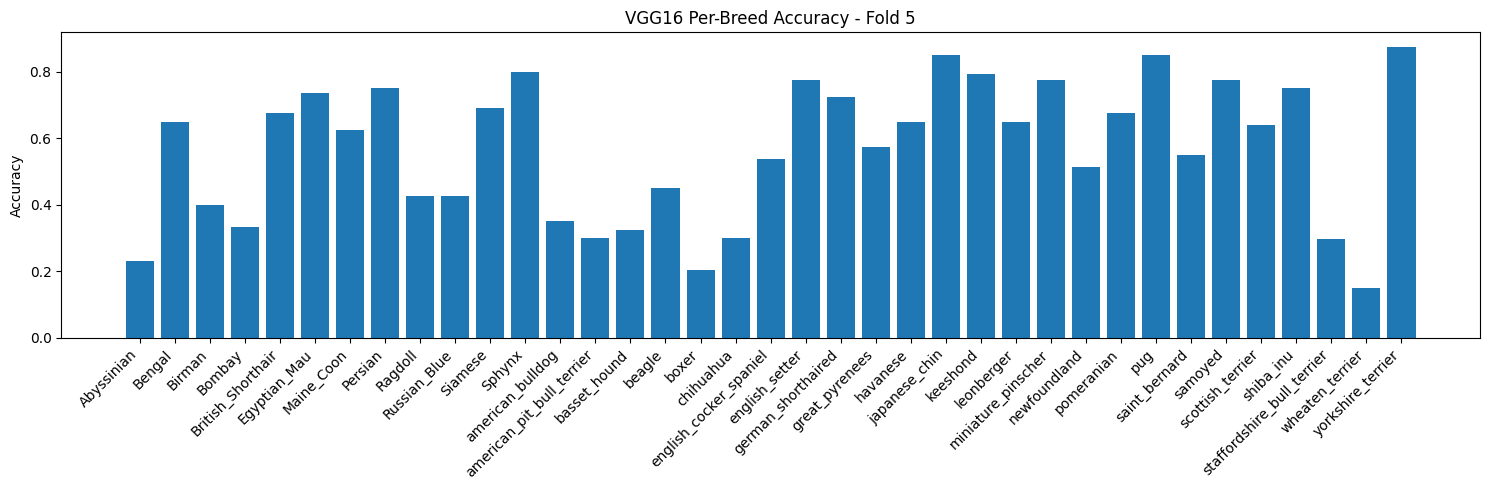

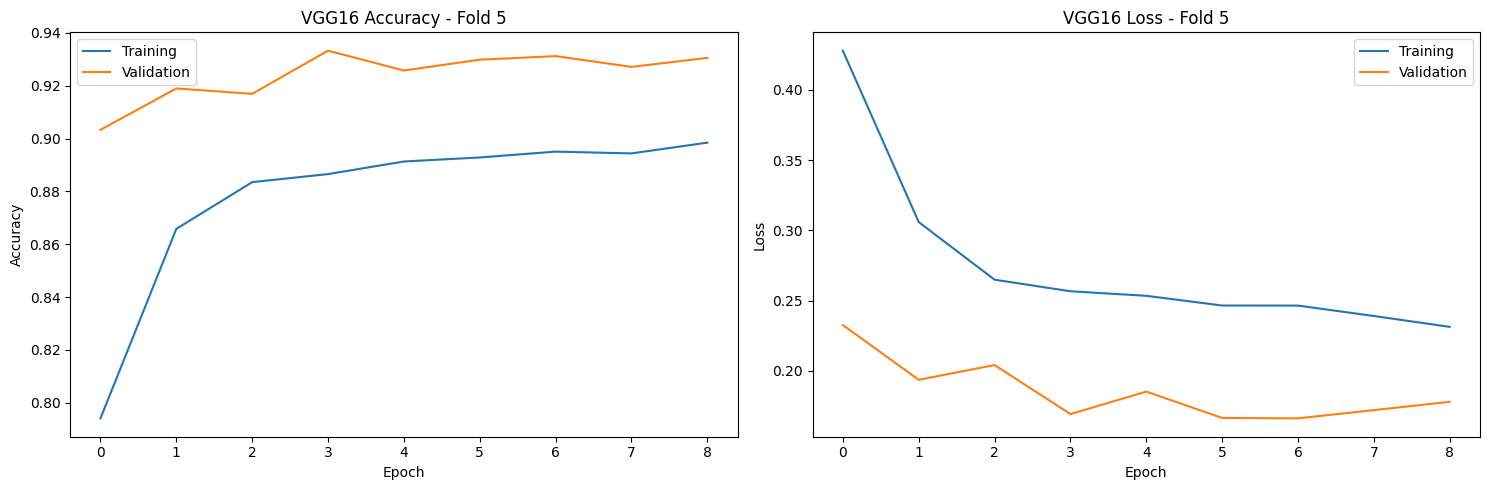


VGG16 evaluation completed!


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
import tensorflow as tf
import os

def load_vgg16_models(fold):
    """
    Load trained VGG16 models for evaluation
    """
    binary_model = tf.keras.models.load_model(
        os.path.join(BASE_PATH, f'models/checkpoints/vgg16_binary_fold_{fold}.keras')
    )
    breed_model = tf.keras.models.load_model(
        os.path.join(BASE_PATH, f'models/checkpoints/vgg16_breed_fold_{fold}.keras')
    )
    return binary_model, breed_model

def evaluate_vgg16_binary(model, test_generator, fold):
    """
    Evaluate VGG16 binary classification performance
    """
    # Get predictions
    predictions = model.predict(test_generator)
    y_pred = (predictions > 0.5).astype(int)
    y_true = test_generator.classes

    # Calculate metrics
    cm = confusion_matrix(y_true, y_pred)
    classification_rep = classification_report(y_true, y_pred,
                                            target_names=['Cat', 'Dog'],
                                            output_dict=True)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Cat', 'Dog'],
                yticklabels=['Cat', 'Dog'])
    plt.title(f'VGG16 Binary Classification Confusion Matrix - Fold {fold+1}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig(os.path.join(BASE_PATH, f'results/plots/vgg16_binary_cm_fold_{fold+1}.png'))
    plt.show()

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_true, predictions)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2,
             label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'VGG16 Binary Classification ROC - Fold {fold+1}')
    plt.legend(loc="lower right")
    plt.savefig(os.path.join(BASE_PATH, f'results/plots/vgg16_binary_roc_fold_{fold+1}.png'))
    plt.show()

    return cm, classification_rep, roc_auc

def evaluate_vgg16_breed(model, test_generator, fold):
    """
    Evaluate VGG16 breed classification performance
    """
    # Get predictions
    predictions = model.predict(test_generator)
    y_pred = np.argmax(predictions, axis=1)
    y_true = test_generator.classes

    # Calculate metrics
    cm = confusion_matrix(y_true, y_pred)
    classification_rep = classification_report(y_true, y_pred,
                                            target_names=test_generator.class_indices.keys(),
                                            output_dict=True)

    # Plot confusion matrix
    plt.figure(figsize=(15, 15))
    sns.heatmap(cm, cmap='Blues')
    plt.title(f'VGG16 Breed Classification Confusion Matrix - Fold {fold+1}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig(os.path.join(BASE_PATH, f'results/plots/vgg16_breed_cm_fold_{fold+1}.png'))
    plt.show()

    # Plot per-class accuracy
    accuracies = cm.diagonal() / cm.sum(axis=1)
    plt.figure(figsize=(15, 5))
    plt.bar(test_generator.class_indices.keys(), accuracies)
    plt.xticks(rotation=45, ha='right')
    plt.title(f'VGG16 Per-Breed Accuracy - Fold {fold+1}')
    plt.ylabel('Accuracy')
    plt.tight_layout()
    plt.savefig(os.path.join(BASE_PATH, f'results/plots/vgg16_breed_accuracy_fold_{fold+1}.png'))
    plt.show()

    return cm, classification_rep

def plot_vgg16_learning_curves(histories, fold):
    """
    Plot learning curves from VGG16 training history
    """
    metrics = ['accuracy', 'loss']
    titles = ['Accuracy', 'Loss']

    plt.figure(figsize=(15, 5))
    for i, metric in enumerate(metrics):
        plt.subplot(1, 2, i+1)
        plt.plot(histories[metric], label='Training')
        plt.plot(histories[f'val_{metric}'], label='Validation')
        plt.title(f'VGG16 {titles[i]} - Fold {fold+1}')
        plt.xlabel('Epoch')
        plt.ylabel(titles[i])
        plt.legend()

    plt.tight_layout()
    plt.savefig(os.path.join(BASE_PATH, f'results/plots/vgg16_learning_curves_fold_{fold+1}.png'))
    plt.show()

# Main evaluation execution
print("Starting VGG16 evaluation...")

# Store results for all folds
vgg16_results = {
    'binary': {
        'confusion_matrices': [],
        'classification_reports': [],
        'roc_auc_scores': []
    },
    'breed': {
        'confusion_matrices': [],
        'classification_reports': []
    }
}

# Evaluate each fold
for fold in range(N_FOLDS):
    print(f"\nEvaluating fold {fold+1}/{N_FOLDS}")

    # Load models
    binary_model, breed_model = load_vgg16_models(fold)

    # Create test generators
    _, test_datagen = create_data_generators()

    # Binary classification evaluation
    binary_test = test_datagen.flow_from_directory(
        os.path.join(BASE_PATH, f'data/kfold/fold_{fold}/binary/val'),
        target_size=(224, 224),
        batch_size=32,
        class_mode='binary',
        shuffle=False
    )

    cm, report, roc_auc = evaluate_vgg16_binary(binary_model, binary_test, fold)
    vgg16_results['binary']['confusion_matrices'].append(cm)
    vgg16_results['binary']['classification_reports'].append(report)
    vgg16_results['binary']['roc_auc_scores'].append(roc_auc)

    # Breed classification evaluation
    breed_test = test_datagen.flow_from_directory(
        os.path.join(BASE_PATH, f'data/kfold/fold_{fold}/breeds/val'),
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        shuffle=False
    )

    cm, report = evaluate_vgg16_breed(breed_model, breed_test, fold)
    vgg16_results['breed']['confusion_matrices'].append(cm)
    vgg16_results['breed']['classification_reports'].append(report)

    # Plot learning curves
    history = np.load(os.path.join(BASE_PATH, f'results/metrics/vgg16_binary_fold_{fold}_history.npy'),
                     allow_pickle=True).item()
    plot_vgg16_learning_curves(history, fold)

# Save evaluation results
np.save(os.path.join(BASE_PATH, 'results/metrics/vgg16_evaluation_results.npy'), vgg16_results)
print("\nVGG16 evaluation completed!")

#Step 13: Model Comparison

Statistical comparison of models,

Training time comparison,

Resource usage comparison,

Visualization of comparative results

Analysis of strengths and weaknesses

Starting model comparison...

Comparing binary classification performance...


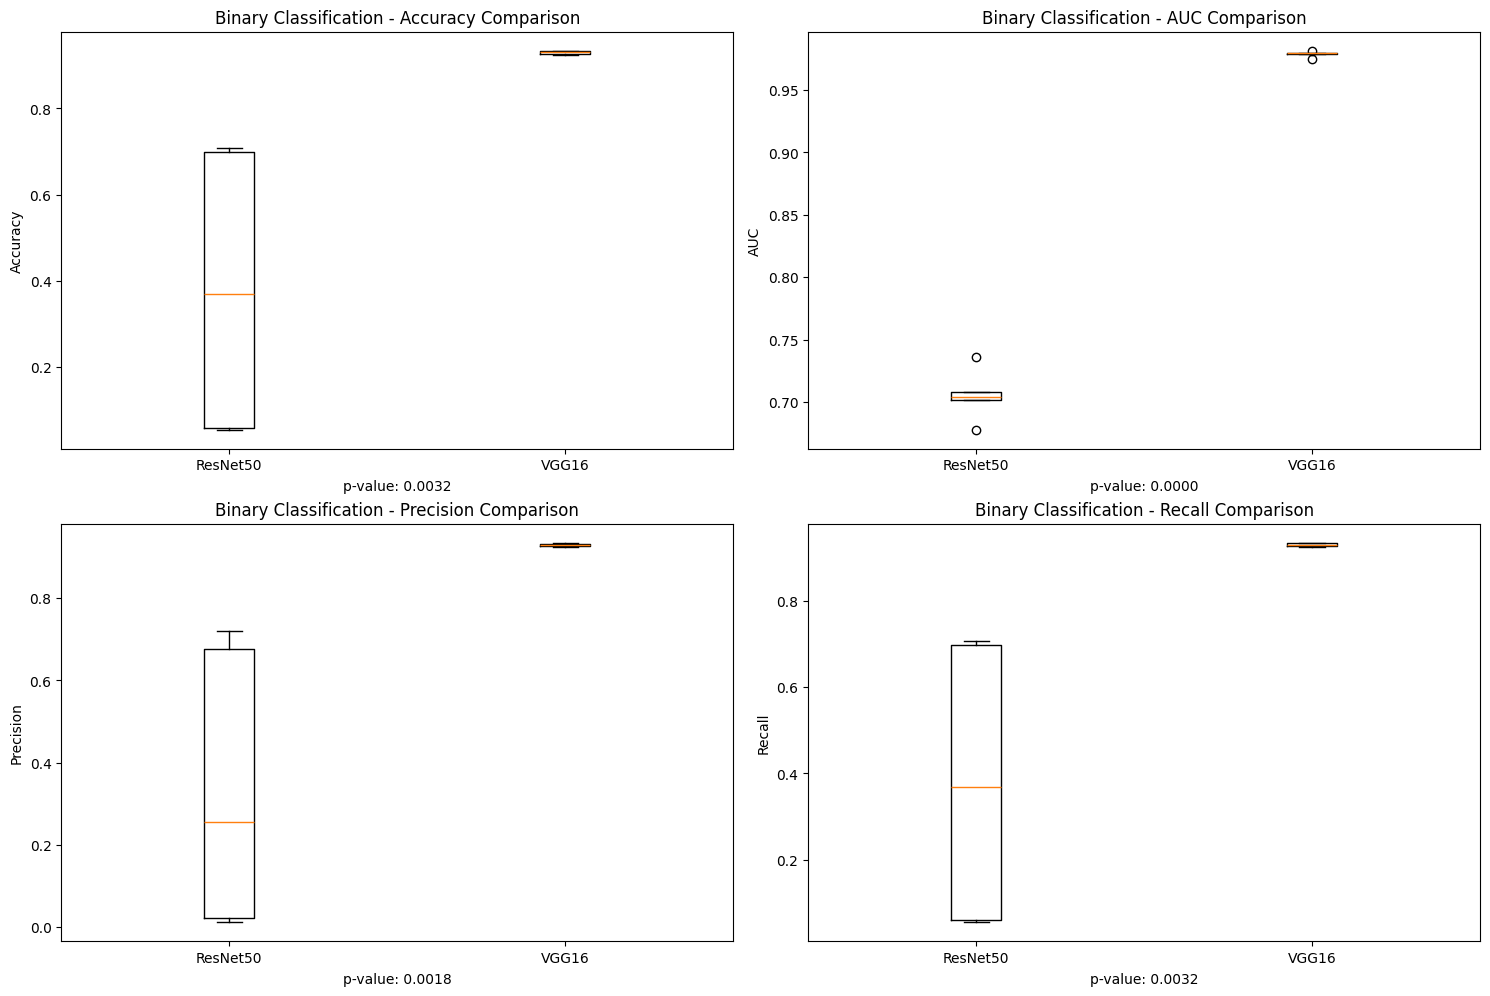


Comparing breed classification performance...


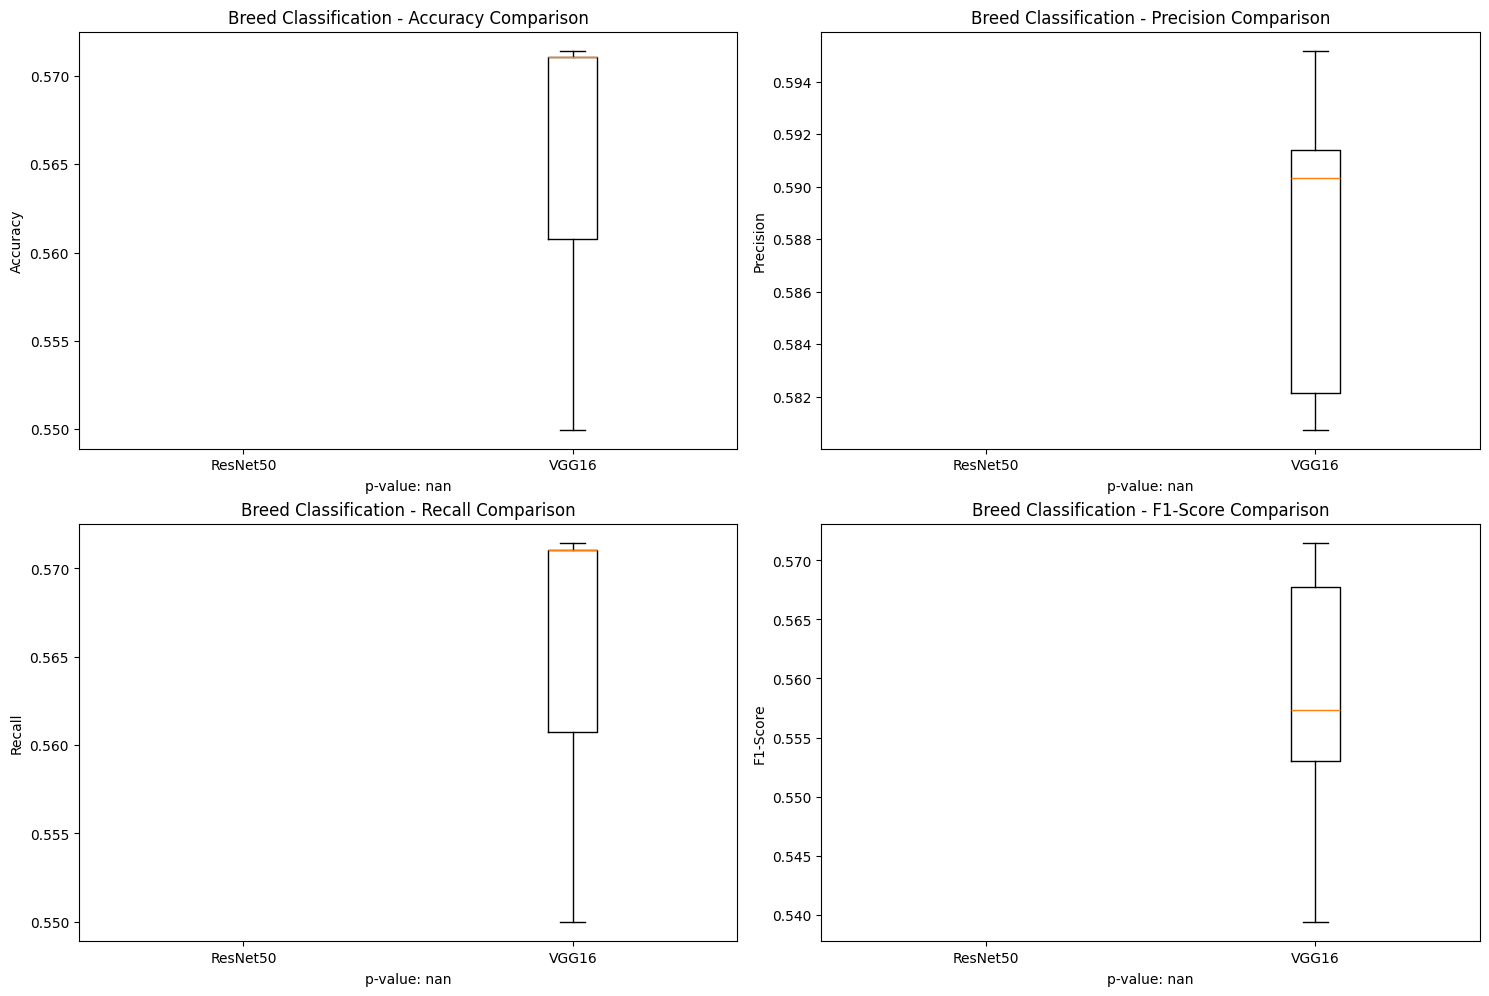


Comparing training efficiency...


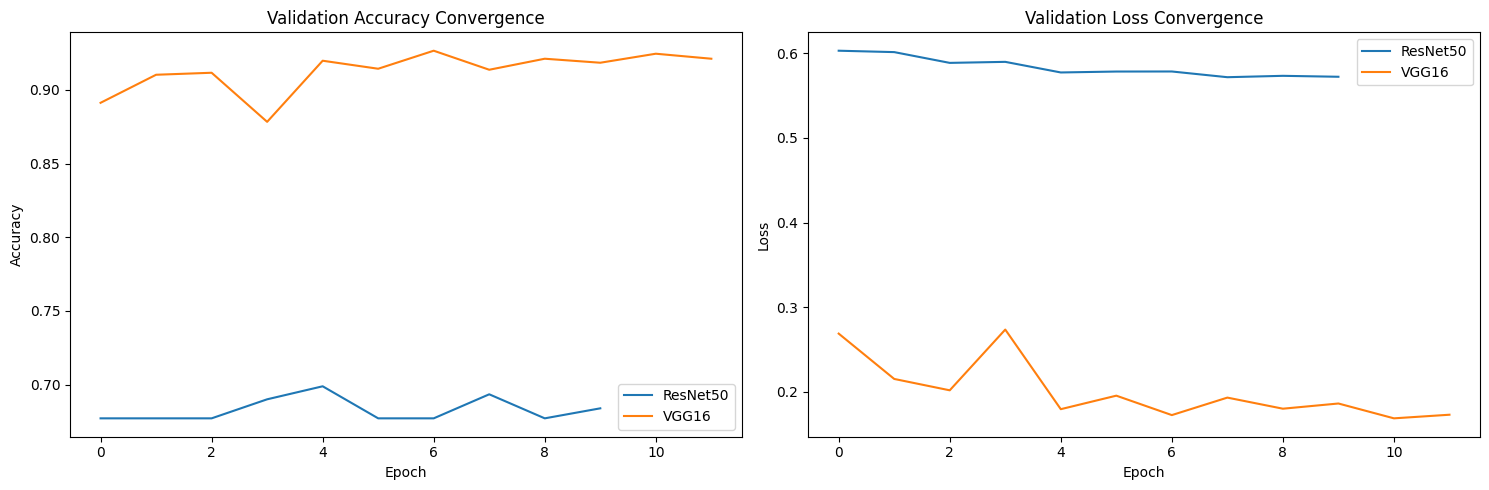


Model comparison completed!


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import pandas as pd
import os

def load_evaluation_results():
    """
    Load evaluation results for both models
    """
    resnet50_results = np.load(os.path.join(BASE_PATH, 'results/metrics/resnet50_evaluation_results.npy'),
                              allow_pickle=True).item()
    vgg16_results = np.load(os.path.join(BASE_PATH, 'results/metrics/vgg16_evaluation_results.npy'),
                           allow_pickle=True).item()
    return resnet50_results, vgg16_results

def compare_binary_classification():
    """
    Compare binary classification performance between models
    """
    resnet50_results, vgg16_results = load_evaluation_results()

    # Prepare data for comparison
    metrics = {
        'ResNet50': {
            'Accuracy': [],
            'AUC': resnet50_results['binary']['roc_auc_scores'],
            'Precision': [],
            'Recall': []
        },
        'VGG16': {
            'Accuracy': [],
            'AUC': vgg16_results['binary']['roc_auc_scores'],
            'Precision': [],
            'Recall': []
        }
    }

    # Extract metrics from classification reports
    for model, results in [('ResNet50', resnet50_results), ('VGG16', vgg16_results)]:
        for report in results['binary']['classification_reports']:
            metrics[model]['Accuracy'].append(report['accuracy'])
            metrics[model]['Precision'].append(report['weighted avg']['precision'])
            metrics[model]['Recall'].append(report['weighted avg']['recall'])

    # Plot comparison
    plt.figure(figsize=(15, 10))

    # Metrics comparison
    for i, metric in enumerate(['Accuracy', 'AUC', 'Precision', 'Recall']):
        plt.subplot(2, 2, i+1)
        data = [metrics['ResNet50'][metric], metrics['VGG16'][metric]]
        plt.boxplot(data, labels=['ResNet50', 'VGG16'])
        plt.title(f'Binary Classification - {metric} Comparison')
        plt.ylabel(metric)

        # Add statistical test
        t_stat, p_value = stats.ttest_ind(metrics['ResNet50'][metric],
                                        metrics['VGG16'][metric])
        plt.text(0.5, -0.1, f'p-value: {p_value:.4f}',
                ha='center', transform=plt.gca().transAxes)

    plt.tight_layout()
    plt.savefig(os.path.join(BASE_PATH, 'results/plots/binary_comparison.png'))
    plt.show()

def compare_breed_classification():
    """
    Compare breed classification performance between models
    """
    resnet50_results, vgg16_results = load_evaluation_results()

    # Prepare data for comparison
    metrics = {
        'ResNet50': {
            'Accuracy': [],
            'Precision': [],
            'Recall': [],
            'F1-Score': []
        },
        'VGG16': {
            'Accuracy': [],
            'Precision': [],
            'Recall': [],
            'F1-Score': []
        }
    }

    # Extract metrics from classification reports
    for model, results in [('ResNet50', resnet50_results), ('VGG16', vgg16_results)]:
        for report in results['breed']['classification_reports']:
            metrics[model]['Accuracy'].append(report['accuracy'])
            metrics[model]['Precision'].append(report['weighted avg']['precision'])
            metrics[model]['Recall'].append(report['weighted avg']['recall'])
            metrics[model]['F1-Score'].append(report['weighted avg']['f1-score'])

    # Plot comparison
    plt.figure(figsize=(15, 10))

    # Metrics comparison
    for i, metric in enumerate(['Accuracy', 'Precision', 'Recall', 'F1-Score']):
        plt.subplot(2, 2, i+1)
        data = [metrics['ResNet50'][metric], metrics['VGG16'][metric]]
        plt.boxplot(data, labels=['ResNet50', 'VGG16'])
        plt.title(f'Breed Classification - {metric} Comparison')
        plt.ylabel(metric)

        # Add statistical test
        t_stat, p_value = stats.ttest_ind(metrics['ResNet50'][metric],
                                        metrics['VGG16'][metric])
        plt.text(0.5, -0.1, f'p-value: {p_value:.4f}',
                ha='center', transform=plt.gca().transAxes)

    plt.tight_layout()
    plt.savefig(os.path.join(BASE_PATH, 'results/plots/breed_comparison.png'))
    plt.show()

def compare_training_efficiency():
    """
    Compare training efficiency between models
    """
    plt.figure(figsize=(15, 5))

    # Load training histories
    resnet50_history = np.load(os.path.join(BASE_PATH, 'results/metrics/resnet50_binary_fold_0_history.npy'),
                              allow_pickle=True).item()
    vgg16_history = np.load(os.path.join(BASE_PATH, 'results/metrics/vgg16_binary_fold_0_history.npy'),
                           allow_pickle=True).item()

    # Plot accuracy convergence
    plt.subplot(1, 2, 1)
    plt.plot(resnet50_history['val_accuracy'], label='ResNet50')
    plt.plot(vgg16_history['val_accuracy'], label='VGG16')
    plt.title('Validation Accuracy Convergence')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss convergence
    plt.subplot(1, 2, 2)
    plt.plot(resnet50_history['val_loss'], label='ResNet50')
    plt.plot(vgg16_history['val_loss'], label='VGG16')
    plt.title('Validation Loss Convergence')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.savefig(os.path.join(BASE_PATH, 'results/plots/training_efficiency_comparison.png'))
    plt.show()

# Execute comparison
print("Starting model comparison...")

print("\nComparing binary classification performance...")
compare_binary_classification()

print("\nComparing breed classification performance...")
compare_breed_classification()

print("\nComparing training efficiency...")
compare_training_efficiency()

print("\nModel comparison completed!")

After comparing the resnet50 and vgg16, it can be concluded that the Model accurance, AUC of vgg16 higher than resnet50, vgg16 has lower Model loss than the resnet 50. we can say that in every metrics vgg16 Performs better than resnet 50